In [ ]:
!pip install yfinance --upgrade
!pip install stockstats --upgrade
!pip install keras --upgrade
!pip install tensorflow --upgrade
!pip install --upgrade protobuf

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from stockstats import StockDataFrame as sdf

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from keras import models, layers, applications, optimizers, regularizers, constraints
from keras.initializers import glorot_normal
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping

In [2]:
np.random.seed(2)
tf.random.set_seed(3)

In [3]:
def is_third_friday(s):
    d = datetime.strptime(s, '%Y-%m-%d')
    return d.weekday() == 4 and 15 <= d.day <= 21

In [4]:
def is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

In [5]:
tic = 'AAPL'
stock = yf.Ticker(tic)
stock_df = yf.download(tic, start='1999-08-11', end='2021-08-12')
data_df = pd.DataFrame().append(stock_df)
    
# reset the index, we want to use numbers as index instead of dates
data_df = data_df.reset_index()

# convert the column names to standardized names
data_df.columns = ["date", "open", "high", "low", "close", "adjcp", "volume"]

[*********************100%***********************]  1 of 1 completed


In [6]:
# use adjusted close price instead of close price
#data_df["close"] = data_df["adjcp"]
#data_df = data_df.drop("adjcp", 1)

# convert date to standard string format, easy to filter
data_df["year"] = data_df.date.dt.year
data_df["dayofyear"] = data_df.date.dt.dayofyear
data_df["dayofweek"] = data_df.date.dt.dayofweek + 1
data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))

#for date normalization
data_df['dayofyear_sin'] = 0.01
data_df['dayofyear_cos'] = 0.01
data_df['dayofweek_sin'] = 0.01
data_df['dayofweek_cos'] = 0.01

# drop missing data
data_df = data_df.dropna()
data_df = data_df.sort_values(by=['date']).reset_index(drop=True)
stock = sdf.retype(data_df.copy())

In [7]:
for ind in ['close_-1_r', 'volume_20_sma', 'atr', 'close_20_ema', 'close_50_ema', 'close_100_ema', 'rsi_14']:
    temp_ind = pd.DataFrame(stock[ind])
    #data_df[ind] = temp_ind
    
    data_df = data_df.merge(temp_ind,on='date',how='left')

#data_df
data_df = data_df.sort_values(by=['date'])

#take slice of 100 onwards
data_df = data_df[100:]

#add new attributes
data_df['volume_delta'] = 0.0
data_df['close_20_ema_delta'] = 0.0
data_df['close_50_ema_delta'] = 0.0
data_df['close_100_ema_delta'] = 0.0
data_df['option_expiry'] = '2999-12-31'
data_df['floor_held'] = 0

data_df.drop(labels=['open','high', 'low', 'adjcp'], axis=1, inplace=True)
data_df

,date,close,volume,year,dayofyear,dayofweek,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,...,close_20_ema,close_50_ema,close_100_ema,rsi_14,volume_delta,close_20_ema_delta,close_50_ema_delta,close_100_ema_delta,option_expiry,floor_held
100,2000-01-03,0.999442,535796800,2000,3,1,0.01,0.01,0.01,0.01,...,0.905200,0.849883,0.795880,64.525721,0.0,0.0,0.0,0.0,2999-12-31,0
101,2000-01-04,0.915179,512377600,2000,4,2,0.01,0.01,0.01,0.01,...,0.906151,0.852487,0.798595,52.466557,0.0,0.0,0.0,0.0,2999-12-31,0
102,2000-01-05,0.928571,778321600,2000,5,3,0.01,0.01,0.01,0.01,...,0.908286,0.855520,0.801545,53.939892,0.0,0.0,0.0,0.0,2999-12-31,0
103,2000-01-06,0.848214,767972800,2000,6,4,0.01,0.01,0.01,0.01,...,0.902565,0.855229,0.802601,44.938926,0.0,0.0,0.0,0.0,2999-12-31,0
104,2000-01-07,0.888393,460734400,2000,7,5,0.01,0.01,0.01,0.01,...,0.901215,0.856549,0.804537,49.478504,0.0,0.0,0.0,0.0,2999-12-31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5532,2021-08-05,147.059998,46397700,2021,217,4,0.01,0.01,0.01,0.01,...,145.035288,139.842106,134.909808,60.145643,0.0,0.0,0.0,0.0,2999-12-31,0
5533,2021-08-06,146.139999,54067400,2021,218,5,0.01,0.01,0.01,0.01,...,145.140498,140.089082,135.132188,56.990263,0.0,0.0,0.0,0.0,2999-12-31,0
5534,2021-08-09,146.089996,48908700,2021,221,1,0.01,0.01,0.01,0.01,...,145.230927,140.324412,135.349174,56.815797,0.0,0.0,0.0,0.0,2999-12-31,0
5535,2021-08-10,145.600006,69023100,2021,222,2,0.01,0.01,0.01,0.01,...,145.266077,140.531298,135.552161,55.037738,0.0,0.0,0.0,0.0,2999-12-31,0


In [8]:
data_df.dtypes

date                    object
close                  float64
volume                   int64
year                     int64
dayofyear                int64
dayofweek                int64
dayofyear_sin          float64
dayofyear_cos          float64
dayofweek_sin          float64
dayofweek_cos          float64
close_-1_r             float64
volume_20_sma          float64
atr                    float64
close_20_ema           float64
close_50_ema           float64
close_100_ema          float64
rsi_14                 float64
volume_delta           float64
close_20_ema_delta     float64
close_50_ema_delta     float64
close_100_ema_delta    float64
option_expiry           object
floor_held               int64
dtype: object

In [9]:
floor_threshold = 0.95
min_days_to_exp = 14

#loop through each row in the data set
#for idx, row in df[df['Date'] >= '2017-08-22'].iterrows():
for i1, d1 in data_df.iterrows():
    day1 = d1['date']
    day1_dt = datetime.strptime(day1, '%Y-%m-%d')
    
    price_floor = floor_threshold*d1['close']
    floor_held = 1
    
    #assign the cyclic date inputs
    data_df.loc[i1, 'dayofyear_sin'] = np.sin(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofyear_cos'] = np.cos(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofweek_sin'] = np.sin(2*np.pi*float(d1['dayofweek'])/5)
    data_df.loc[i1, 'dayofweek_cos'] = np.cos(2*np.pi*float(d1['dayofweek'])/5)
    
    data_df.loc[i1,'volume_delta'] = (d1['volume_20_sma']-d1['volume'])/d1['volume']
    data_df.loc[i1,'close_20_ema_delta'] = (d1['close_20_ema']-d1['close'])/d1['close']
    data_df.loc[i1,'close_50_ema_delta'] = (d1['close_50_ema']-d1['close'])/d1['close']
    data_df.loc[i1,'close_100_ema_delta'] = (d1['close_100_ema']-d1['close'])/d1['close']
    
    for i2, d2 in data_df[data_df['date'] >= day1].iterrows():
        day2 = d2['date']
        day2_dt = datetime.strptime(day2, '%Y-%m-%d')
        price2 = d2['close']
        
        datediff = abs((day2_dt - day1_dt).days)
        
        if price2 < price_floor:
            #print(day1, day2, price_floor, price2)
            floor_held = 0
        
        #if is_third_friday(day2) and datediff > min_days_to_exp:
        if datediff > min_days_to_exp:
            data_df.loc[i1, 'option_expiry'] = day2
            break
            
    data_df.loc[i1,'floor_held'] = floor_held

data_df

,date,close,volume,year,dayofyear,dayofweek,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,...,close_20_ema,close_50_ema,close_100_ema,rsi_14,volume_delta,close_20_ema_delta,close_50_ema_delta,close_100_ema_delta,option_expiry,floor_held
100,2000-01-03,0.999442,535796800,2000,3,1,0.051479,0.998674,9.510565e-01,0.309017,...,0.905200,0.849883,0.795880,64.525721,-0.242234,-0.094294,-0.149643,-0.203676,2000-01-18,0
101,2000-01-04,0.915179,512377600,2000,4,2,0.068615,0.997643,5.877853e-01,-0.809017,...,0.906151,0.852487,0.798595,52.466557,-0.203150,-0.009865,-0.068502,-0.127389,2000-01-19,0
102,2000-01-05,0.928571,778321600,2000,5,3,0.085731,0.996318,-5.877853e-01,-0.809017,...,0.908286,0.855520,0.801545,53.939892,-0.454013,-0.021845,-0.078670,-0.136797,2000-01-20,0
103,2000-01-06,0.848214,767972800,2000,6,4,0.102821,0.994700,-9.510565e-01,0.309017,...,0.902565,0.855229,0.802601,44.938926,-0.423503,0.064077,0.008271,-0.053775,2000-01-21,0
104,2000-01-07,0.888393,460734400,2000,7,5,0.119881,0.992788,-2.449294e-16,1.000000,...,0.901215,0.856549,0.804537,49.478504,-0.081876,0.014433,-0.035844,-0.094391,2000-01-24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5532,2021-08-05,147.059998,46397700,2021,217,4,-0.559589,-0.828770,-9.510565e-01,0.309017,...,145.035288,139.842106,134.909808,60.145643,0.831343,-0.013768,-0.049081,-0.082621,2999-12-31,1
5533,2021-08-06,146.139999,54067400,2021,218,5,-0.573772,-0.819015,-2.449294e-16,1.000000,...,145.140498,140.089082,135.132188,56.990263,0.529182,-0.006839,-0.041405,-0.075324,2999-12-31,1
5534,2021-08-09,146.089996,48908700,2021,221,1,-0.615285,-0.788305,9.510565e-01,0.309017,...,145.230927,140.324412,135.349174,56.815797,0.662473,-0.005880,-0.039466,-0.073522,2999-12-31,1
5535,2021-08-10,145.600006,69023100,2021,222,2,-0.628763,-0.777597,5.877853e-01,-0.809017,...,145.266077,140.531298,135.552161,55.037738,0.154964,-0.002293,-0.034813,-0.069010,2999-12-31,1


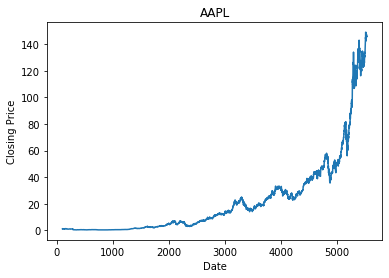

In [10]:
'''
plt.figure(1)
plt.xlabel("Date")
plt.ylabel("Support Held")
plt.title(tic)
plt.plot(data_df['floor_held'], 'o')
'''

plt.figure(0)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(tic)
plt.plot(data_df['close'])

In [11]:
#data_df.drop(labels=['date','year', 'dayofyear', 'dayofweek','option_expiry'], axis=1, inplace=True)
data_df_model = data_df[data_df['option_expiry'] != '2999-12-31']
excludeColumns = ['close', 'volume', 'volume_20_sma', 'close_20_ema', 'close_50_ema', 'close_100_ema',
                  'year', 'dayofyear', 'dayofweek','option_expiry']

#date aren't part of training, but are needed in the testing

data_df_train = data_df_model[data_df_model['year'] < 2020]
data_df_train = data_df_train.iloc[:,~data_df_train.columns.isin(excludeColumns)].copy()

data_df_test = data_df_model[data_df_model['year'] >= 2020]
data_df_test = data_df_test.iloc[:,~data_df_test.columns.isin(excludeColumns)].copy()
#data_df_model = data_df_model.iloc[:,~data_df_model.columns.isin(excludeColumns)].copy()

In [12]:
data_df_test

,date,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,close_-1_r,atr,rsi_14,volume_delta,close_20_ema_delta,close_50_ema_delta,close_100_ema_delta,floor_held
5131,2020-01-02,0.034328,0.999411,-9.510565e-01,0.309017,2.281632,1.142991,84.583737,-0.145501,-0.062947,-0.112678,-0.172009,1
5132,2020-01-03,0.051479,0.998674,-2.449294e-16,1.000000,-0.972204,1.134206,77.703695,-0.181775,-0.048629,-0.099890,-0.160636,1
5133,2020-01-06,0.102821,0.994700,9.510565e-01,0.309017,0.796825,1.181941,79.183674,0.029867,-0.050802,-0.102809,-0.163959,1
5134,2020-01-07,0.119881,0.992788,5.877853e-01,-0.809017,-0.470305,1.158588,75.953553,0.121160,-0.041906,-0.094704,-0.156840,1
5135,2020-01-08,0.136906,0.990584,-5.877853e-01,-0.809017,1.608629,1.205832,79.081928,-0.074307,-0.051638,-0.104760,-0.166818,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,2021-07-21,-0.329408,-0.944188,-5.877853e-01,-0.809017,-0.513171,2.864887,62.344011,0.157809,-0.025405,-0.064426,-0.092189,1
5522,2021-07-22,-0.345612,-0.938377,-9.510565e-01,0.309017,0.962867,2.860253,64.564400,0.133778,-0.031395,-0.070472,-0.098850,1
5523,2021-07-23,-0.361714,-0.932289,-2.449294e-16,1.000000,1.198906,2.793092,67.184062,0.229173,-0.038787,-0.078289,-0.107357,1
5524,2021-07-26,-0.409356,-0.912375,9.510565e-01,0.309017,0.289451,2.745728,67.810205,0.213568,-0.037603,-0.077775,-0.107756,1


In [13]:
ct = ColumnTransformer([
        ('Standard', StandardScaler(),
         ['close_-1_r', 'atr', 'rsi_14', 'volume_delta', 
          'close_20_ema_delta', 'close_50_ema_delta', 'close_100_ema_delta'])],remainder='passthrough')

XY_train = ct.fit_transform(data_df_train)

X_train,X_val,Y_train,Y_val = train_test_split(XY_train[:, 0:-1],XY_train[:, -1], test_size = 0.2)

X_train2 = np.delete(X_train, -5, axis=1)
X_val2 = np.delete(X_val, -5, axis=1)

In [14]:
XY_test = ct.transform(data_df_test)
X_test = XY_test[:, 0:-1]
Y_test = XY_test[:, -1]
X_test2 = np.delete(X_test, -5, axis=1)
X_test2[0,:]

array([0.8498611573352889, 2.532343609817921, 2.271229728607962,
       -0.6838768749514363, -0.8564737601082214, -0.8578276259653402,
       -0.864528277102914, 0.034327600513243496, 0.9994106342455052,
       -0.9510565162951536, 0.30901699437494723], dtype=object)

In [15]:
X_train2 = X_train2.astype('float32')
X_val2 = X_val2.astype('float32')
X_test2 = X_test2.astype('float32')
Y_train = Y_train.astype('int')
Y_val = Y_val.astype('int')
Y_test = Y_test.astype('int')

In [16]:
def generate_trade_plan(X, Y_pred, Y_actual):
    consecutive_ups = 0
    consecutive_downs = 0
    trades = {}
    err_days = 0
    trade_days = 0
    trade_open = 0

    #inverse transform the stock price
    for i, p in enumerate(Y_pred.tolist()):

        #day = round(np.arccos(X_test[i,-3])*365/(2*np.pi),0)
        #trade_date = datetime(2020, 1, 1) + timedelta(day - 1)
        trade_date = X[i,-5]

        if p[0] == 0:        
            consecutive_ups = 0
            consecutive_downs += 1
        else:
            consecutive_ups += 1
            consecutive_downs = 0
        
        #open the trade
        if consecutive_ups >= 3 and trade_open == 0:
            open_date = trade_date
            trade_open = 1
            err_days = 0
            trade_days = 0
        
        #track errors during trade, exit trade after two consecutive exit signals
        if trade_open == 1:
            
            trade_days += 1
            err_days += (p[0] != Y_actual[i])
            
            if consecutive_downs > 1:
                close_date = trade_date
                trade_open = 0
                trades[(open_date,close_date)] = err_days/trade_days
    
    if trade_open == 1:
        trades[(open_date,)] = err_days/trade_days
        
    return trades

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 11s - loss: 0.6515 - accuracy: 0.6121 - val_loss: 0.6128 - val_accuracy: 0.6683
Epoch 2/400
126/126 - 0s - loss: 0.5991 - accuracy: 0.6951 - val_loss: 0.5943 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7097 - val_loss: 0.5923 - val_accuracy: 0.7031
Epoch 4/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7115 - val_loss: 0.5913 - val_accuracy: 0.7021
Epoch 5/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7122 - val_loss: 0.5906 - val_accuracy: 0.7011
Epoch 6/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7125 - val_loss: 0.5899 - val_accuracy: 0.7011
Epoch 7/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7125 - val_loss: 0.5890 - val_accuracy: 0.7021
Epoch 8/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7115 - val_loss: 0.5876 - val_accuracy: 0.7011
Epoch 9/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7112 - val_loss: 0.5874 - val_accuracy: 0.7011
Epoch 10/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7125 - val_loss: 0.5866 - val_accur

Epoch 82/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7222 - val_loss: 0.5609 - val_accuracy: 0.7259
Epoch 83/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7232 - val_loss: 0.5608 - val_accuracy: 0.7239
Epoch 84/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7232 - val_loss: 0.5605 - val_accuracy: 0.7229
Epoch 85/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7232 - val_loss: 0.5608 - val_accuracy: 0.7259
Epoch 86/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7219 - val_loss: 0.5605 - val_accuracy: 0.7279
Epoch 87/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7217 - val_loss: 0.5613 - val_accuracy: 0.7269
Epoch 88/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7239 - val_loss: 0.5606 - val_accuracy: 0.7229
Epoch 89/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7239 - val_loss: 0.5601 - val_accuracy: 0.7279
Epoch 90/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7202 - val_loss: 0.5604 - val_accuracy: 0.7269
Epoch 91/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7217 - val_loss: 0.5600 - v

Epoch 44/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7219 - val_loss: 0.5711 - val_accuracy: 0.7090
Epoch 45/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7249 - val_loss: 0.5711 - val_accuracy: 0.7071
Epoch 46/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7242 - val_loss: 0.5711 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7227 - val_loss: 0.5708 - val_accuracy: 0.7100
Epoch 48/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7251 - val_loss: 0.5716 - val_accuracy: 0.7110
Epoch 49/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7247 - val_loss: 0.5701 - val_accuracy: 0.7090
Epoch 50/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7229 - val_loss: 0.5700 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7251 - val_loss: 0.5704 - val_accuracy: 0.7090
Epoch 52/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7244 - val_loss: 0.5708 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7256 - val_loss: 0.5694 - v

Epoch 60/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7289 - val_loss: 0.5756 - val_accuracy: 0.7120
Epoch 61/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7311 - val_loss: 0.5762 - val_accuracy: 0.7110
Epoch 62/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7281 - val_loss: 0.5754 - val_accuracy: 0.7130
Epoch 63/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7269 - val_loss: 0.5756 - val_accuracy: 0.7100
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
32/32 [==============================] - 0s 717us/step - loss: 0.5754 - accuracy: 0.7110
Epoch 1/400
126/126 - 1s - loss: 0.6841 - accuracy: 0.5736 - val_loss: 0.6298 - val_accuracy: 0.6495
Epoch 2/400
126/126 - 0s - loss: 0.6093 - accuracy: 0.6884 - val_loss: 0.6028 - val_accuracy: 0.6872
Epoch 3/400
126/126 - 0s - loss: 0.5912 - accuracy: 0.7102 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7105 - val_loss: 0.5929 - val_accuracy: 0.6931
Epoch 5/400
126

Epoch 76/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7343 - val_loss: 0.5561 - val_accuracy: 0.7219
Epoch 77/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7321 - val_loss: 0.5561 - val_accuracy: 0.7219
Epoch 78/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7351 - val_loss: 0.5561 - val_accuracy: 0.7229
Epoch 79/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7351 - val_loss: 0.5559 - val_accuracy: 0.7239
Epoch 80/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7333 - val_loss: 0.5559 - val_accuracy: 0.7210
Epoch 81/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7361 - val_loss: 0.5538 - val_accuracy: 0.7289
Epoch 82/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7348 - val_loss: 0.5554 - val_accuracy: 0.7239
Epoch 83/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7376 - val_loss: 0.5536 - val_accuracy: 0.7269
Epoch 84/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7361 - val_loss: 0.5534 - val_accuracy: 0.7309
Epoch 85/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7378 - val_loss: 0.5533 - v

126/126 - 1s - loss: 0.7313 - accuracy: 0.5746 - val_loss: 0.6308 - val_accuracy: 0.6465
Epoch 2/400
126/126 - 0s - loss: 0.6075 - accuracy: 0.6869 - val_loss: 0.6003 - val_accuracy: 0.6842
Epoch 3/400
126/126 - 0s - loss: 0.5930 - accuracy: 0.7100 - val_loss: 0.5940 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7090 - val_loss: 0.5909 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5873 - accuracy: 0.7090 - val_loss: 0.5893 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7100 - val_loss: 0.5883 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7085 - val_loss: 0.5879 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7097 - val_loss: 0.5858 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7095 - val_loss: 0.5861 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7092 - val_loss: 0.5850 - val_accuracy: 0.6941
E

Epoch 82/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7321 - val_loss: 0.5605 - val_accuracy: 0.7190
Epoch 83/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7309 - val_loss: 0.5577 - val_accuracy: 0.7210
Epoch 84/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7336 - val_loss: 0.5576 - val_accuracy: 0.7229
Epoch 85/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7314 - val_loss: 0.5580 - val_accuracy: 0.7259
Epoch 86/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7321 - val_loss: 0.5580 - val_accuracy: 0.7269
Epoch 87/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7321 - val_loss: 0.5586 - val_accuracy: 0.7259
Epoch 88/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7331 - val_loss: 0.5584 - val_accuracy: 0.7229
Epoch 89/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7304 - val_loss: 0.5570 - val_accuracy: 0.7239
Epoch 90/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7326 - val_loss: 0.5583 - val_accuracy: 0.7229
Epoch 91/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7314 - val_loss: 0.5575 - v

Epoch 46/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7189 - val_loss: 0.5728 - val_accuracy: 0.7150
Epoch 47/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7187 - val_loss: 0.5718 - val_accuracy: 0.7140
Epoch 48/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7202 - val_loss: 0.5735 - val_accuracy: 0.7170
Epoch 49/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7199 - val_loss: 0.5709 - val_accuracy: 0.7170
Epoch 50/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7202 - val_loss: 0.5705 - val_accuracy: 0.7140
Epoch 51/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7219 - val_loss: 0.5706 - val_accuracy: 0.7150
Epoch 52/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7199 - val_loss: 0.5711 - val_accuracy: 0.7150
Epoch 53/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7217 - val_loss: 0.5695 - val_accuracy: 0.7190
Epoch 54/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7204 - val_loss: 0.5699 - val_accuracy: 0.7150
Epoch 55/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7222 - val_loss: 0.5707 - v

126/126 - 0s - loss: 0.5430 - accuracy: 0.7361 - val_loss: 0.5616 - val_accuracy: 0.7289
Epoch 127/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7343 - val_loss: 0.5616 - val_accuracy: 0.7279
Epoch 128/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7341 - val_loss: 0.5611 - val_accuracy: 0.7289
Epoch 129/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7331 - val_loss: 0.5605 - val_accuracy: 0.7289
Epoch 130/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7341 - val_loss: 0.5602 - val_accuracy: 0.7289
Epoch 131/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7343 - val_loss: 0.5596 - val_accuracy: 0.7229
Epoch 132/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7316 - val_loss: 0.5606 - val_accuracy: 0.7289
Epoch 133/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7353 - val_loss: 0.5604 - val_accuracy: 0.7279
Epoch 134/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7346 - val_loss: 0.5599 - val_accuracy: 0.7269
Epoch 135/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7348 - val_loss: 0.5616 - val_a

Epoch 22/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7112 - val_loss: 0.5817 - val_accuracy: 0.7001
Epoch 23/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7122 - val_loss: 0.5808 - val_accuracy: 0.7001
Epoch 24/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7115 - val_loss: 0.5810 - val_accuracy: 0.6991
Epoch 25/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7115 - val_loss: 0.5820 - val_accuracy: 0.7021
Epoch 26/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7120 - val_loss: 0.5812 - val_accuracy: 0.7051
Epoch 27/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7120 - val_loss: 0.5808 - val_accuracy: 0.7021
Epoch 28/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7120 - val_loss: 0.5803 - val_accuracy: 0.7051
Epoch 29/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7135 - val_loss: 0.5798 - val_accuracy: 0.7051
Epoch 30/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7135 - val_loss: 0.5796 - val_accuracy: 0.7071
Epoch 31/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7140 - val_loss: 0.5787 - v

Epoch 103/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7326 - val_loss: 0.5692 - val_accuracy: 0.7061
Epoch 104/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7309 - val_loss: 0.5684 - val_accuracy: 0.7061
Epoch 105/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7331 - val_loss: 0.5668 - val_accuracy: 0.7080
Epoch 106/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7329 - val_loss: 0.5679 - val_accuracy: 0.7061
Epoch 107/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7371 - val_loss: 0.5669 - val_accuracy: 0.7080
Epoch 108/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7341 - val_loss: 0.5680 - val_accuracy: 0.7071
Epoch 109/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7333 - val_loss: 0.5695 - val_accuracy: 0.7090
Epoch 110/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7326 - val_loss: 0.5684 - val_accuracy: 0.7071
Epoch 111/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7348 - val_loss: 0.5696 - val_accuracy: 0.7090
Epoch 112/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7324 - val_loss: 

Epoch 67/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7249 - val_loss: 0.5654 - val_accuracy: 0.7110
Epoch 68/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7239 - val_loss: 0.5641 - val_accuracy: 0.7110
Epoch 69/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7259 - val_loss: 0.5654 - val_accuracy: 0.7140
Epoch 70/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7232 - val_loss: 0.5645 - val_accuracy: 0.7120
Epoch 71/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7289 - val_loss: 0.5636 - val_accuracy: 0.7110
Epoch 72/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7294 - val_loss: 0.5639 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7274 - val_loss: 0.5636 - val_accuracy: 0.7120
Epoch 74/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7261 - val_loss: 0.5629 - val_accuracy: 0.7090
Epoch 75/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7276 - val_loss: 0.5641 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7259 - val_loss: 0.5626 - v

Epoch 147/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7309 - val_loss: 0.5555 - val_accuracy: 0.7200
Epoch 148/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7331 - val_loss: 0.5555 - val_accuracy: 0.7249
Epoch 149/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7351 - val_loss: 0.5561 - val_accuracy: 0.7239
Epoch 150/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7316 - val_loss: 0.5553 - val_accuracy: 0.7269
Epoch 151/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7326 - val_loss: 0.5552 - val_accuracy: 0.7259
Epoch 152/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7338 - val_loss: 0.5558 - val_accuracy: 0.7200
Epoch 153/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7351 - val_loss: 0.5554 - val_accuracy: 0.7200
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
32/32 [==============================] - 0s 740us/step - loss: 0.5548 - accuracy: 0.7319
Epoch 1/400
126/126 - 1s - loss: 0.6652 - accuracy: 0.6170 - val_loss: 0.6205 - val_accuracy: 0.6941
Epoch

Epoch 73/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7237 - val_loss: 0.5616 - val_accuracy: 0.7279
Epoch 74/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7247 - val_loss: 0.5609 - val_accuracy: 0.7249
Epoch 75/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7222 - val_loss: 0.5617 - val_accuracy: 0.7299
Epoch 76/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7234 - val_loss: 0.5606 - val_accuracy: 0.7279
Epoch 77/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7227 - val_loss: 0.5614 - val_accuracy: 0.7319
Epoch 78/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7214 - val_loss: 0.5612 - val_accuracy: 0.7319
Epoch 79/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7219 - val_loss: 0.5605 - val_accuracy: 0.7319
Epoch 80/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7249 - val_loss: 0.5607 - val_accuracy: 0.7249
Epoch 81/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7232 - val_loss: 0.5603 - val_accuracy: 0.7299
Epoch 82/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7251 - val_loss: 0.5607 - v

Epoch 153/400
126/126 - 0s - loss: 0.5376 - accuracy: 0.7391 - val_loss: 0.5505 - val_accuracy: 0.7289
Epoch 154/400
126/126 - 0s - loss: 0.5381 - accuracy: 0.7433 - val_loss: 0.5490 - val_accuracy: 0.7349
Epoch 155/400
126/126 - 0s - loss: 0.5375 - accuracy: 0.7403 - val_loss: 0.5487 - val_accuracy: 0.7329
Epoch 156/400
126/126 - 0s - loss: 0.5374 - accuracy: 0.7401 - val_loss: 0.5488 - val_accuracy: 0.7319
Epoch 157/400
126/126 - 0s - loss: 0.5371 - accuracy: 0.7386 - val_loss: 0.5483 - val_accuracy: 0.7329
Epoch 158/400
126/126 - 0s - loss: 0.5363 - accuracy: 0.7401 - val_loss: 0.5490 - val_accuracy: 0.7279
Epoch 159/400
126/126 - 0s - loss: 0.5368 - accuracy: 0.7391 - val_loss: 0.5481 - val_accuracy: 0.7289
Epoch 160/400
126/126 - 0s - loss: 0.5360 - accuracy: 0.7411 - val_loss: 0.5489 - val_accuracy: 0.7319
Epoch 161/400
126/126 - 0s - loss: 0.5364 - accuracy: 0.7381 - val_loss: 0.5480 - val_accuracy: 0.7289
Epoch 162/400
126/126 - 0s - loss: 0.5361 - accuracy: 0.7396 - val_loss: 

Epoch 233/400
126/126 - 0s - loss: 0.5218 - accuracy: 0.7465 - val_loss: 0.5337 - val_accuracy: 0.7358
Epoch 234/400
126/126 - 0s - loss: 0.5222 - accuracy: 0.7490 - val_loss: 0.5315 - val_accuracy: 0.7358
Epoch 235/400
126/126 - 0s - loss: 0.5217 - accuracy: 0.7473 - val_loss: 0.5321 - val_accuracy: 0.7358
Epoch 236/400
126/126 - 0s - loss: 0.5215 - accuracy: 0.7473 - val_loss: 0.5315 - val_accuracy: 0.7339
Epoch 237/400
126/126 - 0s - loss: 0.5212 - accuracy: 0.7428 - val_loss: 0.5312 - val_accuracy: 0.7398
Epoch 238/400
126/126 - 0s - loss: 0.5210 - accuracy: 0.7510 - val_loss: 0.5315 - val_accuracy: 0.7349
Epoch 239/400
126/126 - 0s - loss: 0.5208 - accuracy: 0.7463 - val_loss: 0.5314 - val_accuracy: 0.7418
Epoch 240/400
126/126 - 0s - loss: 0.5203 - accuracy: 0.7480 - val_loss: 0.5318 - val_accuracy: 0.7329
Epoch 241/400
126/126 - 0s - loss: 0.5206 - accuracy: 0.7473 - val_loss: 0.5318 - val_accuracy: 0.7329
Epoch 242/400
126/126 - 0s - loss: 0.5204 - accuracy: 0.7485 - val_loss: 

Epoch 40/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7177 - val_loss: 0.5818 - val_accuracy: 0.7150
Epoch 41/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7202 - val_loss: 0.5820 - val_accuracy: 0.7170
Epoch 42/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7189 - val_loss: 0.5809 - val_accuracy: 0.7100
Epoch 43/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7189 - val_loss: 0.5808 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7189 - val_loss: 0.5811 - val_accuracy: 0.7140
Epoch 45/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7202 - val_loss: 0.5808 - val_accuracy: 0.7150
Epoch 46/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7194 - val_loss: 0.5808 - val_accuracy: 0.7160
Epoch 47/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7197 - val_loss: 0.5809 - val_accuracy: 0.7170
Epoch 48/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7199 - val_loss: 0.5815 - val_accuracy: 0.7180
Epoch 49/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7204 - val_loss: 0.5800 - v

126/126 - 0s - loss: 0.5518 - accuracy: 0.7291 - val_loss: 0.5708 - val_accuracy: 0.7160
Epoch 121/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7274 - val_loss: 0.5718 - val_accuracy: 0.7200
Epoch 122/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7289 - val_loss: 0.5710 - val_accuracy: 0.7190
Epoch 123/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7286 - val_loss: 0.5708 - val_accuracy: 0.7219
Epoch 124/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7286 - val_loss: 0.5709 - val_accuracy: 0.7160
Epoch 125/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7296 - val_loss: 0.5716 - val_accuracy: 0.7200
Epoch 126/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7291 - val_loss: 0.5708 - val_accuracy: 0.7200
Epoch 127/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7284 - val_loss: 0.5706 - val_accuracy: 0.7210
Epoch 128/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7274 - val_loss: 0.5705 - val_accuracy: 0.7190
Epoch 129/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7281 - val_loss: 0.5704 - val_a

Epoch 200/400
126/126 - 0s - loss: 0.5398 - accuracy: 0.7326 - val_loss: 0.5622 - val_accuracy: 0.7239
Epoch 201/400
126/126 - 0s - loss: 0.5392 - accuracy: 0.7321 - val_loss: 0.5618 - val_accuracy: 0.7259
Epoch 202/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7314 - val_loss: 0.5620 - val_accuracy: 0.7229
Epoch 203/400
126/126 - 0s - loss: 0.5395 - accuracy: 0.7336 - val_loss: 0.5626 - val_accuracy: 0.7249
Epoch 204/400
126/126 - 0s - loss: 0.5397 - accuracy: 0.7346 - val_loss: 0.5618 - val_accuracy: 0.7279
Restoring model weights from the end of the best epoch.
Epoch 00204: early stopping
32/32 [==============================] - 0s 797us/step - loss: 0.5614 - accuracy: 0.7239
Epoch 1/400
126/126 - 1s - loss: 0.6524 - accuracy: 0.6168 - val_loss: 0.6171 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.6029 - accuracy: 0.6998 - val_loss: 0.5974 - val_accuracy: 0.6922
Epoch 3/400
126/126 - 0s - loss: 0.5920 - accuracy: 0.7085 - val_loss: 0.5941 - val_accuracy: 0.6971
Epoch 4/4

126/126 - 0s - loss: 0.5776 - accuracy: 0.7132 - val_loss: 0.5933 - val_accuracy: 0.6971
Epoch 11/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7137 - val_loss: 0.5931 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7137 - val_loss: 0.5929 - val_accuracy: 0.6971
Epoch 13/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7137 - val_loss: 0.5929 - val_accuracy: 0.6971
Epoch 14/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7147 - val_loss: 0.5920 - val_accuracy: 0.6961
Epoch 15/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7142 - val_loss: 0.5918 - val_accuracy: 0.6961
Epoch 16/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7135 - val_loss: 0.5918 - val_accuracy: 0.6981
Epoch 17/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7147 - val_loss: 0.5913 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7147 - val_loss: 0.5911 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7160 - val_loss: 0.5904 - val_accuracy: 

Epoch 91/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7291 - val_loss: 0.5819 - val_accuracy: 0.7061
Epoch 92/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7294 - val_loss: 0.5814 - val_accuracy: 0.7140
Epoch 93/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7329 - val_loss: 0.5823 - val_accuracy: 0.7150
Epoch 94/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7311 - val_loss: 0.5815 - val_accuracy: 0.7150
Epoch 95/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7306 - val_loss: 0.5812 - val_accuracy: 0.7090
Epoch 96/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7311 - val_loss: 0.5817 - val_accuracy: 0.7150
Epoch 97/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7341 - val_loss: 0.5815 - val_accuracy: 0.7100
Epoch 98/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7281 - val_loss: 0.5802 - val_accuracy: 0.7130
Epoch 99/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7319 - val_loss: 0.5814 - val_accuracy: 0.7150
Epoch 100/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7336 - val_loss: 0.5817 - 

Epoch 20/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7142 - val_loss: 0.5881 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7147 - val_loss: 0.5877 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7145 - val_loss: 0.5873 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7147 - val_loss: 0.5866 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7162 - val_loss: 0.5867 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7162 - val_loss: 0.5869 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7165 - val_loss: 0.5865 - val_accuracy: 0.6971
Epoch 27/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7152 - val_loss: 0.5860 - val_accuracy: 0.6991
Epoch 28/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7179 - val_loss: 0.5858 - val_accuracy: 0.6971
Epoch 29/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7167 - val_loss: 0.5853 - v

32/32 [==============================] - 0s 708us/step - loss: 0.5780 - accuracy: 0.7120
Epoch 1/400
126/126 - 1s - loss: 0.7521 - accuracy: 0.5283 - val_loss: 0.6552 - val_accuracy: 0.6365
Epoch 2/400
126/126 - 0s - loss: 0.6169 - accuracy: 0.6914 - val_loss: 0.6049 - val_accuracy: 0.7031
Epoch 3/400
126/126 - 0s - loss: 0.5948 - accuracy: 0.7130 - val_loss: 0.5973 - val_accuracy: 0.6981
Epoch 4/400
126/126 - 0s - loss: 0.5897 - accuracy: 0.7100 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7102 - val_loss: 0.5939 - val_accuracy: 0.6902
Epoch 6/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7115 - val_loss: 0.5933 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7107 - val_loss: 0.5922 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7122 - val_loss: 0.5904 - val_accuracy: 0.6981
Epoch 9/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7130 - val_loss: 0.5907 - val_accuracy: 0.6971
Ep

Epoch 16/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7157 - val_loss: 0.5874 - val_accuracy: 0.6961
Epoch 17/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7172 - val_loss: 0.5871 - val_accuracy: 0.6981
Epoch 18/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7172 - val_loss: 0.5868 - val_accuracy: 0.6991
Epoch 19/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7197 - val_loss: 0.5861 - val_accuracy: 0.7011
Epoch 20/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7199 - val_loss: 0.5867 - val_accuracy: 0.7001
Epoch 21/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7184 - val_loss: 0.5862 - val_accuracy: 0.6991
Epoch 22/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7207 - val_loss: 0.5860 - val_accuracy: 0.7021
Epoch 23/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7204 - val_loss: 0.5857 - val_accuracy: 0.7041
Epoch 24/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7212 - val_loss: 0.5861 - val_accuracy: 0.7031
Epoch 25/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7214 - val_loss: 0.5860 - v

Epoch 97/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7358 - val_loss: 0.5787 - val_accuracy: 0.7080
Epoch 98/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7383 - val_loss: 0.5780 - val_accuracy: 0.7100
Epoch 99/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7368 - val_loss: 0.5784 - val_accuracy: 0.7100
Epoch 100/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7381 - val_loss: 0.5796 - val_accuracy: 0.7100
Epoch 101/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7363 - val_loss: 0.5785 - val_accuracy: 0.7071
Epoch 102/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7381 - val_loss: 0.5801 - val_accuracy: 0.7080
Epoch 103/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7391 - val_loss: 0.5789 - val_accuracy: 0.7090
Epoch 104/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7398 - val_loss: 0.5788 - val_accuracy: 0.7110
Epoch 105/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7408 - val_loss: 0.5770 - val_accuracy: 0.7090
Epoch 106/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7401 - val_loss: 0.5

Epoch 23/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7152 - val_loss: 0.5857 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7147 - val_loss: 0.5860 - val_accuracy: 0.6991
Epoch 25/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7157 - val_loss: 0.5856 - val_accuracy: 0.6991
Epoch 26/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7147 - val_loss: 0.5852 - val_accuracy: 0.6981
Epoch 27/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7167 - val_loss: 0.5847 - val_accuracy: 0.6981
Epoch 28/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7157 - val_loss: 0.5847 - val_accuracy: 0.6991
Epoch 29/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7152 - val_loss: 0.5838 - val_accuracy: 0.6981
Epoch 30/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7169 - val_loss: 0.5834 - val_accuracy: 0.6961
Epoch 31/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7155 - val_loss: 0.5827 - val_accuracy: 0.6961
Epoch 32/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7165 - val_loss: 0.5832 - v

Epoch 104/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7343 - val_loss: 0.5682 - val_accuracy: 0.7090
Epoch 105/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7343 - val_loss: 0.5670 - val_accuracy: 0.7090
Epoch 106/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7346 - val_loss: 0.5672 - val_accuracy: 0.7080
Epoch 107/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7331 - val_loss: 0.5665 - val_accuracy: 0.7061
Epoch 108/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7356 - val_loss: 0.5675 - val_accuracy: 0.7090
Epoch 109/400
126/126 - 0s - loss: 0.5455 - accuracy: 0.7358 - val_loss: 0.5674 - val_accuracy: 0.7080
Epoch 110/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7316 - val_loss: 0.5674 - val_accuracy: 0.7100
Epoch 111/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7338 - val_loss: 0.5677 - val_accuracy: 0.7100
Epoch 112/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7353 - val_loss: 0.5667 - val_accuracy: 0.7071
Epoch 113/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7356 - val_loss: 

Epoch 184/400
126/126 - 0s - loss: 0.5342 - accuracy: 0.7376 - val_loss: 0.5564 - val_accuracy: 0.7259
Epoch 185/400
126/126 - 0s - loss: 0.5337 - accuracy: 0.7356 - val_loss: 0.5567 - val_accuracy: 0.7269
Epoch 186/400
126/126 - 0s - loss: 0.5341 - accuracy: 0.7388 - val_loss: 0.5555 - val_accuracy: 0.7299
Epoch 187/400
126/126 - 0s - loss: 0.5338 - accuracy: 0.7398 - val_loss: 0.5558 - val_accuracy: 0.7319
Epoch 188/400
126/126 - 0s - loss: 0.5333 - accuracy: 0.7396 - val_loss: 0.5557 - val_accuracy: 0.7269
Epoch 189/400
126/126 - 0s - loss: 0.5332 - accuracy: 0.7381 - val_loss: 0.5542 - val_accuracy: 0.7239
Epoch 190/400
126/126 - 0s - loss: 0.5339 - accuracy: 0.7381 - val_loss: 0.5546 - val_accuracy: 0.7239
Epoch 191/400
126/126 - 0s - loss: 0.5333 - accuracy: 0.7368 - val_loss: 0.5553 - val_accuracy: 0.7249
Epoch 192/400
126/126 - 0s - loss: 0.5329 - accuracy: 0.7391 - val_loss: 0.5568 - val_accuracy: 0.7259
Epoch 193/400
126/126 - 0s - loss: 0.5337 - accuracy: 0.7376 - val_loss: 

Epoch 264/400
126/126 - 0s - loss: 0.5237 - accuracy: 0.7507 - val_loss: 0.5506 - val_accuracy: 0.7299
Epoch 265/400
126/126 - 0s - loss: 0.5237 - accuracy: 0.7490 - val_loss: 0.5515 - val_accuracy: 0.7279
Epoch 266/400
126/126 - 0s - loss: 0.5239 - accuracy: 0.7493 - val_loss: 0.5506 - val_accuracy: 0.7279
Epoch 267/400
126/126 - 0s - loss: 0.5229 - accuracy: 0.7502 - val_loss: 0.5533 - val_accuracy: 0.7190
Epoch 268/400
126/126 - 0s - loss: 0.5239 - accuracy: 0.7510 - val_loss: 0.5497 - val_accuracy: 0.7358
Epoch 269/400
126/126 - 0s - loss: 0.5235 - accuracy: 0.7483 - val_loss: 0.5509 - val_accuracy: 0.7299
Epoch 270/400
126/126 - 0s - loss: 0.5232 - accuracy: 0.7507 - val_loss: 0.5506 - val_accuracy: 0.7319
Epoch 271/400
126/126 - 0s - loss: 0.5239 - accuracy: 0.7502 - val_loss: 0.5505 - val_accuracy: 0.7339
Epoch 272/400
126/126 - 0s - loss: 0.5227 - accuracy: 0.7505 - val_loss: 0.5519 - val_accuracy: 0.7249
Epoch 273/400
126/126 - 0s - loss: 0.5227 - accuracy: 0.7517 - val_loss: 

Epoch 56/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7214 - val_loss: 0.5751 - val_accuracy: 0.7110
Epoch 57/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7232 - val_loss: 0.5744 - val_accuracy: 0.7110
Epoch 58/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7227 - val_loss: 0.5742 - val_accuracy: 0.7080
Epoch 59/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7222 - val_loss: 0.5749 - val_accuracy: 0.7120
Epoch 60/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7229 - val_loss: 0.5743 - val_accuracy: 0.7120
Epoch 61/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7237 - val_loss: 0.5740 - val_accuracy: 0.7061
Epoch 62/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7229 - val_loss: 0.5737 - val_accuracy: 0.7090
Epoch 63/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7222 - val_loss: 0.5745 - val_accuracy: 0.7100
Epoch 64/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7224 - val_loss: 0.5745 - val_accuracy: 0.7110
Epoch 65/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7224 - val_loss: 0.5750 - v

Epoch 136/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7363 - val_loss: 0.5703 - val_accuracy: 0.7239
Epoch 137/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7346 - val_loss: 0.5690 - val_accuracy: 0.7279
Epoch 138/400
126/126 - 0s - loss: 0.5444 - accuracy: 0.7393 - val_loss: 0.5702 - val_accuracy: 0.7200
Epoch 139/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7381 - val_loss: 0.5694 - val_accuracy: 0.7249
Epoch 140/400
126/126 - 0s - loss: 0.5438 - accuracy: 0.7378 - val_loss: 0.5713 - val_accuracy: 0.7239
Restoring model weights from the end of the best epoch.
Epoch 00140: early stopping
32/32 [==============================] - 0s 804us/step - loss: 0.5683 - accuracy: 0.7269
Epoch 1/400
126/126 - 1s - loss: 0.8775 - accuracy: 0.5050 - val_loss: 0.6861 - val_accuracy: 0.6207
Epoch 2/400
126/126 - 0s - loss: 0.6217 - accuracy: 0.7000 - val_loss: 0.6118 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5974 - accuracy: 0.7075 - val_loss: 0.6022 - val_accuracy: 0.6912
Epoch 4/4

Epoch 75/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7321 - val_loss: 0.5767 - val_accuracy: 0.7080
Epoch 76/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7329 - val_loss: 0.5755 - val_accuracy: 0.7130
Epoch 77/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7333 - val_loss: 0.5760 - val_accuracy: 0.7090
Epoch 78/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7329 - val_loss: 0.5760 - val_accuracy: 0.7110
Epoch 79/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7343 - val_loss: 0.5753 - val_accuracy: 0.7120
Epoch 80/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7346 - val_loss: 0.5756 - val_accuracy: 0.7120
Epoch 81/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7321 - val_loss: 0.5754 - val_accuracy: 0.7080
Epoch 82/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7331 - val_loss: 0.5756 - val_accuracy: 0.7120
Epoch 83/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7343 - val_loss: 0.5748 - val_accuracy: 0.7090
Epoch 84/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7341 - val_loss: 0.5741 - v

Epoch 39/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7202 - val_loss: 0.5823 - val_accuracy: 0.7001
Epoch 40/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7207 - val_loss: 0.5826 - val_accuracy: 0.7021
Epoch 41/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7227 - val_loss: 0.5841 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7204 - val_loss: 0.5813 - val_accuracy: 0.7021
Epoch 43/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7204 - val_loss: 0.5819 - val_accuracy: 0.7031
Epoch 44/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7234 - val_loss: 0.5817 - val_accuracy: 0.7021
Epoch 45/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7212 - val_loss: 0.5811 - val_accuracy: 0.7051
Epoch 46/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7234 - val_loss: 0.5829 - val_accuracy: 0.7021
Epoch 47/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7224 - val_loss: 0.5812 - val_accuracy: 0.7061
Epoch 48/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7229 - val_loss: 0.5824 - v

126/126 - 0s - loss: 0.5364 - accuracy: 0.7428 - val_loss: 0.5633 - val_accuracy: 0.7190
Epoch 120/400
126/126 - 0s - loss: 0.5359 - accuracy: 0.7418 - val_loss: 0.5614 - val_accuracy: 0.7140
Epoch 121/400
126/126 - 0s - loss: 0.5362 - accuracy: 0.7406 - val_loss: 0.5631 - val_accuracy: 0.7160
Epoch 122/400
126/126 - 0s - loss: 0.5357 - accuracy: 0.7408 - val_loss: 0.5605 - val_accuracy: 0.7219
Epoch 123/400
126/126 - 0s - loss: 0.5353 - accuracy: 0.7435 - val_loss: 0.5600 - val_accuracy: 0.7190
Epoch 124/400
126/126 - 0s - loss: 0.5350 - accuracy: 0.7443 - val_loss: 0.5593 - val_accuracy: 0.7180
Epoch 125/400
126/126 - 0s - loss: 0.5352 - accuracy: 0.7433 - val_loss: 0.5606 - val_accuracy: 0.7219
Epoch 126/400
126/126 - 0s - loss: 0.5347 - accuracy: 0.7420 - val_loss: 0.5594 - val_accuracy: 0.7229
Epoch 127/400
126/126 - 0s - loss: 0.5344 - accuracy: 0.7445 - val_loss: 0.5599 - val_accuracy: 0.7190
Epoch 128/400
126/126 - 0s - loss: 0.5340 - accuracy: 0.7433 - val_loss: 0.5591 - val_a

Epoch 12/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7152 - val_loss: 0.5834 - val_accuracy: 0.6981
Epoch 13/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7147 - val_loss: 0.5840 - val_accuracy: 0.6981
Epoch 14/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7155 - val_loss: 0.5819 - val_accuracy: 0.7001
Epoch 15/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7155 - val_loss: 0.5815 - val_accuracy: 0.7001
Epoch 16/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7162 - val_loss: 0.5810 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7169 - val_loss: 0.5800 - val_accuracy: 0.6981
Epoch 18/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7179 - val_loss: 0.5798 - val_accuracy: 0.7001
Epoch 19/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7172 - val_loss: 0.5792 - val_accuracy: 0.7001
Epoch 20/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7194 - val_loss: 0.5803 - val_accuracy: 0.7001
Epoch 21/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7184 - val_loss: 0.5787 - v

Epoch 93/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7423 - val_loss: 0.5616 - val_accuracy: 0.7279
Epoch 94/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7435 - val_loss: 0.5605 - val_accuracy: 0.7319
Epoch 95/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7455 - val_loss: 0.5597 - val_accuracy: 0.7358
Epoch 96/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7453 - val_loss: 0.5599 - val_accuracy: 0.7358
Epoch 97/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7458 - val_loss: 0.5605 - val_accuracy: 0.7309
Epoch 98/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7440 - val_loss: 0.5596 - val_accuracy: 0.7329
Epoch 99/400
126/126 - 0s - loss: 0.5413 - accuracy: 0.7458 - val_loss: 0.5603 - val_accuracy: 0.7339
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
32/32 [==============================] - 0s 804us/step - loss: 0.5596 - accuracy: 0.7368
Epoch 1/400
126/126 - 1s - loss: 0.6496 - accuracy: 0.6325 - val_loss: 0.6134 - val_accuracy: 0.6892
Epoch 2/400


Epoch 73/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7294 - val_loss: 0.5754 - val_accuracy: 0.7110
Epoch 74/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7266 - val_loss: 0.5753 - val_accuracy: 0.7071
Epoch 75/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7289 - val_loss: 0.5758 - val_accuracy: 0.7110
Epoch 76/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7291 - val_loss: 0.5754 - val_accuracy: 0.7090
Epoch 77/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7284 - val_loss: 0.5754 - val_accuracy: 0.7120
Epoch 78/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7289 - val_loss: 0.5751 - val_accuracy: 0.7120
Epoch 79/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7284 - val_loss: 0.5753 - val_accuracy: 0.7110
Epoch 80/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7294 - val_loss: 0.5759 - val_accuracy: 0.7090
Epoch 81/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7294 - val_loss: 0.5750 - val_accuracy: 0.7130
Epoch 82/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7289 - val_loss: 0.5761 - v

Epoch 12/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7150 - val_loss: 0.5857 - val_accuracy: 0.6991
Epoch 13/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7155 - val_loss: 0.5853 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7145 - val_loss: 0.5843 - val_accuracy: 0.7011
Epoch 15/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7147 - val_loss: 0.5839 - val_accuracy: 0.7001
Epoch 16/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7150 - val_loss: 0.5836 - val_accuracy: 0.6981
Epoch 17/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7155 - val_loss: 0.5831 - val_accuracy: 0.7001
Epoch 18/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7145 - val_loss: 0.5829 - val_accuracy: 0.7011
Epoch 19/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7152 - val_loss: 0.5821 - val_accuracy: 0.7031
Epoch 20/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7152 - val_loss: 0.5821 - val_accuracy: 0.7031
Epoch 21/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7162 - val_loss: 0.5818 - v

Epoch 93/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7351 - val_loss: 0.5666 - val_accuracy: 0.7229
Epoch 94/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7366 - val_loss: 0.5658 - val_accuracy: 0.7249
Epoch 95/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7356 - val_loss: 0.5659 - val_accuracy: 0.7239
Epoch 96/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7336 - val_loss: 0.5655 - val_accuracy: 0.7259
Epoch 97/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7356 - val_loss: 0.5656 - val_accuracy: 0.7229
Epoch 98/400
126/126 - 0s - loss: 0.5491 - accuracy: 0.7348 - val_loss: 0.5649 - val_accuracy: 0.7269
Epoch 99/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7353 - val_loss: 0.5647 - val_accuracy: 0.7279
Epoch 100/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7373 - val_loss: 0.5662 - val_accuracy: 0.7249
Epoch 101/400
126/126 - 0s - loss: 0.5483 - accuracy: 0.7329 - val_loss: 0.5653 - val_accuracy: 0.7229
Epoch 102/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7368 - val_loss: 0.5662 

Epoch 55/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7232 - val_loss: 0.5671 - val_accuracy: 0.7100
Epoch 56/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7234 - val_loss: 0.5664 - val_accuracy: 0.7110
Epoch 57/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7227 - val_loss: 0.5662 - val_accuracy: 0.7120
Epoch 58/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7237 - val_loss: 0.5661 - val_accuracy: 0.7150
Epoch 59/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7237 - val_loss: 0.5661 - val_accuracy: 0.7190
Epoch 60/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7259 - val_loss: 0.5654 - val_accuracy: 0.7140
Epoch 61/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7247 - val_loss: 0.5654 - val_accuracy: 0.7120
Epoch 62/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7251 - val_loss: 0.5651 - val_accuracy: 0.7130
Epoch 63/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7274 - val_loss: 0.5650 - val_accuracy: 0.7130
Epoch 64/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7254 - val_loss: 0.5651 - v

Epoch 135/400
126/126 - 0s - loss: 0.5352 - accuracy: 0.7398 - val_loss: 0.5579 - val_accuracy: 0.7200
Epoch 136/400
126/126 - 0s - loss: 0.5351 - accuracy: 0.7428 - val_loss: 0.5584 - val_accuracy: 0.7259
Epoch 137/400
126/126 - 0s - loss: 0.5352 - accuracy: 0.7401 - val_loss: 0.5570 - val_accuracy: 0.7210
Epoch 138/400
126/126 - 0s - loss: 0.5346 - accuracy: 0.7396 - val_loss: 0.5571 - val_accuracy: 0.7249
Epoch 139/400
126/126 - 0s - loss: 0.5345 - accuracy: 0.7408 - val_loss: 0.5569 - val_accuracy: 0.7279
Epoch 140/400
126/126 - 0s - loss: 0.5342 - accuracy: 0.7401 - val_loss: 0.5576 - val_accuracy: 0.7239
Epoch 141/400
126/126 - 0s - loss: 0.5336 - accuracy: 0.7406 - val_loss: 0.5567 - val_accuracy: 0.7259
Epoch 142/400
126/126 - 0s - loss: 0.5337 - accuracy: 0.7388 - val_loss: 0.5569 - val_accuracy: 0.7259
Epoch 143/400
126/126 - 0s - loss: 0.5336 - accuracy: 0.7420 - val_loss: 0.5562 - val_accuracy: 0.7289
Epoch 144/400
126/126 - 0s - loss: 0.5332 - accuracy: 0.7406 - val_loss: 

Epoch 215/400
126/126 - 0s - loss: 0.5221 - accuracy: 0.7480 - val_loss: 0.5494 - val_accuracy: 0.7319
Epoch 216/400
126/126 - 0s - loss: 0.5218 - accuracy: 0.7485 - val_loss: 0.5494 - val_accuracy: 0.7339
Epoch 217/400
126/126 - 0s - loss: 0.5217 - accuracy: 0.7498 - val_loss: 0.5497 - val_accuracy: 0.7339
Epoch 218/400
126/126 - 0s - loss: 0.5214 - accuracy: 0.7502 - val_loss: 0.5496 - val_accuracy: 0.7299
Epoch 219/400
126/126 - 0s - loss: 0.5217 - accuracy: 0.7490 - val_loss: 0.5492 - val_accuracy: 0.7319
Restoring model weights from the end of the best epoch.
Epoch 00219: early stopping
32/32 [==============================] - 0s 838us/step - loss: 0.5492 - accuracy: 0.7319
Epoch 1/400
126/126 - 1s - loss: 0.7210 - accuracy: 0.5750 - val_loss: 0.6502 - val_accuracy: 0.6465
Epoch 2/400
126/126 - 0s - loss: 0.6196 - accuracy: 0.6876 - val_loss: 0.6085 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.5965 - accuracy: 0.7095 - val_loss: 0.5993 - val_accuracy: 0.6941
Epoch 4/4

Epoch 75/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7321 - val_loss: 0.5688 - val_accuracy: 0.7200
Epoch 76/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7331 - val_loss: 0.5683 - val_accuracy: 0.7190
Epoch 77/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7348 - val_loss: 0.5683 - val_accuracy: 0.7219
Epoch 78/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7348 - val_loss: 0.5681 - val_accuracy: 0.7190
Epoch 79/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7346 - val_loss: 0.5678 - val_accuracy: 0.7219
Epoch 80/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7324 - val_loss: 0.5683 - val_accuracy: 0.7170
Epoch 81/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7336 - val_loss: 0.5669 - val_accuracy: 0.7219
Epoch 82/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7333 - val_loss: 0.5687 - val_accuracy: 0.7200
Epoch 83/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7356 - val_loss: 0.5669 - val_accuracy: 0.7210
Epoch 84/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7361 - val_loss: 0.5666 - v

Epoch 26/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7192 - val_loss: 0.5861 - val_accuracy: 0.7041
Epoch 27/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7187 - val_loss: 0.5854 - val_accuracy: 0.7041
Epoch 28/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7192 - val_loss: 0.5856 - val_accuracy: 0.7031
Epoch 29/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7214 - val_loss: 0.5856 - val_accuracy: 0.7041
Epoch 30/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7207 - val_loss: 0.5848 - val_accuracy: 0.7041
Epoch 31/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7202 - val_loss: 0.5844 - val_accuracy: 0.7061
Epoch 32/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7209 - val_loss: 0.5856 - val_accuracy: 0.7001
Epoch 33/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7214 - val_loss: 0.5857 - val_accuracy: 0.7041
Epoch 34/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7227 - val_loss: 0.5867 - val_accuracy: 0.7011
Epoch 35/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7217 - val_loss: 0.5860 - v

Epoch 38/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7177 - val_loss: 0.5850 - val_accuracy: 0.6961
Epoch 39/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7194 - val_loss: 0.5853 - val_accuracy: 0.7001
Epoch 40/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7207 - val_loss: 0.5854 - val_accuracy: 0.7041
Epoch 41/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7207 - val_loss: 0.5871 - val_accuracy: 0.7071
Epoch 42/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7192 - val_loss: 0.5844 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7204 - val_loss: 0.5848 - val_accuracy: 0.7031
Epoch 44/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7204 - val_loss: 0.5848 - val_accuracy: 0.7061
Epoch 45/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7227 - val_loss: 0.5845 - val_accuracy: 0.7090
Epoch 46/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7207 - val_loss: 0.5858 - val_accuracy: 0.7110
Epoch 47/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7209 - val_loss: 0.5848 - v

Epoch 2/400
126/126 - 0s - loss: 0.6132 - accuracy: 0.6938 - val_loss: 0.6069 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5930 - accuracy: 0.7070 - val_loss: 0.5997 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7085 - val_loss: 0.5971 - val_accuracy: 0.6922
Epoch 5/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7085 - val_loss: 0.5961 - val_accuracy: 0.6902
Epoch 6/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7095 - val_loss: 0.5940 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7100 - val_loss: 0.5936 - val_accuracy: 0.6912
Epoch 8/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7112 - val_loss: 0.5901 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7092 - val_loss: 0.5903 - val_accuracy: 0.6922
Epoch 10/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7107 - val_loss: 0.5894 - val_accuracy: 0.6931
Epoch 11/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7083 - val_loss: 0.5891 - val_accur

Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
32/32 [==============================] - 0s 804us/step - loss: 0.5737 - accuracy: 0.7120
Epoch 1/400
126/126 - 1s - loss: 0.6999 - accuracy: 0.5872 - val_loss: 0.6287 - val_accuracy: 0.6207
Epoch 2/400
126/126 - 0s - loss: 0.6069 - accuracy: 0.6787 - val_loss: 0.6051 - val_accuracy: 0.6703
Epoch 3/400
126/126 - 0s - loss: 0.5920 - accuracy: 0.7050 - val_loss: 0.6011 - val_accuracy: 0.6902
Epoch 4/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7073 - val_loss: 0.6006 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7092 - val_loss: 0.5990 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7105 - val_loss: 0.5984 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7102 - val_loss: 0.5969 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7100 - val_loss: 0.5942 - val_accuracy: 0.6922
Epoch 9/400
126/126

Epoch 80/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7301 - val_loss: 0.5745 - val_accuracy: 0.7180
Epoch 81/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7311 - val_loss: 0.5740 - val_accuracy: 0.7140
Epoch 82/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7319 - val_loss: 0.5749 - val_accuracy: 0.7180
Epoch 83/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7311 - val_loss: 0.5738 - val_accuracy: 0.7180
Epoch 84/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7326 - val_loss: 0.5731 - val_accuracy: 0.7140
Epoch 85/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7326 - val_loss: 0.5738 - val_accuracy: 0.7140
Epoch 86/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7321 - val_loss: 0.5736 - val_accuracy: 0.7170
Epoch 87/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7324 - val_loss: 0.5748 - val_accuracy: 0.7170
Epoch 88/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7309 - val_loss: 0.5739 - val_accuracy: 0.7170
Epoch 89/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7324 - val_loss: 0.5732 - v

In [20]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
NodesS2_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("NodesS2_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 998us/step - loss: 0.5279 - accuracy: 0.7527
Test Loss: 0.528
Test Accuracy: 0.753


In [21]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-04'): 0.09523809523809523,
 ('2020-06-03', '2020-06-12'): 0.25,
 ('2020-07-08', '2020-07-24'): 0.3076923076923077,
 ('2020-08-24', '2020-09-03'): 0.5555555555555556,
 ('2020-12-07', '2020-12-10'): 0.5,
 ('2020-12-17', '2020-12-31'): 0.3,
 ('2021-06-15', '2021-07-20'): 0.08}

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 1s - loss: 0.6516 - accuracy: 0.6121 - val_loss: 0.6128 - val_accuracy: 0.6683
Epoch 2/400
126/126 - 0s - loss: 0.5992 - accuracy: 0.6951 - val_loss: 0.5943 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7097 - val_loss: 0.5924 - val_accuracy: 0.7031
Epoch 4/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7115 - val_loss: 0.5913 - val_accuracy: 0.7021
Epoch 5/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7122 - val_loss: 0.5906 - val_accuracy: 0.7011
Epoch 6/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7125 - val_loss: 0.5899 - val_accuracy: 0.7011
Epoch 7/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7125 - val_loss: 0.5891 - val_accuracy: 0.7021
Epoch 8/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7115 - val_loss: 0.5876 - val_accuracy: 0.7011
Epoch 9/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7112 - val_loss: 0.5875 - val_accuracy: 0.7011
Epoch 10/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7125 - val_loss: 0.5867 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7222 - val_loss: 0.5610 - val_accuracy: 0.7259
Epoch 83/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7232 - val_loss: 0.5609 - val_accuracy: 0.7239
Epoch 84/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7229 - val_loss: 0.5606 - val_accuracy: 0.7229
Epoch 85/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7229 - val_loss: 0.5608 - val_accuracy: 0.7259
Epoch 86/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7219 - val_loss: 0.5605 - val_accuracy: 0.7269
Epoch 87/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7217 - val_loss: 0.5613 - val_accuracy: 0.7269
Epoch 88/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7239 - val_loss: 0.5606 - val_accuracy: 0.7229
Epoch 89/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7237 - val_loss: 0.5601 - val_accuracy: 0.7279
Epoch 90/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7202 - val_loss: 0.5605 - val_accuracy: 0.7269
Epoch 91/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7217 - val_loss: 0.5600 - v

Epoch 44/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7219 - val_loss: 0.5711 - val_accuracy: 0.7090
Epoch 45/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7249 - val_loss: 0.5711 - val_accuracy: 0.7071
Epoch 46/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7242 - val_loss: 0.5712 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7227 - val_loss: 0.5709 - val_accuracy: 0.7100
Epoch 48/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7249 - val_loss: 0.5716 - val_accuracy: 0.7110
Epoch 49/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7247 - val_loss: 0.5701 - val_accuracy: 0.7090
Epoch 50/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7229 - val_loss: 0.5700 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7251 - val_loss: 0.5704 - val_accuracy: 0.7100
Epoch 52/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7244 - val_loss: 0.5709 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7256 - val_loss: 0.5694 - v

Epoch 60/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7289 - val_loss: 0.5757 - val_accuracy: 0.7120
Epoch 61/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7311 - val_loss: 0.5762 - val_accuracy: 0.7110
Epoch 62/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7284 - val_loss: 0.5755 - val_accuracy: 0.7130
Epoch 63/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7269 - val_loss: 0.5757 - val_accuracy: 0.7100
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
32/32 [==============================] - 0s 772us/step - loss: 0.5754 - accuracy: 0.7110
Epoch 1/400
126/126 - 1s - loss: 0.6842 - accuracy: 0.5736 - val_loss: 0.6299 - val_accuracy: 0.6495
Epoch 2/400
126/126 - 0s - loss: 0.6093 - accuracy: 0.6884 - val_loss: 0.6028 - val_accuracy: 0.6872
Epoch 3/400
126/126 - 0s - loss: 0.5912 - accuracy: 0.7102 - val_loss: 0.5958 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7105 - val_loss: 0.5929 - val_accuracy: 0.6931
Epoch 5/400
126

Epoch 76/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7343 - val_loss: 0.5562 - val_accuracy: 0.7219
Epoch 77/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7321 - val_loss: 0.5562 - val_accuracy: 0.7210
Epoch 78/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7353 - val_loss: 0.5561 - val_accuracy: 0.7229
Epoch 79/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7351 - val_loss: 0.5559 - val_accuracy: 0.7239
Epoch 80/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7333 - val_loss: 0.5560 - val_accuracy: 0.7210
Epoch 81/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7361 - val_loss: 0.5538 - val_accuracy: 0.7289
Epoch 82/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7348 - val_loss: 0.5555 - val_accuracy: 0.7239
Epoch 83/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7376 - val_loss: 0.5536 - val_accuracy: 0.7269
Epoch 84/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7361 - val_loss: 0.5535 - val_accuracy: 0.7299
Epoch 85/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7378 - val_loss: 0.5533 - v

126/126 - 1s - loss: 0.7314 - accuracy: 0.5746 - val_loss: 0.6308 - val_accuracy: 0.6465
Epoch 2/400
126/126 - 0s - loss: 0.6075 - accuracy: 0.6869 - val_loss: 0.6003 - val_accuracy: 0.6842
Epoch 3/400
126/126 - 0s - loss: 0.5930 - accuracy: 0.7100 - val_loss: 0.5940 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7090 - val_loss: 0.5910 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5873 - accuracy: 0.7090 - val_loss: 0.5894 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7100 - val_loss: 0.5883 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7085 - val_loss: 0.5880 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7097 - val_loss: 0.5858 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7095 - val_loss: 0.5861 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7092 - val_loss: 0.5850 - val_accuracy: 0.6941
E

Epoch 82/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7324 - val_loss: 0.5605 - val_accuracy: 0.7190
Epoch 83/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7309 - val_loss: 0.5577 - val_accuracy: 0.7210
Epoch 84/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7338 - val_loss: 0.5576 - val_accuracy: 0.7229
Epoch 85/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7311 - val_loss: 0.5581 - val_accuracy: 0.7249
Epoch 86/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7319 - val_loss: 0.5580 - val_accuracy: 0.7279
Epoch 87/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7321 - val_loss: 0.5586 - val_accuracy: 0.7249
Epoch 88/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7333 - val_loss: 0.5585 - val_accuracy: 0.7229
Epoch 89/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7306 - val_loss: 0.5570 - val_accuracy: 0.7239
Epoch 90/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7326 - val_loss: 0.5583 - val_accuracy: 0.7229
Epoch 91/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7311 - val_loss: 0.5575 - v

Epoch 46/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7189 - val_loss: 0.5728 - val_accuracy: 0.7140
Epoch 47/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7194 - val_loss: 0.5719 - val_accuracy: 0.7140
Epoch 48/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7202 - val_loss: 0.5736 - val_accuracy: 0.7170
Epoch 49/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7199 - val_loss: 0.5709 - val_accuracy: 0.7170
Epoch 50/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7199 - val_loss: 0.5706 - val_accuracy: 0.7140
Epoch 51/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7219 - val_loss: 0.5707 - val_accuracy: 0.7150
Epoch 52/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7199 - val_loss: 0.5711 - val_accuracy: 0.7150
Epoch 53/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7217 - val_loss: 0.5695 - val_accuracy: 0.7190
Epoch 54/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7204 - val_loss: 0.5699 - val_accuracy: 0.7150
Epoch 55/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7222 - val_loss: 0.5708 - v

126/126 - 0s - loss: 0.5431 - accuracy: 0.7361 - val_loss: 0.5616 - val_accuracy: 0.7289
Epoch 127/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7343 - val_loss: 0.5616 - val_accuracy: 0.7279
Epoch 128/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7341 - val_loss: 0.5611 - val_accuracy: 0.7289
Epoch 129/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7333 - val_loss: 0.5605 - val_accuracy: 0.7299
Epoch 130/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7343 - val_loss: 0.5602 - val_accuracy: 0.7289
Epoch 131/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7338 - val_loss: 0.5596 - val_accuracy: 0.7229
Epoch 132/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7314 - val_loss: 0.5606 - val_accuracy: 0.7289
Epoch 133/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7348 - val_loss: 0.5604 - val_accuracy: 0.7299
Epoch 134/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7343 - val_loss: 0.5599 - val_accuracy: 0.7269
Epoch 135/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7348 - val_loss: 0.5616 - val_a

126/126 - 0s - loss: 0.5716 - accuracy: 0.7107 - val_loss: 0.5819 - val_accuracy: 0.7001
Epoch 22/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7112 - val_loss: 0.5817 - val_accuracy: 0.7001
Epoch 23/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7122 - val_loss: 0.5808 - val_accuracy: 0.6991
Epoch 24/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7115 - val_loss: 0.5810 - val_accuracy: 0.6991
Epoch 25/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7115 - val_loss: 0.5820 - val_accuracy: 0.7021
Epoch 26/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7120 - val_loss: 0.5812 - val_accuracy: 0.7051
Epoch 27/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7120 - val_loss: 0.5808 - val_accuracy: 0.7021
Epoch 28/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7120 - val_loss: 0.5804 - val_accuracy: 0.7051
Epoch 29/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7135 - val_loss: 0.5798 - val_accuracy: 0.7051
Epoch 30/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7135 - val_loss: 0.5796 - val_accuracy: 

Epoch 102/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7363 - val_loss: 0.5708 - val_accuracy: 0.7100
Epoch 103/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7321 - val_loss: 0.5693 - val_accuracy: 0.7061
Epoch 104/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7311 - val_loss: 0.5684 - val_accuracy: 0.7051
Epoch 105/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7321 - val_loss: 0.5668 - val_accuracy: 0.7090
Epoch 106/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7324 - val_loss: 0.5679 - val_accuracy: 0.7061
Epoch 107/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7368 - val_loss: 0.5669 - val_accuracy: 0.7080
Epoch 108/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7343 - val_loss: 0.5680 - val_accuracy: 0.7071
Epoch 109/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7329 - val_loss: 0.5695 - val_accuracy: 0.7090
Epoch 110/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7324 - val_loss: 0.5685 - val_accuracy: 0.7071
Epoch 111/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7346 - val_loss: 

Epoch 66/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7239 - val_loss: 0.5658 - val_accuracy: 0.7120
Epoch 67/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7249 - val_loss: 0.5655 - val_accuracy: 0.7110
Epoch 68/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7242 - val_loss: 0.5642 - val_accuracy: 0.7110
Epoch 69/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7256 - val_loss: 0.5655 - val_accuracy: 0.7140
Epoch 70/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7234 - val_loss: 0.5645 - val_accuracy: 0.7120
Epoch 71/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7291 - val_loss: 0.5636 - val_accuracy: 0.7110
Epoch 72/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7291 - val_loss: 0.5639 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7274 - val_loss: 0.5636 - val_accuracy: 0.7120
Epoch 74/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7261 - val_loss: 0.5630 - val_accuracy: 0.7090
Epoch 75/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7276 - val_loss: 0.5641 - v

Epoch 146/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7321 - val_loss: 0.5559 - val_accuracy: 0.7239
Epoch 147/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7309 - val_loss: 0.5555 - val_accuracy: 0.7190
Epoch 148/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7329 - val_loss: 0.5555 - val_accuracy: 0.7249
Epoch 149/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7351 - val_loss: 0.5561 - val_accuracy: 0.7239
Epoch 150/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7314 - val_loss: 0.5552 - val_accuracy: 0.7269
Epoch 151/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7329 - val_loss: 0.5552 - val_accuracy: 0.7269
Epoch 152/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7338 - val_loss: 0.5558 - val_accuracy: 0.7200
Epoch 153/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7348 - val_loss: 0.5554 - val_accuracy: 0.7200
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
32/32 [==============================] - 0s 870us/step - loss: 0.5548 - accuracy: 0.7319
Epo

Epoch 72/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7237 - val_loss: 0.5618 - val_accuracy: 0.7259
Epoch 73/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7239 - val_loss: 0.5617 - val_accuracy: 0.7289
Epoch 74/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7247 - val_loss: 0.5610 - val_accuracy: 0.7249
Epoch 75/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7222 - val_loss: 0.5618 - val_accuracy: 0.7299
Epoch 76/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7234 - val_loss: 0.5606 - val_accuracy: 0.7289
Epoch 77/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7227 - val_loss: 0.5614 - val_accuracy: 0.7319
Epoch 78/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7214 - val_loss: 0.5612 - val_accuracy: 0.7319
Epoch 79/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7219 - val_loss: 0.5606 - val_accuracy: 0.7319
Epoch 80/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7249 - val_loss: 0.5608 - val_accuracy: 0.7249
Epoch 81/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7232 - val_loss: 0.5604 - v

Epoch 152/400
126/126 - 0s - loss: 0.5382 - accuracy: 0.7386 - val_loss: 0.5498 - val_accuracy: 0.7299
Epoch 153/400
126/126 - 0s - loss: 0.5378 - accuracy: 0.7388 - val_loss: 0.5507 - val_accuracy: 0.7289
Epoch 154/400
126/126 - 0s - loss: 0.5382 - accuracy: 0.7428 - val_loss: 0.5491 - val_accuracy: 0.7339
Epoch 155/400
126/126 - 0s - loss: 0.5377 - accuracy: 0.7411 - val_loss: 0.5489 - val_accuracy: 0.7329
Epoch 156/400
126/126 - 0s - loss: 0.5375 - accuracy: 0.7401 - val_loss: 0.5490 - val_accuracy: 0.7329
Epoch 157/400
126/126 - 0s - loss: 0.5372 - accuracy: 0.7388 - val_loss: 0.5485 - val_accuracy: 0.7339
Epoch 158/400
126/126 - 0s - loss: 0.5364 - accuracy: 0.7401 - val_loss: 0.5491 - val_accuracy: 0.7289
Epoch 159/400
126/126 - 0s - loss: 0.5370 - accuracy: 0.7393 - val_loss: 0.5482 - val_accuracy: 0.7289
Epoch 160/400
126/126 - 0s - loss: 0.5361 - accuracy: 0.7411 - val_loss: 0.5490 - val_accuracy: 0.7319
Epoch 161/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7381 - val_loss: 

Epoch 232/400
126/126 - 0s - loss: 0.5223 - accuracy: 0.7460 - val_loss: 0.5325 - val_accuracy: 0.7339
Epoch 233/400
126/126 - 0s - loss: 0.5219 - accuracy: 0.7473 - val_loss: 0.5338 - val_accuracy: 0.7378
Epoch 234/400
126/126 - 0s - loss: 0.5223 - accuracy: 0.7475 - val_loss: 0.5317 - val_accuracy: 0.7398
Epoch 235/400
126/126 - 0s - loss: 0.5218 - accuracy: 0.7473 - val_loss: 0.5323 - val_accuracy: 0.7358
Epoch 236/400
126/126 - 0s - loss: 0.5216 - accuracy: 0.7478 - val_loss: 0.5317 - val_accuracy: 0.7339
Epoch 237/400
126/126 - 0s - loss: 0.5213 - accuracy: 0.7438 - val_loss: 0.5313 - val_accuracy: 0.7398
Epoch 238/400
126/126 - 0s - loss: 0.5211 - accuracy: 0.7507 - val_loss: 0.5317 - val_accuracy: 0.7368
Epoch 239/400
126/126 - 0s - loss: 0.5209 - accuracy: 0.7458 - val_loss: 0.5316 - val_accuracy: 0.7418
Epoch 240/400
126/126 - 0s - loss: 0.5204 - accuracy: 0.7485 - val_loss: 0.5320 - val_accuracy: 0.7339
Epoch 241/400
126/126 - 0s - loss: 0.5208 - accuracy: 0.7480 - val_loss: 

Epoch 39/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7197 - val_loss: 0.5818 - val_accuracy: 0.7100
Epoch 40/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7174 - val_loss: 0.5819 - val_accuracy: 0.7150
Epoch 41/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7202 - val_loss: 0.5820 - val_accuracy: 0.7170
Epoch 42/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7189 - val_loss: 0.5810 - val_accuracy: 0.7100
Epoch 43/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7189 - val_loss: 0.5808 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7189 - val_loss: 0.5812 - val_accuracy: 0.7150
Epoch 45/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7202 - val_loss: 0.5808 - val_accuracy: 0.7150
Epoch 46/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7194 - val_loss: 0.5808 - val_accuracy: 0.7160
Epoch 47/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7197 - val_loss: 0.5810 - val_accuracy: 0.7170
Epoch 48/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7197 - val_loss: 0.5815 - v

126/126 - 0s - loss: 0.5523 - accuracy: 0.7271 - val_loss: 0.5725 - val_accuracy: 0.7200
Epoch 120/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7289 - val_loss: 0.5709 - val_accuracy: 0.7160
Epoch 121/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7259 - val_loss: 0.5719 - val_accuracy: 0.7200
Epoch 122/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7289 - val_loss: 0.5711 - val_accuracy: 0.7190
Epoch 123/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7289 - val_loss: 0.5709 - val_accuracy: 0.7219
Epoch 124/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7294 - val_loss: 0.5710 - val_accuracy: 0.7180
Epoch 125/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7301 - val_loss: 0.5717 - val_accuracy: 0.7200
Epoch 126/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7286 - val_loss: 0.5709 - val_accuracy: 0.7200
Epoch 127/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7281 - val_loss: 0.5707 - val_accuracy: 0.7210
Epoch 128/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7274 - val_loss: 0.5706 - val_a

Epoch 12/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7078 - val_loss: 0.5861 - val_accuracy: 0.6912
Epoch 13/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7085 - val_loss: 0.5858 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7090 - val_loss: 0.5849 - val_accuracy: 0.6922
Epoch 15/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7080 - val_loss: 0.5848 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7073 - val_loss: 0.5848 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7080 - val_loss: 0.5841 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7087 - val_loss: 0.5838 - val_accuracy: 0.6922
Epoch 19/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7092 - val_loss: 0.5837 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7085 - val_loss: 0.5842 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7102 - val_loss: 0.5835 - v

Epoch 28/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7162 - val_loss: 0.5898 - val_accuracy: 0.6991
Epoch 29/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7177 - val_loss: 0.5893 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7179 - val_loss: 0.5889 - val_accuracy: 0.6971
Epoch 31/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7179 - val_loss: 0.5882 - val_accuracy: 0.6991
Epoch 32/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7169 - val_loss: 0.5892 - val_accuracy: 0.6981
Epoch 33/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7184 - val_loss: 0.5893 - val_accuracy: 0.7011
Epoch 34/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7199 - val_loss: 0.5897 - val_accuracy: 0.7001
Epoch 35/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7214 - val_loss: 0.5895 - val_accuracy: 0.7071
Epoch 36/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7219 - val_loss: 0.5887 - val_accuracy: 0.7041
Epoch 37/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7214 - val_loss: 0.5895 - v

Epoch 109/400
126/126 - 0s - loss: 0.5478 - accuracy: 0.7346 - val_loss: 0.5813 - val_accuracy: 0.7160
Epoch 110/400
126/126 - 0s - loss: 0.5482 - accuracy: 0.7343 - val_loss: 0.5807 - val_accuracy: 0.7120
Epoch 111/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7348 - val_loss: 0.5817 - val_accuracy: 0.7140
Epoch 112/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7353 - val_loss: 0.5794 - val_accuracy: 0.7170
Epoch 113/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7319 - val_loss: 0.5798 - val_accuracy: 0.7140
Epoch 114/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7366 - val_loss: 0.5803 - val_accuracy: 0.7080
Epoch 115/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7338 - val_loss: 0.5802 - val_accuracy: 0.7120
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
32/32 [==============================] - 0s 886us/step - loss: 0.5789 - accuracy: 0.7130
Epoch 1/400
126/126 - 1s - loss: 0.6818 - accuracy: 0.5701 - val_loss: 0.6412 - val_accuracy: 0.6544
Epoch

126/126 - 0s - loss: 0.5653 - accuracy: 0.7207 - val_loss: 0.5833 - val_accuracy: 0.6961
Epoch 39/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7229 - val_loss: 0.5833 - val_accuracy: 0.6961
Epoch 40/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7227 - val_loss: 0.5836 - val_accuracy: 0.6981
Epoch 41/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7234 - val_loss: 0.5850 - val_accuracy: 0.7021
Epoch 42/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7242 - val_loss: 0.5823 - val_accuracy: 0.6961
Epoch 43/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7239 - val_loss: 0.5831 - val_accuracy: 0.6922
Epoch 44/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7242 - val_loss: 0.5832 - val_accuracy: 0.6971
Epoch 45/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7244 - val_loss: 0.5826 - val_accuracy: 0.6931
Epoch 46/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7244 - val_loss: 0.5836 - val_accuracy: 0.7001
Epoch 47/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7234 - val_loss: 0.5826 - val_accuracy: 

Epoch 18/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7197 - val_loss: 0.5881 - val_accuracy: 0.7061
Epoch 19/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7187 - val_loss: 0.5875 - val_accuracy: 0.7041
Epoch 20/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7212 - val_loss: 0.5883 - val_accuracy: 0.7031
Epoch 21/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7207 - val_loss: 0.5874 - val_accuracy: 0.7021
Epoch 22/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7197 - val_loss: 0.5866 - val_accuracy: 0.7031
Epoch 23/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7214 - val_loss: 0.5864 - val_accuracy: 0.7011
Epoch 24/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7214 - val_loss: 0.5863 - val_accuracy: 0.7041
Epoch 25/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7222 - val_loss: 0.5872 - val_accuracy: 0.7051
Epoch 26/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7222 - val_loss: 0.5865 - val_accuracy: 0.7041
Epoch 27/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7232 - val_loss: 0.5867 - v

Epoch 34/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7222 - val_loss: 0.5865 - val_accuracy: 0.7061
Epoch 35/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7254 - val_loss: 0.5860 - val_accuracy: 0.7090
Epoch 36/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7244 - val_loss: 0.5847 - val_accuracy: 0.7061
Epoch 37/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7234 - val_loss: 0.5861 - val_accuracy: 0.7100
Epoch 38/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7259 - val_loss: 0.5846 - val_accuracy: 0.7080
Epoch 39/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7249 - val_loss: 0.5844 - val_accuracy: 0.7090
Epoch 40/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7249 - val_loss: 0.5846 - val_accuracy: 0.7110
Epoch 41/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7259 - val_loss: 0.5861 - val_accuracy: 0.7090
Epoch 42/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7261 - val_loss: 0.5842 - val_accuracy: 0.7120
Epoch 43/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7279 - val_loss: 0.5845 - v

Epoch 115/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7416 - val_loss: 0.5780 - val_accuracy: 0.7071
Epoch 116/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7413 - val_loss: 0.5774 - val_accuracy: 0.7080
Epoch 117/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7401 - val_loss: 0.5764 - val_accuracy: 0.7051
Epoch 118/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7423 - val_loss: 0.5766 - val_accuracy: 0.7080
Epoch 119/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7433 - val_loss: 0.5780 - val_accuracy: 0.7120
Epoch 120/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7386 - val_loss: 0.5764 - val_accuracy: 0.7100
Epoch 121/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7408 - val_loss: 0.5778 - val_accuracy: 0.7021
Epoch 122/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7420 - val_loss: 0.5766 - val_accuracy: 0.7061
Epoch 123/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7393 - val_loss: 0.5760 - val_accuracy: 0.7071
Epoch 124/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7401 - val_loss: 

Epoch 41/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7232 - val_loss: 0.5798 - val_accuracy: 0.7011
Epoch 42/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7214 - val_loss: 0.5784 - val_accuracy: 0.7021
Epoch 43/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7224 - val_loss: 0.5780 - val_accuracy: 0.7011
Epoch 44/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7247 - val_loss: 0.5782 - val_accuracy: 0.7021
Epoch 45/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7251 - val_loss: 0.5775 - val_accuracy: 0.7021
Epoch 46/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7242 - val_loss: 0.5774 - val_accuracy: 0.7051
Epoch 47/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7237 - val_loss: 0.5772 - val_accuracy: 0.7041
Epoch 48/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7247 - val_loss: 0.5774 - val_accuracy: 0.7041
Epoch 49/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7261 - val_loss: 0.5762 - val_accuracy: 0.7031
Epoch 50/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7254 - val_loss: 0.5760 - v

126/126 - 0s - loss: 0.5437 - accuracy: 0.7346 - val_loss: 0.5654 - val_accuracy: 0.7130
Epoch 122/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7341 - val_loss: 0.5652 - val_accuracy: 0.7110
Epoch 123/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7358 - val_loss: 0.5647 - val_accuracy: 0.7090
Epoch 124/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7348 - val_loss: 0.5643 - val_accuracy: 0.7071
Epoch 125/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7361 - val_loss: 0.5655 - val_accuracy: 0.7160
Epoch 126/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7333 - val_loss: 0.5644 - val_accuracy: 0.7160
Epoch 127/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7368 - val_loss: 0.5646 - val_accuracy: 0.7150
Epoch 128/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7343 - val_loss: 0.5640 - val_accuracy: 0.7120
Epoch 129/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7346 - val_loss: 0.5640 - val_accuracy: 0.7130
Epoch 130/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7331 - val_loss: 0.5628 - val_a

Epoch 201/400
126/126 - 0s - loss: 0.5313 - accuracy: 0.7416 - val_loss: 0.5541 - val_accuracy: 0.7229
Epoch 202/400
126/126 - 0s - loss: 0.5317 - accuracy: 0.7378 - val_loss: 0.5546 - val_accuracy: 0.7249
Epoch 203/400
126/126 - 0s - loss: 0.5314 - accuracy: 0.7388 - val_loss: 0.5554 - val_accuracy: 0.7279
Epoch 204/400
126/126 - 0s - loss: 0.5318 - accuracy: 0.7416 - val_loss: 0.5544 - val_accuracy: 0.7279
Epoch 205/400
126/126 - 0s - loss: 0.5311 - accuracy: 0.7416 - val_loss: 0.5546 - val_accuracy: 0.7329
Epoch 206/400
126/126 - 0s - loss: 0.5311 - accuracy: 0.7391 - val_loss: 0.5541 - val_accuracy: 0.7269
Epoch 207/400
126/126 - 0s - loss: 0.5312 - accuracy: 0.7396 - val_loss: 0.5540 - val_accuracy: 0.7259
Epoch 208/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7435 - val_loss: 0.5537 - val_accuracy: 0.7249
Epoch 209/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7418 - val_loss: 0.5536 - val_accuracy: 0.7269
Epoch 210/400
126/126 - 0s - loss: 0.5306 - accuracy: 0.7428 - val_loss: 

Epoch 281/400
126/126 - 0s - loss: 0.5223 - accuracy: 0.7512 - val_loss: 0.5491 - val_accuracy: 0.7349
Epoch 282/400
126/126 - 0s - loss: 0.5220 - accuracy: 0.7493 - val_loss: 0.5493 - val_accuracy: 0.7388
Epoch 283/400
126/126 - 0s - loss: 0.5223 - accuracy: 0.7520 - val_loss: 0.5491 - val_accuracy: 0.7329
Epoch 284/400
126/126 - 0s - loss: 0.5223 - accuracy: 0.7498 - val_loss: 0.5496 - val_accuracy: 0.7329
Epoch 285/400
126/126 - 0s - loss: 0.5221 - accuracy: 0.7527 - val_loss: 0.5487 - val_accuracy: 0.7349
Epoch 286/400
126/126 - 0s - loss: 0.5216 - accuracy: 0.7502 - val_loss: 0.5507 - val_accuracy: 0.7309
Epoch 287/400
126/126 - 0s - loss: 0.5219 - accuracy: 0.7498 - val_loss: 0.5488 - val_accuracy: 0.7319
Restoring model weights from the end of the best epoch.
Epoch 00287: early stopping
32/32 [==============================] - 0s 917us/step - loss: 0.5486 - accuracy: 0.7358
Epoch 1/400
126/126 - 1s - loss: 0.7183 - accuracy: 0.5763 - val_loss: 0.6495 - val_accuracy: 0.6346
Epoch

Epoch 73/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7237 - val_loss: 0.5738 - val_accuracy: 0.7150
Epoch 74/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7229 - val_loss: 0.5732 - val_accuracy: 0.7110
Epoch 75/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7244 - val_loss: 0.5750 - val_accuracy: 0.7229
Epoch 76/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7227 - val_loss: 0.5731 - val_accuracy: 0.7160
Epoch 77/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7259 - val_loss: 0.5737 - val_accuracy: 0.7180
Epoch 78/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7251 - val_loss: 0.5740 - val_accuracy: 0.7200
Epoch 79/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7247 - val_loss: 0.5737 - val_accuracy: 0.7150
Epoch 80/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7259 - val_loss: 0.5741 - val_accuracy: 0.7140
Epoch 81/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7266 - val_loss: 0.5735 - val_accuracy: 0.7190
Epoch 82/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7269 - val_loss: 0.5747 - v

Epoch 12/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7125 - val_loss: 0.5905 - val_accuracy: 0.6971
Epoch 13/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7130 - val_loss: 0.5901 - val_accuracy: 0.6981
Epoch 14/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7117 - val_loss: 0.5889 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7120 - val_loss: 0.5883 - val_accuracy: 0.7001
Epoch 16/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7127 - val_loss: 0.5879 - val_accuracy: 0.7001
Epoch 17/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7115 - val_loss: 0.5871 - val_accuracy: 0.7001
Epoch 18/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7125 - val_loss: 0.5867 - val_accuracy: 0.7001
Epoch 19/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7127 - val_loss: 0.5863 - val_accuracy: 0.7001
Epoch 20/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7137 - val_loss: 0.5861 - val_accuracy: 0.7021
Epoch 21/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7140 - val_loss: 0.5851 - v

Epoch 93/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7361 - val_loss: 0.5738 - val_accuracy: 0.7140
Epoch 94/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7361 - val_loss: 0.5743 - val_accuracy: 0.7140
Epoch 95/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7358 - val_loss: 0.5726 - val_accuracy: 0.7071
Epoch 96/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7371 - val_loss: 0.5732 - val_accuracy: 0.7130
Epoch 97/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7356 - val_loss: 0.5723 - val_accuracy: 0.7150
Epoch 98/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7373 - val_loss: 0.5722 - val_accuracy: 0.7130
Epoch 99/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7356 - val_loss: 0.5730 - val_accuracy: 0.7071
Epoch 100/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7353 - val_loss: 0.5741 - val_accuracy: 0.7130
Epoch 101/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7358 - val_loss: 0.5726 - val_accuracy: 0.7170
Epoch 102/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7353 - val_loss: 0.5736 

Epoch 57/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7296 - val_loss: 0.5783 - val_accuracy: 0.7140
Epoch 58/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7296 - val_loss: 0.5779 - val_accuracy: 0.7110
Epoch 59/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7286 - val_loss: 0.5791 - val_accuracy: 0.7130
Epoch 60/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7294 - val_loss: 0.5781 - val_accuracy: 0.7130
Epoch 61/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7291 - val_loss: 0.5779 - val_accuracy: 0.7090
Epoch 62/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7299 - val_loss: 0.5770 - val_accuracy: 0.7100
Epoch 63/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7326 - val_loss: 0.5778 - val_accuracy: 0.7120
Epoch 64/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7326 - val_loss: 0.5784 - val_accuracy: 0.7120
Epoch 65/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7331 - val_loss: 0.5785 - val_accuracy: 0.7120
Epoch 66/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7314 - val_loss: 0.5777 - v

Epoch 137/400
126/126 - 0s - loss: 0.5324 - accuracy: 0.7453 - val_loss: 0.5570 - val_accuracy: 0.7269
Epoch 138/400
126/126 - 0s - loss: 0.5320 - accuracy: 0.7468 - val_loss: 0.5580 - val_accuracy: 0.7210
Epoch 139/400
126/126 - 0s - loss: 0.5315 - accuracy: 0.7463 - val_loss: 0.5567 - val_accuracy: 0.7259
Epoch 140/400
126/126 - 0s - loss: 0.5314 - accuracy: 0.7493 - val_loss: 0.5576 - val_accuracy: 0.7180
Epoch 141/400
126/126 - 0s - loss: 0.5309 - accuracy: 0.7468 - val_loss: 0.5560 - val_accuracy: 0.7299
Epoch 142/400
126/126 - 0s - loss: 0.5307 - accuracy: 0.7463 - val_loss: 0.5572 - val_accuracy: 0.7200
Epoch 143/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7488 - val_loss: 0.5552 - val_accuracy: 0.7289
Epoch 144/400
126/126 - 0s - loss: 0.5307 - accuracy: 0.7480 - val_loss: 0.5562 - val_accuracy: 0.7259
Epoch 145/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7485 - val_loss: 0.5559 - val_accuracy: 0.7219
Epoch 146/400
126/126 - 0s - loss: 0.5299 - accuracy: 0.7473 - val_loss: 

Epoch 30/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7249 - val_loss: 0.5746 - val_accuracy: 0.7051
Epoch 31/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7256 - val_loss: 0.5743 - val_accuracy: 0.7061
Epoch 32/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7261 - val_loss: 0.5753 - val_accuracy: 0.7080
Epoch 33/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7247 - val_loss: 0.5748 - val_accuracy: 0.7041
Epoch 34/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7254 - val_loss: 0.5753 - val_accuracy: 0.7080
Epoch 35/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7271 - val_loss: 0.5743 - val_accuracy: 0.7130
Epoch 36/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7251 - val_loss: 0.5731 - val_accuracy: 0.7100
Epoch 37/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7281 - val_loss: 0.5743 - val_accuracy: 0.7130
Epoch 38/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7291 - val_loss: 0.5717 - val_accuracy: 0.7110
Epoch 39/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7296 - val_loss: 0.5723 - v

Epoch 10/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7080 - val_loss: 0.5874 - val_accuracy: 0.6971
Epoch 11/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7083 - val_loss: 0.5869 - val_accuracy: 0.6961
Epoch 12/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7090 - val_loss: 0.5866 - val_accuracy: 0.7011
Epoch 13/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7097 - val_loss: 0.5864 - val_accuracy: 0.7001
Epoch 14/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7097 - val_loss: 0.5849 - val_accuracy: 0.6981
Epoch 15/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7107 - val_loss: 0.5845 - val_accuracy: 0.6991
Epoch 16/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7110 - val_loss: 0.5840 - val_accuracy: 0.7021
Epoch 17/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7105 - val_loss: 0.5836 - val_accuracy: 0.6981
Epoch 18/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7112 - val_loss: 0.5831 - val_accuracy: 0.7041
Epoch 19/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7122 - val_loss: 0.5827 - v

Epoch 91/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7296 - val_loss: 0.5746 - val_accuracy: 0.7120
Epoch 92/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7309 - val_loss: 0.5747 - val_accuracy: 0.7160
Epoch 93/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7284 - val_loss: 0.5753 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7306 - val_loss: 0.5744 - val_accuracy: 0.7120
Epoch 95/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7289 - val_loss: 0.5742 - val_accuracy: 0.7130
Epoch 96/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7299 - val_loss: 0.5745 - val_accuracy: 0.7140
Epoch 97/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7276 - val_loss: 0.5751 - val_accuracy: 0.7130
Epoch 98/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7329 - val_loss: 0.5741 - val_accuracy: 0.7170
Epoch 99/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7296 - val_loss: 0.5744 - val_accuracy: 0.7160
Epoch 100/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7309 - val_loss: 0.5755 - 

Epoch 30/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7189 - val_loss: 0.5803 - val_accuracy: 0.7001
Epoch 31/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7209 - val_loss: 0.5799 - val_accuracy: 0.7021
Epoch 32/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7212 - val_loss: 0.5806 - val_accuracy: 0.7021
Epoch 33/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7209 - val_loss: 0.5810 - val_accuracy: 0.7011
Epoch 34/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7207 - val_loss: 0.5811 - val_accuracy: 0.7021
Epoch 35/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7209 - val_loss: 0.5806 - val_accuracy: 0.7031
Epoch 36/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7214 - val_loss: 0.5804 - val_accuracy: 0.7011
Epoch 37/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7207 - val_loss: 0.5812 - val_accuracy: 0.7011
Epoch 38/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7217 - val_loss: 0.5798 - val_accuracy: 0.7031
Epoch 39/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7219 - val_loss: 0.5804 - v

Epoch 111/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7381 - val_loss: 0.5647 - val_accuracy: 0.7239
Epoch 112/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7371 - val_loss: 0.5634 - val_accuracy: 0.7259
Epoch 113/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7403 - val_loss: 0.5634 - val_accuracy: 0.7229
Epoch 114/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7373 - val_loss: 0.5637 - val_accuracy: 0.7249
Epoch 115/400
126/126 - 0s - loss: 0.5455 - accuracy: 0.7396 - val_loss: 0.5641 - val_accuracy: 0.7229
Epoch 116/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7388 - val_loss: 0.5643 - val_accuracy: 0.7249
Epoch 117/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7398 - val_loss: 0.5634 - val_accuracy: 0.7279
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping
32/32 [==============================] - 0s 802us/step - loss: 0.5633 - accuracy: 0.7239
Epoch 1/400
126/126 - 1s - loss: 0.6736 - accuracy: 0.5837 - val_loss: 0.6275 - val_accuracy: 0.6534
Epoch

Epoch 73/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7274 - val_loss: 0.5635 - val_accuracy: 0.7180
Epoch 74/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7264 - val_loss: 0.5631 - val_accuracy: 0.7120
Epoch 75/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7306 - val_loss: 0.5632 - val_accuracy: 0.7180
Epoch 76/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7264 - val_loss: 0.5631 - val_accuracy: 0.7170
Epoch 77/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7291 - val_loss: 0.5633 - val_accuracy: 0.7190
Epoch 78/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7324 - val_loss: 0.5631 - val_accuracy: 0.7219
Epoch 79/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7314 - val_loss: 0.5628 - val_accuracy: 0.7180
Epoch 80/400
126/126 - 0s - loss: 0.5489 - accuracy: 0.7299 - val_loss: 0.5629 - val_accuracy: 0.7170
Epoch 81/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7306 - val_loss: 0.5624 - val_accuracy: 0.7219
Epoch 82/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7321 - val_loss: 0.5629 - v

Epoch 153/400
126/126 - 0s - loss: 0.5315 - accuracy: 0.7401 - val_loss: 0.5556 - val_accuracy: 0.7309
Epoch 154/400
126/126 - 0s - loss: 0.5313 - accuracy: 0.7450 - val_loss: 0.5553 - val_accuracy: 0.7309
Epoch 155/400
126/126 - 0s - loss: 0.5308 - accuracy: 0.7403 - val_loss: 0.5552 - val_accuracy: 0.7289
Epoch 156/400
126/126 - 0s - loss: 0.5307 - accuracy: 0.7418 - val_loss: 0.5550 - val_accuracy: 0.7309
Epoch 157/400
126/126 - 0s - loss: 0.5306 - accuracy: 0.7435 - val_loss: 0.5552 - val_accuracy: 0.7339
Epoch 158/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7423 - val_loss: 0.5546 - val_accuracy: 0.7289
Epoch 159/400
126/126 - 0s - loss: 0.5301 - accuracy: 0.7433 - val_loss: 0.5552 - val_accuracy: 0.7299
Epoch 160/400
126/126 - 0s - loss: 0.5298 - accuracy: 0.7425 - val_loss: 0.5555 - val_accuracy: 0.7319
Epoch 161/400
126/126 - 0s - loss: 0.5297 - accuracy: 0.7423 - val_loss: 0.5549 - val_accuracy: 0.7329
Epoch 162/400
126/126 - 0s - loss: 0.5295 - accuracy: 0.7403 - val_loss: 

126/126 - 0s - loss: 0.5786 - accuracy: 0.7117 - val_loss: 0.5866 - val_accuracy: 0.6981
Epoch 13/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7127 - val_loss: 0.5861 - val_accuracy: 0.6961
Epoch 14/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7120 - val_loss: 0.5854 - val_accuracy: 0.7011
Epoch 15/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7130 - val_loss: 0.5847 - val_accuracy: 0.7021
Epoch 16/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7140 - val_loss: 0.5846 - val_accuracy: 0.7001
Epoch 17/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7135 - val_loss: 0.5837 - val_accuracy: 0.7021
Epoch 18/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7140 - val_loss: 0.5838 - val_accuracy: 0.7011
Epoch 19/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7140 - val_loss: 0.5835 - val_accuracy: 0.7001
Epoch 20/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7132 - val_loss: 0.5836 - val_accuracy: 0.6991
Epoch 21/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7152 - val_loss: 0.5830 - val_accuracy: 

Epoch 93/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7326 - val_loss: 0.5659 - val_accuracy: 0.7200
Epoch 94/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7366 - val_loss: 0.5657 - val_accuracy: 0.7239
Epoch 95/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7358 - val_loss: 0.5657 - val_accuracy: 0.7210
Epoch 96/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7319 - val_loss: 0.5650 - val_accuracy: 0.7229
Epoch 97/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7321 - val_loss: 0.5659 - val_accuracy: 0.7229
Epoch 98/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7338 - val_loss: 0.5646 - val_accuracy: 0.7200
Epoch 99/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7341 - val_loss: 0.5648 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7358 - val_loss: 0.5659 - val_accuracy: 0.7200
Epoch 101/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7329 - val_loss: 0.5656 - val_accuracy: 0.7239
Epoch 102/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7338 - val_loss: 0.5673 

Epoch 44/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7251 - val_loss: 0.5845 - val_accuracy: 0.7011
Epoch 45/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7254 - val_loss: 0.5843 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7251 - val_loss: 0.5849 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7232 - val_loss: 0.5845 - val_accuracy: 0.6981
Epoch 48/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7242 - val_loss: 0.5850 - val_accuracy: 0.7031
Epoch 49/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7234 - val_loss: 0.5831 - val_accuracy: 0.6991
Epoch 50/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7234 - val_loss: 0.5827 - val_accuracy: 0.7011
Epoch 51/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7254 - val_loss: 0.5833 - val_accuracy: 0.6991
Epoch 52/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7251 - val_loss: 0.5837 - val_accuracy: 0.6991
Epoch 53/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7239 - val_loss: 0.5825 - v

Epoch 56/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7237 - val_loss: 0.5836 - val_accuracy: 0.7170
Epoch 57/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7242 - val_loss: 0.5823 - val_accuracy: 0.7160
Epoch 58/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7242 - val_loss: 0.5819 - val_accuracy: 0.7120
Epoch 59/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7244 - val_loss: 0.5832 - val_accuracy: 0.7130
Epoch 60/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7232 - val_loss: 0.5820 - val_accuracy: 0.7150
Epoch 61/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7222 - val_loss: 0.5814 - val_accuracy: 0.7160
Epoch 62/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7237 - val_loss: 0.5815 - val_accuracy: 0.7160
Epoch 63/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7279 - val_loss: 0.5818 - val_accuracy: 0.7150
Epoch 64/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7239 - val_loss: 0.5824 - val_accuracy: 0.7160
Epoch 65/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7261 - val_loss: 0.5824 - v

Epoch 20/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7115 - val_loss: 0.5856 - val_accuracy: 0.6961
Epoch 21/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7117 - val_loss: 0.5839 - val_accuracy: 0.6981
Epoch 22/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7127 - val_loss: 0.5838 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7140 - val_loss: 0.5826 - val_accuracy: 0.6961
Epoch 24/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7145 - val_loss: 0.5832 - val_accuracy: 0.6961
Epoch 25/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7137 - val_loss: 0.5836 - val_accuracy: 0.6961
Epoch 26/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7162 - val_loss: 0.5826 - val_accuracy: 0.6971
Epoch 27/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7127 - val_loss: 0.5822 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7140 - val_loss: 0.5823 - val_accuracy: 0.6961
Epoch 29/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7142 - val_loss: 0.5814 - v

Epoch 17/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7105 - val_loss: 0.5879 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7115 - val_loss: 0.5872 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7115 - val_loss: 0.5866 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7115 - val_loss: 0.5867 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7117 - val_loss: 0.5858 - val_accuracy: 0.6951
Epoch 22/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7107 - val_loss: 0.5855 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7107 - val_loss: 0.5844 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7105 - val_loss: 0.5847 - val_accuracy: 0.6961
Epoch 25/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7115 - val_loss: 0.5848 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7102 - val_loss: 0.5839 - v

In [23]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
NodesS2_2json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("NodesS2_2weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 804us/step - loss: 0.5281 - accuracy: 0.7527
Test Loss: 0.528
Test Accuracy: 0.753


In [24]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-04'): 0.09523809523809523,
 ('2020-06-03', '2020-06-12'): 0.25,
 ('2020-07-08', '2020-07-24'): 0.3076923076923077,
 ('2020-08-24', '2020-09-03'): 0.5555555555555556,
 ('2020-12-07', '2020-12-10'): 0.5,
 ('2020-12-17', '2020-12-31'): 0.3,
 ('2021-06-15', '2021-07-20'): 0.08}

In [25]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(5, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es3], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname) 

Epoch 1/400
126/126 - 1s - loss: 0.6613 - accuracy: 0.5919 - val_loss: 0.6099 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.5931 - accuracy: 0.6956 - val_loss: 0.5917 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7110 - val_loss: 0.5907 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7097 - val_loss: 0.5896 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7107 - val_loss: 0.5887 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7117 - val_loss: 0.5881 - val_accuracy: 0.6971
Epoch 7/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7107 - val_loss: 0.5871 - val_accuracy: 0.6981
Epoch 8/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7115 - val_loss: 0.5848 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7112 - val_loss: 0.5846 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7115 - val_loss: 0.5834 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7338 - val_loss: 0.5685 - val_accuracy: 0.7160
Restoring model weights from the end of the best epoch.
Epoch 00082: early stopping
32/32 [==============================] - 0s 708us/step - loss: 0.5678 - accuracy: 0.7140
Epoch 1/400
126/126 - 1s - loss: 0.6606 - accuracy: 0.5997 - val_loss: 0.6188 - val_accuracy: 0.6802
Epoch 2/400
126/126 - 0s - loss: 0.6022 - accuracy: 0.6958 - val_loss: 0.5994 - val_accuracy: 0.6902
Epoch 3/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7083 - val_loss: 0.5974 - val_accuracy: 0.6941
Epoch 4/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7083 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7095 - val_loss: 0.5957 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7092 - val_loss: 0.5950 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7092 - val_loss: 0.5940 - val_accuracy: 0.6961
Epoch 8/400
126/12

Epoch 79/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7259 - val_loss: 0.5718 - val_accuracy: 0.7190
Epoch 80/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7264 - val_loss: 0.5723 - val_accuracy: 0.7120
Epoch 81/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7264 - val_loss: 0.5709 - val_accuracy: 0.7180
Epoch 82/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7274 - val_loss: 0.5724 - val_accuracy: 0.7160
Epoch 83/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7271 - val_loss: 0.5709 - val_accuracy: 0.7150
Epoch 84/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7286 - val_loss: 0.5702 - val_accuracy: 0.7140
Epoch 85/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7279 - val_loss: 0.5706 - val_accuracy: 0.7190
Epoch 86/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7291 - val_loss: 0.5712 - val_accuracy: 0.7160
Epoch 87/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7284 - val_loss: 0.5712 - val_accuracy: 0.7140
Epoch 88/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7314 - val_loss: 0.5720 - v

Epoch 43/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7212 - val_loss: 0.5730 - val_accuracy: 0.7130
Epoch 44/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7237 - val_loss: 0.5729 - val_accuracy: 0.7100
Epoch 45/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7232 - val_loss: 0.5730 - val_accuracy: 0.7130
Epoch 46/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7239 - val_loss: 0.5730 - val_accuracy: 0.7140
Epoch 47/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7242 - val_loss: 0.5725 - val_accuracy: 0.7110
Epoch 48/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7244 - val_loss: 0.5730 - val_accuracy: 0.7130
Epoch 49/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7244 - val_loss: 0.5715 - val_accuracy: 0.7140
Epoch 50/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7239 - val_loss: 0.5712 - val_accuracy: 0.7080
Epoch 51/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7249 - val_loss: 0.5715 - val_accuracy: 0.7120
Epoch 52/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7247 - val_loss: 0.5723 - v

Epoch 59/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7242 - val_loss: 0.5679 - val_accuracy: 0.7170
Epoch 60/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7247 - val_loss: 0.5677 - val_accuracy: 0.7160
Epoch 61/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7232 - val_loss: 0.5674 - val_accuracy: 0.7130
Epoch 62/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7244 - val_loss: 0.5670 - val_accuracy: 0.7140
Epoch 63/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7254 - val_loss: 0.5670 - val_accuracy: 0.7180
Epoch 64/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7247 - val_loss: 0.5672 - val_accuracy: 0.7160
Epoch 65/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7247 - val_loss: 0.5673 - val_accuracy: 0.7170
Epoch 66/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7242 - val_loss: 0.5666 - val_accuracy: 0.7210
Epoch 67/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7261 - val_loss: 0.5666 - val_accuracy: 0.7219
Epoch 68/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7254 - val_loss: 0.5659 - v

Epoch 23/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7125 - val_loss: 0.5777 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7132 - val_loss: 0.5778 - val_accuracy: 0.7011
Epoch 25/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7120 - val_loss: 0.5793 - val_accuracy: 0.7041
Epoch 26/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7140 - val_loss: 0.5784 - val_accuracy: 0.6991
Epoch 27/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7117 - val_loss: 0.5773 - val_accuracy: 0.7051
Epoch 28/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7135 - val_loss: 0.5770 - val_accuracy: 0.7041
Epoch 29/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7142 - val_loss: 0.5775 - val_accuracy: 0.7061
Epoch 30/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7135 - val_loss: 0.5759 - val_accuracy: 0.7071
Epoch 31/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7147 - val_loss: 0.5756 - val_accuracy: 0.7061
Epoch 32/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7147 - val_loss: 0.5764 - v

Epoch 104/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7324 - val_loss: 0.5598 - val_accuracy: 0.7130
Epoch 105/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7311 - val_loss: 0.5580 - val_accuracy: 0.7150
Epoch 106/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7331 - val_loss: 0.5590 - val_accuracy: 0.7130
Epoch 107/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7311 - val_loss: 0.5576 - val_accuracy: 0.7140
Epoch 108/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7316 - val_loss: 0.5581 - val_accuracy: 0.7150
Epoch 109/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7314 - val_loss: 0.5596 - val_accuracy: 0.7170
Epoch 110/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7336 - val_loss: 0.5585 - val_accuracy: 0.7130
Epoch 111/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7316 - val_loss: 0.5595 - val_accuracy: 0.7180
Epoch 112/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7341 - val_loss: 0.5579 - val_accuracy: 0.7140
Epoch 113/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7336 - val_loss: 

Epoch 30/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7209 - val_loss: 0.5856 - val_accuracy: 0.6991
Epoch 31/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7194 - val_loss: 0.5854 - val_accuracy: 0.7001
Epoch 32/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7204 - val_loss: 0.5859 - val_accuracy: 0.7021
Epoch 33/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7209 - val_loss: 0.5862 - val_accuracy: 0.7001
Epoch 34/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7182 - val_loss: 0.5864 - val_accuracy: 0.7051
Epoch 35/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7199 - val_loss: 0.5856 - val_accuracy: 0.7001
Epoch 36/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7224 - val_loss: 0.5853 - val_accuracy: 0.6991
Epoch 37/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7214 - val_loss: 0.5859 - val_accuracy: 0.7011
Epoch 38/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7219 - val_loss: 0.5845 - val_accuracy: 0.6971
Epoch 39/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7212 - val_loss: 0.5846 - v

Epoch 111/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7281 - val_loss: 0.5760 - val_accuracy: 0.7110
Epoch 112/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7301 - val_loss: 0.5746 - val_accuracy: 0.7100
Epoch 113/400
126/126 - 0s - loss: 0.5478 - accuracy: 0.7266 - val_loss: 0.5747 - val_accuracy: 0.7090
Epoch 114/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7274 - val_loss: 0.5750 - val_accuracy: 0.7090
Epoch 115/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7291 - val_loss: 0.5754 - val_accuracy: 0.7110
Epoch 116/400
126/126 - 0s - loss: 0.5471 - accuracy: 0.7299 - val_loss: 0.5757 - val_accuracy: 0.7120
Epoch 117/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7299 - val_loss: 0.5746 - val_accuracy: 0.7080
Epoch 118/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7299 - val_loss: 0.5749 - val_accuracy: 0.7100
Epoch 119/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7274 - val_loss: 0.5751 - val_accuracy: 0.7110
Epoch 120/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7294 - val_loss: 

Epoch 60/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7207 - val_loss: 0.5714 - val_accuracy: 0.7090
Epoch 61/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7222 - val_loss: 0.5712 - val_accuracy: 0.7061
Epoch 62/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7199 - val_loss: 0.5709 - val_accuracy: 0.7071
Epoch 63/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7219 - val_loss: 0.5709 - val_accuracy: 0.7100
Epoch 64/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7212 - val_loss: 0.5710 - val_accuracy: 0.7080
Epoch 65/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7234 - val_loss: 0.5715 - val_accuracy: 0.7051
Epoch 66/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7192 - val_loss: 0.5712 - val_accuracy: 0.7140
Epoch 67/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7212 - val_loss: 0.5711 - val_accuracy: 0.7160
Epoch 68/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7237 - val_loss: 0.5705 - val_accuracy: 0.7071
Epoch 69/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7214 - val_loss: 0.5712 - v

Epoch 45/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7244 - val_loss: 0.5804 - val_accuracy: 0.7080
Epoch 46/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7234 - val_loss: 0.5824 - val_accuracy: 0.7110
Epoch 47/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7247 - val_loss: 0.5807 - val_accuracy: 0.7120
Epoch 48/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7249 - val_loss: 0.5815 - val_accuracy: 0.7120
Epoch 49/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7259 - val_loss: 0.5790 - val_accuracy: 0.7080
Epoch 50/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7247 - val_loss: 0.5790 - val_accuracy: 0.7041
Epoch 51/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7251 - val_loss: 0.5795 - val_accuracy: 0.7061
Epoch 52/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7254 - val_loss: 0.5801 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7266 - val_loss: 0.5784 - val_accuracy: 0.7071
Epoch 54/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7256 - val_loss: 0.5790 - v

Epoch 61/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7281 - val_loss: 0.5693 - val_accuracy: 0.7080
Epoch 62/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7261 - val_loss: 0.5687 - val_accuracy: 0.7120
Epoch 63/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7279 - val_loss: 0.5689 - val_accuracy: 0.7100
Epoch 64/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7279 - val_loss: 0.5697 - val_accuracy: 0.7190
Epoch 65/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7264 - val_loss: 0.5697 - val_accuracy: 0.7120
Epoch 66/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7279 - val_loss: 0.5687 - val_accuracy: 0.7130
Epoch 67/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7279 - val_loss: 0.5688 - val_accuracy: 0.7140
Epoch 68/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7311 - val_loss: 0.5673 - val_accuracy: 0.7130
Epoch 69/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7269 - val_loss: 0.5688 - val_accuracy: 0.7150
Epoch 70/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7284 - val_loss: 0.5673 - v

Epoch 141/400
126/126 - 0s - loss: 0.5416 - accuracy: 0.7368 - val_loss: 0.5579 - val_accuracy: 0.7259
Epoch 142/400
126/126 - 0s - loss: 0.5413 - accuracy: 0.7371 - val_loss: 0.5587 - val_accuracy: 0.7279
Epoch 143/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7356 - val_loss: 0.5578 - val_accuracy: 0.7210
Epoch 144/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7373 - val_loss: 0.5582 - val_accuracy: 0.7229
Epoch 145/400
126/126 - 0s - loss: 0.5413 - accuracy: 0.7361 - val_loss: 0.5581 - val_accuracy: 0.7219
Epoch 146/400
126/126 - 0s - loss: 0.5405 - accuracy: 0.7368 - val_loss: 0.5590 - val_accuracy: 0.7239
Epoch 147/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7361 - val_loss: 0.5582 - val_accuracy: 0.7229
Epoch 148/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7351 - val_loss: 0.5587 - val_accuracy: 0.7210
Epoch 149/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7393 - val_loss: 0.5587 - val_accuracy: 0.7219
Epoch 150/400
126/126 - 0s - loss: 0.5409 - accuracy: 0.7378 - val_loss: 

Epoch 67/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7279 - val_loss: 0.5679 - val_accuracy: 0.7200
Epoch 68/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7289 - val_loss: 0.5670 - val_accuracy: 0.7219
Epoch 69/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7306 - val_loss: 0.5680 - val_accuracy: 0.7229
Epoch 70/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7291 - val_loss: 0.5686 - val_accuracy: 0.7239
Epoch 71/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7304 - val_loss: 0.5669 - val_accuracy: 0.7219
Epoch 72/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7319 - val_loss: 0.5667 - val_accuracy: 0.7210
Epoch 73/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7326 - val_loss: 0.5668 - val_accuracy: 0.7219
Epoch 74/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7321 - val_loss: 0.5668 - val_accuracy: 0.7210
Epoch 75/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7331 - val_loss: 0.5669 - val_accuracy: 0.7229
Epoch 76/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7311 - val_loss: 0.5663 - v

Epoch 147/400
126/126 - 0s - loss: 0.5368 - accuracy: 0.7353 - val_loss: 0.5564 - val_accuracy: 0.7279
Epoch 148/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7378 - val_loss: 0.5582 - val_accuracy: 0.7279
Epoch 149/400
126/126 - 0s - loss: 0.5367 - accuracy: 0.7393 - val_loss: 0.5560 - val_accuracy: 0.7279
Epoch 150/400
126/126 - 0s - loss: 0.5367 - accuracy: 0.7381 - val_loss: 0.5573 - val_accuracy: 0.7279
Epoch 151/400
126/126 - 0s - loss: 0.5362 - accuracy: 0.7391 - val_loss: 0.5563 - val_accuracy: 0.7279
Epoch 152/400
126/126 - 0s - loss: 0.5361 - accuracy: 0.7396 - val_loss: 0.5567 - val_accuracy: 0.7299
Epoch 153/400
126/126 - 0s - loss: 0.5356 - accuracy: 0.7381 - val_loss: 0.5562 - val_accuracy: 0.7289
Restoring model weights from the end of the best epoch.
Epoch 00153: early stopping
32/32 [==============================] - 0s 740us/step - loss: 0.5553 - accuracy: 0.7269
Epoch 1/400
126/126 - 1s - loss: 0.6719 - accuracy: 0.5937 - val_loss: 0.6328 - val_accuracy: 0.6445
Epoch

Epoch 73/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7271 - val_loss: 0.5746 - val_accuracy: 0.7061
Epoch 74/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7276 - val_loss: 0.5745 - val_accuracy: 0.7041
Epoch 75/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7296 - val_loss: 0.5746 - val_accuracy: 0.7071
Epoch 76/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7271 - val_loss: 0.5745 - val_accuracy: 0.7041
Epoch 77/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7279 - val_loss: 0.5738 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7296 - val_loss: 0.5744 - val_accuracy: 0.7080
Epoch 79/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7281 - val_loss: 0.5739 - val_accuracy: 0.7090
Epoch 80/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7289 - val_loss: 0.5747 - val_accuracy: 0.7080
Epoch 81/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7266 - val_loss: 0.5739 - val_accuracy: 0.7090
Epoch 82/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7301 - val_loss: 0.5743 - v

Epoch 153/400
126/126 - 0s - loss: 0.5373 - accuracy: 0.7388 - val_loss: 0.5616 - val_accuracy: 0.7249
Epoch 154/400
126/126 - 0s - loss: 0.5376 - accuracy: 0.7396 - val_loss: 0.5611 - val_accuracy: 0.7269
Epoch 155/400
126/126 - 0s - loss: 0.5369 - accuracy: 0.7396 - val_loss: 0.5614 - val_accuracy: 0.7279
Epoch 156/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7401 - val_loss: 0.5608 - val_accuracy: 0.7279
Epoch 157/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7396 - val_loss: 0.5615 - val_accuracy: 0.7279
Epoch 158/400
126/126 - 0s - loss: 0.5363 - accuracy: 0.7388 - val_loss: 0.5608 - val_accuracy: 0.7249
Epoch 159/400
126/126 - 0s - loss: 0.5362 - accuracy: 0.7413 - val_loss: 0.5607 - val_accuracy: 0.7259
Epoch 160/400
126/126 - 0s - loss: 0.5357 - accuracy: 0.7401 - val_loss: 0.5600 - val_accuracy: 0.7289
Epoch 161/400
126/126 - 0s - loss: 0.5356 - accuracy: 0.7381 - val_loss: 0.5598 - val_accuracy: 0.7289
Epoch 162/400
126/126 - 0s - loss: 0.5356 - accuracy: 0.7388 - val_loss: 

Epoch 28/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7172 - val_loss: 0.5779 - val_accuracy: 0.7071
Epoch 29/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7199 - val_loss: 0.5773 - val_accuracy: 0.7051
Epoch 30/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7189 - val_loss: 0.5769 - val_accuracy: 0.7041
Epoch 31/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7189 - val_loss: 0.5764 - val_accuracy: 0.7041
Epoch 32/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7194 - val_loss: 0.5770 - val_accuracy: 0.7041
Epoch 33/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7207 - val_loss: 0.5771 - val_accuracy: 0.7031
Epoch 34/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7214 - val_loss: 0.5771 - val_accuracy: 0.7041
Epoch 35/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7227 - val_loss: 0.5763 - val_accuracy: 0.7061
Epoch 36/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7234 - val_loss: 0.5758 - val_accuracy: 0.7041
Epoch 37/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7264 - val_loss: 0.5767 - v

Epoch 109/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7341 - val_loss: 0.5725 - val_accuracy: 0.7210
Epoch 110/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7353 - val_loss: 0.5729 - val_accuracy: 0.7160
Epoch 111/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7329 - val_loss: 0.5733 - val_accuracy: 0.7180
Epoch 112/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7324 - val_loss: 0.5720 - val_accuracy: 0.7160
Epoch 113/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7358 - val_loss: 0.5725 - val_accuracy: 0.7120
Epoch 114/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7343 - val_loss: 0.5731 - val_accuracy: 0.7150
Epoch 115/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7351 - val_loss: 0.5725 - val_accuracy: 0.7180
Epoch 116/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7358 - val_loss: 0.5721 - val_accuracy: 0.7170
Epoch 117/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7343 - val_loss: 0.5717 - val_accuracy: 0.7210
Restoring model weights from the end of the best epoch.
Epoch 00117: earl

Epoch 71/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7376 - val_loss: 0.5761 - val_accuracy: 0.7090
Epoch 72/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7388 - val_loss: 0.5759 - val_accuracy: 0.7080
Epoch 73/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7341 - val_loss: 0.5761 - val_accuracy: 0.7140
Epoch 74/400
126/126 - 0s - loss: 0.5482 - accuracy: 0.7353 - val_loss: 0.5754 - val_accuracy: 0.7100
Epoch 75/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7371 - val_loss: 0.5759 - val_accuracy: 0.7100
Epoch 76/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7341 - val_loss: 0.5754 - val_accuracy: 0.7120
Epoch 77/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7333 - val_loss: 0.5757 - val_accuracy: 0.7090
Epoch 78/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7333 - val_loss: 0.5752 - val_accuracy: 0.7110
Epoch 79/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7361 - val_loss: 0.5752 - val_accuracy: 0.7130
Epoch 80/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7346 - val_loss: 0.5753 - v

Epoch 151/400
126/126 - 0s - loss: 0.5339 - accuracy: 0.7440 - val_loss: 0.5639 - val_accuracy: 0.7259
Epoch 152/400
126/126 - 0s - loss: 0.5335 - accuracy: 0.7440 - val_loss: 0.5645 - val_accuracy: 0.7219
Epoch 153/400
126/126 - 0s - loss: 0.5332 - accuracy: 0.7435 - val_loss: 0.5641 - val_accuracy: 0.7249
Epoch 154/400
126/126 - 0s - loss: 0.5339 - accuracy: 0.7450 - val_loss: 0.5638 - val_accuracy: 0.7210
Epoch 155/400
126/126 - 0s - loss: 0.5334 - accuracy: 0.7448 - val_loss: 0.5638 - val_accuracy: 0.7239
Epoch 156/400
126/126 - 0s - loss: 0.5330 - accuracy: 0.7460 - val_loss: 0.5635 - val_accuracy: 0.7239
Epoch 157/400
126/126 - 0s - loss: 0.5329 - accuracy: 0.7443 - val_loss: 0.5636 - val_accuracy: 0.7210
Epoch 158/400
126/126 - 0s - loss: 0.5326 - accuracy: 0.7478 - val_loss: 0.5632 - val_accuracy: 0.7239
Epoch 159/400
126/126 - 0s - loss: 0.5333 - accuracy: 0.7470 - val_loss: 0.5629 - val_accuracy: 0.7289
Epoch 160/400
126/126 - 0s - loss: 0.5323 - accuracy: 0.7458 - val_loss: 

Epoch 231/400
126/126 - 0s - loss: 0.5242 - accuracy: 0.7455 - val_loss: 0.5499 - val_accuracy: 0.7378
Epoch 232/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7465 - val_loss: 0.5500 - val_accuracy: 0.7349
Epoch 233/400
126/126 - 0s - loss: 0.5233 - accuracy: 0.7475 - val_loss: 0.5515 - val_accuracy: 0.7299
Epoch 234/400
126/126 - 0s - loss: 0.5242 - accuracy: 0.7460 - val_loss: 0.5495 - val_accuracy: 0.7378
Epoch 235/400
126/126 - 0s - loss: 0.5233 - accuracy: 0.7465 - val_loss: 0.5497 - val_accuracy: 0.7368
Epoch 236/400
126/126 - 0s - loss: 0.5231 - accuracy: 0.7475 - val_loss: 0.5489 - val_accuracy: 0.7388
Epoch 237/400
126/126 - 0s - loss: 0.5231 - accuracy: 0.7500 - val_loss: 0.5484 - val_accuracy: 0.7329
Epoch 238/400
126/126 - 0s - loss: 0.5233 - accuracy: 0.7483 - val_loss: 0.5487 - val_accuracy: 0.7349
Epoch 239/400
126/126 - 0s - loss: 0.5227 - accuracy: 0.7510 - val_loss: 0.5484 - val_accuracy: 0.7368
Epoch 240/400
126/126 - 0s - loss: 0.5225 - accuracy: 0.7463 - val_loss: 

Epoch 38/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7199 - val_loss: 0.5837 - val_accuracy: 0.7061
Epoch 39/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7207 - val_loss: 0.5840 - val_accuracy: 0.7090
Epoch 40/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7209 - val_loss: 0.5843 - val_accuracy: 0.7100
Epoch 41/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7219 - val_loss: 0.5854 - val_accuracy: 0.7090
Epoch 42/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7232 - val_loss: 0.5837 - val_accuracy: 0.7080
Epoch 43/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7232 - val_loss: 0.5840 - val_accuracy: 0.7090
Epoch 44/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7219 - val_loss: 0.5842 - val_accuracy: 0.7100
Epoch 45/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7227 - val_loss: 0.5840 - val_accuracy: 0.7061
Epoch 46/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7207 - val_loss: 0.5849 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7242 - val_loss: 0.5842 - v

32/32 [==============================] - 0s 804us/step - loss: 0.5744 - accuracy: 0.6931
Epoch 1/400
126/126 - 1s - loss: 0.7054 - accuracy: 0.5678 - val_loss: 0.6259 - val_accuracy: 0.6693
Epoch 2/400
126/126 - 0s - loss: 0.6039 - accuracy: 0.7020 - val_loss: 0.5975 - val_accuracy: 0.6981
Epoch 3/400
126/126 - 0s - loss: 0.5938 - accuracy: 0.7115 - val_loss: 0.5936 - val_accuracy: 0.6981
Epoch 4/400
126/126 - 0s - loss: 0.5917 - accuracy: 0.7112 - val_loss: 0.5930 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5896 - accuracy: 0.7125 - val_loss: 0.5920 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7127 - val_loss: 0.5913 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7120 - val_loss: 0.5902 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7122 - val_loss: 0.5882 - val_accuracy: 0.6981
Epoch 9/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7125 - val_loss: 0.5883 - val_accuracy: 0.6971
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7274 - val_loss: 0.5761 - val_accuracy: 0.7100
Epoch 82/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7279 - val_loss: 0.5772 - val_accuracy: 0.7150
Epoch 83/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7294 - val_loss: 0.5758 - val_accuracy: 0.7090
Epoch 84/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7284 - val_loss: 0.5751 - val_accuracy: 0.7080
Epoch 85/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7269 - val_loss: 0.5756 - val_accuracy: 0.7110
Epoch 86/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7274 - val_loss: 0.5755 - val_accuracy: 0.7120
Epoch 87/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7299 - val_loss: 0.5755 - val_accuracy: 0.7120
Epoch 88/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7291 - val_loss: 0.5751 - val_accuracy: 0.7090
Epoch 89/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7306 - val_loss: 0.5734 - val_accuracy: 0.7041
Epoch 90/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7299 - val_loss: 0.5743 - v

Epoch 7/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7100 - val_loss: 0.5882 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7115 - val_loss: 0.5862 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7102 - val_loss: 0.5867 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7107 - val_loss: 0.5858 - val_accuracy: 0.6931
Epoch 11/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7102 - val_loss: 0.5864 - val_accuracy: 0.6961
Epoch 12/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7115 - val_loss: 0.5861 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7130 - val_loss: 0.5860 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7135 - val_loss: 0.5848 - val_accuracy: 0.7001
Epoch 15/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7135 - val_loss: 0.5845 - val_accuracy: 0.7021
Epoch 16/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7147 - val_loss: 0.5843 - val_

Epoch 88/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7343 - val_loss: 0.5722 - val_accuracy: 0.7090
Epoch 89/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7326 - val_loss: 0.5714 - val_accuracy: 0.7071
Epoch 90/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7331 - val_loss: 0.5721 - val_accuracy: 0.7080
Epoch 91/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7338 - val_loss: 0.5717 - val_accuracy: 0.7061
Epoch 92/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7329 - val_loss: 0.5716 - val_accuracy: 0.7160
Epoch 93/400
126/126 - 0s - loss: 0.5482 - accuracy: 0.7336 - val_loss: 0.5723 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7336 - val_loss: 0.5717 - val_accuracy: 0.7160
Epoch 95/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7341 - val_loss: 0.5716 - val_accuracy: 0.7090
Epoch 96/400
126/126 - 0s - loss: 0.5478 - accuracy: 0.7356 - val_loss: 0.5717 - val_accuracy: 0.7170
Epoch 97/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7346 - val_loss: 0.5715 - v

Epoch 68/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7306 - val_loss: 0.5708 - val_accuracy: 0.7210
Epoch 69/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7294 - val_loss: 0.5735 - val_accuracy: 0.7259
Epoch 70/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7286 - val_loss: 0.5717 - val_accuracy: 0.7190
Epoch 71/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7294 - val_loss: 0.5706 - val_accuracy: 0.7180
Epoch 72/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7304 - val_loss: 0.5696 - val_accuracy: 0.7210
Epoch 73/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7319 - val_loss: 0.5705 - val_accuracy: 0.7229
Epoch 74/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7314 - val_loss: 0.5695 - val_accuracy: 0.7200
Epoch 75/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7304 - val_loss: 0.5718 - val_accuracy: 0.7239
Epoch 76/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7309 - val_loss: 0.5694 - val_accuracy: 0.7210
Epoch 77/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7326 - val_loss: 0.5700 - v

Epoch 32/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7169 - val_loss: 0.5830 - val_accuracy: 0.6991
Epoch 33/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7174 - val_loss: 0.5831 - val_accuracy: 0.6981
Epoch 34/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7194 - val_loss: 0.5832 - val_accuracy: 0.6991
Epoch 35/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7184 - val_loss: 0.5826 - val_accuracy: 0.6961
Epoch 36/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7177 - val_loss: 0.5820 - val_accuracy: 0.6981
Epoch 37/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7199 - val_loss: 0.5825 - val_accuracy: 0.6981
Epoch 38/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7187 - val_loss: 0.5814 - val_accuracy: 0.7001
Epoch 39/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7209 - val_loss: 0.5813 - val_accuracy: 0.6991
Epoch 40/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7194 - val_loss: 0.5815 - val_accuracy: 0.6981
Epoch 41/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7204 - val_loss: 0.5821 - v

Epoch 113/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7338 - val_loss: 0.5710 - val_accuracy: 0.7299
Epoch 114/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7341 - val_loss: 0.5710 - val_accuracy: 0.7239
Epoch 115/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7321 - val_loss: 0.5707 - val_accuracy: 0.7249
Epoch 116/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7326 - val_loss: 0.5706 - val_accuracy: 0.7289
Epoch 117/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7331 - val_loss: 0.5697 - val_accuracy: 0.7279
Epoch 118/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7331 - val_loss: 0.5698 - val_accuracy: 0.7299
Epoch 119/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7353 - val_loss: 0.5707 - val_accuracy: 0.7259
Epoch 120/400
126/126 - 0s - loss: 0.5489 - accuracy: 0.7348 - val_loss: 0.5690 - val_accuracy: 0.7259
Epoch 121/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7363 - val_loss: 0.5701 - val_accuracy: 0.7219
Epoch 122/400
126/126 - 0s - loss: 0.5489 - accuracy: 0.7331 - val_loss: 

Epoch 39/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7219 - val_loss: 0.5791 - val_accuracy: 0.7061
Epoch 40/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7199 - val_loss: 0.5785 - val_accuracy: 0.7061
Epoch 41/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7239 - val_loss: 0.5794 - val_accuracy: 0.7071
Epoch 42/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7232 - val_loss: 0.5777 - val_accuracy: 0.7090
Epoch 43/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7261 - val_loss: 0.5771 - val_accuracy: 0.7071
Epoch 44/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7251 - val_loss: 0.5767 - val_accuracy: 0.7090
Epoch 45/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7249 - val_loss: 0.5762 - val_accuracy: 0.7090
Epoch 46/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7269 - val_loss: 0.5760 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7284 - val_loss: 0.5755 - val_accuracy: 0.7090
Epoch 48/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7259 - val_loss: 0.5752 - v

126/126 - 0s - loss: 0.5454 - accuracy: 0.7403 - val_loss: 0.5611 - val_accuracy: 0.7319
Epoch 120/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7401 - val_loss: 0.5600 - val_accuracy: 0.7319
Epoch 121/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7408 - val_loss: 0.5610 - val_accuracy: 0.7309
Epoch 122/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7411 - val_loss: 0.5599 - val_accuracy: 0.7289
Epoch 123/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7416 - val_loss: 0.5600 - val_accuracy: 0.7319
Epoch 124/400
126/126 - 0s - loss: 0.5444 - accuracy: 0.7420 - val_loss: 0.5587 - val_accuracy: 0.7319
Epoch 125/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7423 - val_loss: 0.5595 - val_accuracy: 0.7319
Epoch 126/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7403 - val_loss: 0.5589 - val_accuracy: 0.7309
Epoch 127/400
126/126 - 0s - loss: 0.5439 - accuracy: 0.7413 - val_loss: 0.5592 - val_accuracy: 0.7319
Epoch 128/400
126/126 - 0s - loss: 0.5438 - accuracy: 0.7388 - val_loss: 0.5581 - val_a

Epoch 199/400
126/126 - 0s - loss: 0.5296 - accuracy: 0.7470 - val_loss: 0.5471 - val_accuracy: 0.7418
Epoch 200/400
126/126 - 0s - loss: 0.5292 - accuracy: 0.7470 - val_loss: 0.5469 - val_accuracy: 0.7388
Epoch 201/400
126/126 - 0s - loss: 0.5285 - accuracy: 0.7488 - val_loss: 0.5460 - val_accuracy: 0.7418
Epoch 202/400
126/126 - 0s - loss: 0.5287 - accuracy: 0.7453 - val_loss: 0.5466 - val_accuracy: 0.7398
Epoch 203/400
126/126 - 0s - loss: 0.5285 - accuracy: 0.7512 - val_loss: 0.5461 - val_accuracy: 0.7398
Epoch 204/400
126/126 - 0s - loss: 0.5285 - accuracy: 0.7443 - val_loss: 0.5461 - val_accuracy: 0.7388
Epoch 205/400
126/126 - 0s - loss: 0.5282 - accuracy: 0.7463 - val_loss: 0.5458 - val_accuracy: 0.7418
Epoch 206/400
126/126 - 0s - loss: 0.5280 - accuracy: 0.7473 - val_loss: 0.5465 - val_accuracy: 0.7418
Epoch 207/400
126/126 - 0s - loss: 0.5278 - accuracy: 0.7512 - val_loss: 0.5462 - val_accuracy: 0.7388
Epoch 208/400
126/126 - 0s - loss: 0.5275 - accuracy: 0.7498 - val_loss: 

Epoch 43/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7214 - val_loss: 0.5788 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7214 - val_loss: 0.5786 - val_accuracy: 0.6991
Epoch 45/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7229 - val_loss: 0.5787 - val_accuracy: 0.7001
Epoch 46/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7214 - val_loss: 0.5791 - val_accuracy: 0.6991
Epoch 47/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7222 - val_loss: 0.5784 - val_accuracy: 0.6991
Epoch 48/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7212 - val_loss: 0.5790 - val_accuracy: 0.6981
Epoch 49/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7232 - val_loss: 0.5765 - val_accuracy: 0.7031
Epoch 50/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7227 - val_loss: 0.5762 - val_accuracy: 0.7031
Epoch 51/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7242 - val_loss: 0.5767 - val_accuracy: 0.7031
Epoch 52/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7234 - val_loss: 0.5768 - v

126/126 - 0s - loss: 0.5532 - accuracy: 0.7338 - val_loss: 0.5687 - val_accuracy: 0.7150
Epoch 124/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7353 - val_loss: 0.5653 - val_accuracy: 0.7140
Epoch 125/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7371 - val_loss: 0.5682 - val_accuracy: 0.7120
Epoch 126/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7306 - val_loss: 0.5663 - val_accuracy: 0.7150
Epoch 127/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7371 - val_loss: 0.5668 - val_accuracy: 0.7150
Epoch 128/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7346 - val_loss: 0.5672 - val_accuracy: 0.7140
Epoch 129/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7338 - val_loss: 0.5657 - val_accuracy: 0.7140
Epoch 130/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7363 - val_loss: 0.5652 - val_accuracy: 0.7160
Epoch 131/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7348 - val_loss: 0.5657 - val_accuracy: 0.7140
Epoch 132/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7358 - val_loss: 0.5674 - val_a

Epoch 49/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7212 - val_loss: 0.5695 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7209 - val_loss: 0.5693 - val_accuracy: 0.7051
Epoch 51/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7207 - val_loss: 0.5694 - val_accuracy: 0.7071
Epoch 52/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7212 - val_loss: 0.5694 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7217 - val_loss: 0.5687 - val_accuracy: 0.7051
Epoch 54/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7197 - val_loss: 0.5688 - val_accuracy: 0.7051
Epoch 55/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7197 - val_loss: 0.5693 - val_accuracy: 0.7160
Epoch 56/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7214 - val_loss: 0.5687 - val_accuracy: 0.7120
Epoch 57/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7222 - val_loss: 0.5684 - val_accuracy: 0.7120
Epoch 58/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7209 - val_loss: 0.5683 - v

Epoch 14/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7107 - val_loss: 0.5919 - val_accuracy: 0.6981
Epoch 15/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7120 - val_loss: 0.5918 - val_accuracy: 0.7001
Epoch 16/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7135 - val_loss: 0.5919 - val_accuracy: 0.6981
Epoch 17/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7132 - val_loss: 0.5909 - val_accuracy: 0.7001
Epoch 18/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7132 - val_loss: 0.5903 - val_accuracy: 0.7001
Epoch 19/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7142 - val_loss: 0.5901 - val_accuracy: 0.7001
Epoch 20/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7152 - val_loss: 0.5921 - val_accuracy: 0.6981
Epoch 21/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7167 - val_loss: 0.5901 - val_accuracy: 0.6991
Epoch 22/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7162 - val_loss: 0.5896 - val_accuracy: 0.7001
Epoch 23/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7184 - val_loss: 0.5879 - v

Epoch 25/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7169 - val_loss: 0.5851 - val_accuracy: 0.7021
Epoch 26/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7172 - val_loss: 0.5843 - val_accuracy: 0.7021
Epoch 27/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7157 - val_loss: 0.5834 - val_accuracy: 0.7001
Epoch 28/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7172 - val_loss: 0.5839 - val_accuracy: 0.7031
Epoch 29/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7169 - val_loss: 0.5835 - val_accuracy: 0.7041
Epoch 30/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7197 - val_loss: 0.5829 - val_accuracy: 0.7041
Epoch 31/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7209 - val_loss: 0.5822 - val_accuracy: 0.7021
Epoch 32/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7189 - val_loss: 0.5826 - val_accuracy: 0.7021
Epoch 33/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7202 - val_loss: 0.5828 - val_accuracy: 0.7031
Epoch 34/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7207 - val_loss: 0.5830 - v

Epoch 5/400
126/126 - 0s - loss: 0.5912 - accuracy: 0.7078 - val_loss: 0.5986 - val_accuracy: 0.7001
Epoch 6/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7073 - val_loss: 0.5974 - val_accuracy: 0.6971
Epoch 7/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7078 - val_loss: 0.5963 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7105 - val_loss: 0.5942 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7105 - val_loss: 0.5940 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7100 - val_loss: 0.5929 - val_accuracy: 0.6961
Epoch 11/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7078 - val_loss: 0.5926 - val_accuracy: 0.6961
Epoch 12/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7112 - val_loss: 0.5918 - val_accuracy: 0.6961
Epoch 13/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7110 - val_loss: 0.5911 - val_accuracy: 0.6961
Epoch 14/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7110 - val_loss: 0.5898 - val_ac

Epoch 86/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7368 - val_loss: 0.5573 - val_accuracy: 0.7329
Epoch 87/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7403 - val_loss: 0.5582 - val_accuracy: 0.7289
Epoch 88/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7391 - val_loss: 0.5582 - val_accuracy: 0.7279
Epoch 89/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7406 - val_loss: 0.5563 - val_accuracy: 0.7319
Epoch 90/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7371 - val_loss: 0.5584 - val_accuracy: 0.7279
Epoch 91/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7393 - val_loss: 0.5580 - val_accuracy: 0.7269
Epoch 92/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7388 - val_loss: 0.5572 - val_accuracy: 0.7319
Epoch 93/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7398 - val_loss: 0.5580 - val_accuracy: 0.7319
Epoch 94/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7403 - val_loss: 0.5567 - val_accuracy: 0.7339
Epoch 95/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7401 - val_loss: 0.5574 - v

126/126 - 1s - loss: 0.6613 - accuracy: 0.6116 - val_loss: 0.6246 - val_accuracy: 0.6683
Epoch 2/400
126/126 - 0s - loss: 0.6081 - accuracy: 0.6904 - val_loss: 0.5976 - val_accuracy: 0.6941
Epoch 3/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7060 - val_loss: 0.5928 - val_accuracy: 0.7090
Epoch 4/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7135 - val_loss: 0.5915 - val_accuracy: 0.7021
Epoch 5/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7140 - val_loss: 0.5910 - val_accuracy: 0.7001
Epoch 6/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7152 - val_loss: 0.5903 - val_accuracy: 0.6991
Epoch 7/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7157 - val_loss: 0.5895 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7142 - val_loss: 0.5878 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7162 - val_loss: 0.5874 - val_accuracy: 0.6991
Epoch 10/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7157 - val_loss: 0.5866 - val_accuracy: 0.6991
E

Epoch 82/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7326 - val_loss: 0.5543 - val_accuracy: 0.7279
Epoch 83/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7346 - val_loss: 0.5532 - val_accuracy: 0.7289
Epoch 84/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7338 - val_loss: 0.5523 - val_accuracy: 0.7289
Epoch 85/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7351 - val_loss: 0.5525 - val_accuracy: 0.7309
Epoch 86/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7324 - val_loss: 0.5520 - val_accuracy: 0.7289
Epoch 87/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7353 - val_loss: 0.5523 - val_accuracy: 0.7319
Epoch 88/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7353 - val_loss: 0.5524 - val_accuracy: 0.7269
Epoch 89/400
126/126 - 0s - loss: 0.5410 - accuracy: 0.7346 - val_loss: 0.5516 - val_accuracy: 0.7299
Epoch 90/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7378 - val_loss: 0.5517 - val_accuracy: 0.7279
Epoch 91/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7343 - val_loss: 0.5516 - v

Epoch 162/400
126/126 - 0s - loss: 0.5264 - accuracy: 0.7465 - val_loss: 0.5408 - val_accuracy: 0.7388
Epoch 163/400
126/126 - 0s - loss: 0.5261 - accuracy: 0.7495 - val_loss: 0.5409 - val_accuracy: 0.7388
Epoch 164/400
126/126 - 0s - loss: 0.5257 - accuracy: 0.7483 - val_loss: 0.5405 - val_accuracy: 0.7408
Epoch 165/400
126/126 - 0s - loss: 0.5262 - accuracy: 0.7453 - val_loss: 0.5403 - val_accuracy: 0.7408
Epoch 166/400
126/126 - 0s - loss: 0.5257 - accuracy: 0.7465 - val_loss: 0.5404 - val_accuracy: 0.7408
Epoch 167/400
126/126 - 0s - loss: 0.5253 - accuracy: 0.7483 - val_loss: 0.5410 - val_accuracy: 0.7408
Epoch 168/400
126/126 - 0s - loss: 0.5251 - accuracy: 0.7505 - val_loss: 0.5408 - val_accuracy: 0.7388
Epoch 169/400
126/126 - 0s - loss: 0.5249 - accuracy: 0.7515 - val_loss: 0.5404 - val_accuracy: 0.7368
Epoch 170/400
126/126 - 0s - loss: 0.5248 - accuracy: 0.7448 - val_loss: 0.5399 - val_accuracy: 0.7438
Epoch 171/400
126/126 - 0s - loss: 0.5245 - accuracy: 0.7468 - val_loss: 

Epoch 22/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7132 - val_loss: 0.5838 - val_accuracy: 0.7080
Epoch 23/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7152 - val_loss: 0.5832 - val_accuracy: 0.7021
Epoch 24/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7147 - val_loss: 0.5837 - val_accuracy: 0.7041
Epoch 25/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7162 - val_loss: 0.5843 - val_accuracy: 0.7090
Epoch 26/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7160 - val_loss: 0.5839 - val_accuracy: 0.7031
Epoch 27/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7177 - val_loss: 0.5832 - val_accuracy: 0.7051
Epoch 28/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7165 - val_loss: 0.5834 - val_accuracy: 0.7051
Epoch 29/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7155 - val_loss: 0.5828 - val_accuracy: 0.7041
Epoch 30/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7202 - val_loss: 0.5818 - val_accuracy: 0.7001
Epoch 31/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7187 - val_loss: 0.5816 - v

Epoch 103/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7314 - val_loss: 0.5731 - val_accuracy: 0.7080
Epoch 104/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7286 - val_loss: 0.5738 - val_accuracy: 0.7110
Epoch 105/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7301 - val_loss: 0.5692 - val_accuracy: 0.7110
Epoch 106/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7249 - val_loss: 0.5724 - val_accuracy: 0.7120
Epoch 107/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7304 - val_loss: 0.5701 - val_accuracy: 0.7110
Epoch 108/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7274 - val_loss: 0.5726 - val_accuracy: 0.7120
Epoch 109/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7289 - val_loss: 0.5748 - val_accuracy: 0.7100
Epoch 110/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7311 - val_loss: 0.5728 - val_accuracy: 0.7080
Epoch 111/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7311 - val_loss: 0.5753 - val_accuracy: 0.7110
Epoch 112/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7314 - val_loss: 

Epoch 67/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7271 - val_loss: 0.5787 - val_accuracy: 0.7170
Epoch 68/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7279 - val_loss: 0.5775 - val_accuracy: 0.7110
Epoch 69/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7296 - val_loss: 0.5783 - val_accuracy: 0.7140
Epoch 70/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7299 - val_loss: 0.5780 - val_accuracy: 0.7150
Epoch 71/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7309 - val_loss: 0.5766 - val_accuracy: 0.7140
Epoch 72/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7286 - val_loss: 0.5763 - val_accuracy: 0.7120
Epoch 73/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7284 - val_loss: 0.5768 - val_accuracy: 0.7120
Epoch 74/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7276 - val_loss: 0.5761 - val_accuracy: 0.7140
Epoch 75/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7319 - val_loss: 0.5773 - val_accuracy: 0.7130
Epoch 76/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7301 - val_loss: 0.5761 - v

Epoch 31/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7192 - val_loss: 0.5821 - val_accuracy: 0.7031
Epoch 32/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7202 - val_loss: 0.5832 - val_accuracy: 0.7031
Epoch 33/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7204 - val_loss: 0.5831 - val_accuracy: 0.7031
Epoch 34/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7207 - val_loss: 0.5835 - val_accuracy: 0.7021
Epoch 35/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7214 - val_loss: 0.5833 - val_accuracy: 0.7031
Epoch 36/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7204 - val_loss: 0.5822 - val_accuracy: 0.7051
Epoch 37/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7224 - val_loss: 0.5837 - val_accuracy: 0.7041
Epoch 38/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7217 - val_loss: 0.5821 - val_accuracy: 0.7031
Epoch 39/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7229 - val_loss: 0.5825 - val_accuracy: 0.7021
Epoch 40/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7222 - val_loss: 0.5823 - v

Epoch 69/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7289 - val_loss: 0.5744 - val_accuracy: 0.7219
Epoch 70/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7294 - val_loss: 0.5743 - val_accuracy: 0.7229
Epoch 71/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7294 - val_loss: 0.5736 - val_accuracy: 0.7200
Epoch 72/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7299 - val_loss: 0.5732 - val_accuracy: 0.7150
Epoch 73/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7299 - val_loss: 0.5735 - val_accuracy: 0.7210
Epoch 74/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7301 - val_loss: 0.5728 - val_accuracy: 0.7200
Epoch 75/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7316 - val_loss: 0.5734 - val_accuracy: 0.7239
Epoch 76/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7306 - val_loss: 0.5726 - val_accuracy: 0.7219
Epoch 77/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7301 - val_loss: 0.5723 - val_accuracy: 0.7269
Epoch 78/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7324 - val_loss: 0.5724 - v

In [26]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
NodesS2_3json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("NodesS2_3weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 901us/step - loss: 0.5443 - accuracy: 0.7398
Test Loss: 0.544
Test Accuracy: 0.740


In [27]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-05'): 0.09090909090909091,
 ('2020-02-18', '2020-04-15'): 0.6341463414634146,
 ('2020-04-20', '2020-05-05'): 0.16666666666666666,
 ('2020-05-29', '2020-06-10'): 0.2222222222222222,
 ('2020-06-15', '2020-06-17'): 0.6666666666666666,
 ('2020-06-22', '2020-06-24'): 0.6666666666666666,
 ('2020-06-29', '2020-08-04'): 0.15384615384615385,
 ('2020-08-11', '2020-08-25'): 0.09090909090909091,
 ('2020-08-28', '2020-10-08'): 0.4827586206896552,
 ('2020-10-14', '2020-10-16'): 0.3333333333333333,
 ('2021-01-25',): 0.21875}

In [28]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(7, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es3], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname) 

Epoch 1/400
126/126 - 1s - loss: 0.6725 - accuracy: 0.5905 - val_loss: 0.6299 - val_accuracy: 0.6475
Epoch 2/400
126/126 - 0s - loss: 0.6049 - accuracy: 0.6941 - val_loss: 0.6015 - val_accuracy: 0.6941
Epoch 3/400
126/126 - 0s - loss: 0.5896 - accuracy: 0.7097 - val_loss: 0.5962 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7112 - val_loss: 0.5943 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7115 - val_loss: 0.5932 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7112 - val_loss: 0.5924 - val_accuracy: 0.6981
Epoch 7/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7115 - val_loss: 0.5917 - val_accuracy: 0.6981
Epoch 8/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7112 - val_loss: 0.5895 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7115 - val_loss: 0.5894 - val_accuracy: 0.6991
Epoch 10/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7107 - val_loss: 0.5884 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7264 - val_loss: 0.5693 - val_accuracy: 0.7051
Epoch 83/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7301 - val_loss: 0.5682 - val_accuracy: 0.7080
Epoch 84/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7289 - val_loss: 0.5682 - val_accuracy: 0.7061
Epoch 85/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7299 - val_loss: 0.5689 - val_accuracy: 0.7071
Epoch 86/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7291 - val_loss: 0.5686 - val_accuracy: 0.7061
Epoch 87/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7284 - val_loss: 0.5694 - val_accuracy: 0.7071
Epoch 88/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7294 - val_loss: 0.5688 - val_accuracy: 0.7061
Epoch 89/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7301 - val_loss: 0.5682 - val_accuracy: 0.7031
Epoch 90/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7291 - val_loss: 0.5695 - val_accuracy: 0.7080
Epoch 91/400
126/126 - 0s - loss: 0.5490 - accuracy: 0.7291 - val_loss: 0.5690 - v

Epoch 70/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7309 - val_loss: 0.5671 - val_accuracy: 0.7130
Epoch 71/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7316 - val_loss: 0.5666 - val_accuracy: 0.7110
Epoch 72/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7301 - val_loss: 0.5671 - val_accuracy: 0.7080
Epoch 73/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7319 - val_loss: 0.5662 - val_accuracy: 0.7080
Epoch 74/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7324 - val_loss: 0.5656 - val_accuracy: 0.7130
Epoch 75/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7331 - val_loss: 0.5668 - val_accuracy: 0.7090
Epoch 76/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7319 - val_loss: 0.5652 - val_accuracy: 0.7100
Epoch 77/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7319 - val_loss: 0.5656 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7333 - val_loss: 0.5654 - val_accuracy: 0.7100
Epoch 79/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7329 - val_loss: 0.5651 - v

Epoch 150/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7363 - val_loss: 0.5532 - val_accuracy: 0.7180
Epoch 151/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7356 - val_loss: 0.5526 - val_accuracy: 0.7229
Epoch 152/400
126/126 - 0s - loss: 0.5404 - accuracy: 0.7376 - val_loss: 0.5533 - val_accuracy: 0.7259
Epoch 153/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7376 - val_loss: 0.5528 - val_accuracy: 0.7279
Epoch 154/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7356 - val_loss: 0.5520 - val_accuracy: 0.7259
Epoch 155/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7391 - val_loss: 0.5516 - val_accuracy: 0.7239
Epoch 156/400
126/126 - 0s - loss: 0.5397 - accuracy: 0.7381 - val_loss: 0.5517 - val_accuracy: 0.7289
Epoch 157/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7366 - val_loss: 0.5519 - val_accuracy: 0.7239
Epoch 158/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7386 - val_loss: 0.5521 - val_accuracy: 0.7249
Epoch 159/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7368 - val_loss: 

Epoch 43/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7229 - val_loss: 0.5750 - val_accuracy: 0.7090
Epoch 44/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7261 - val_loss: 0.5750 - val_accuracy: 0.7080
Epoch 45/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7242 - val_loss: 0.5751 - val_accuracy: 0.7080
Epoch 46/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7254 - val_loss: 0.5753 - val_accuracy: 0.7090
Epoch 47/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7251 - val_loss: 0.5747 - val_accuracy: 0.7080
Epoch 48/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7261 - val_loss: 0.5757 - val_accuracy: 0.7130
Epoch 49/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7259 - val_loss: 0.5740 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7286 - val_loss: 0.5736 - val_accuracy: 0.7051
Epoch 51/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7274 - val_loss: 0.5743 - val_accuracy: 0.7110
Epoch 52/400
126/126 - 0s - loss: 0.5603 - accuracy: 0.7279 - val_loss: 0.5748 - v

Epoch 59/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7348 - val_loss: 0.5732 - val_accuracy: 0.7200
Epoch 60/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7343 - val_loss: 0.5723 - val_accuracy: 0.7150
Epoch 61/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7363 - val_loss: 0.5717 - val_accuracy: 0.7150
Epoch 62/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7356 - val_loss: 0.5713 - val_accuracy: 0.7140
Epoch 63/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7361 - val_loss: 0.5722 - val_accuracy: 0.7160
Epoch 64/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7373 - val_loss: 0.5728 - val_accuracy: 0.7200
Epoch 65/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7371 - val_loss: 0.5725 - val_accuracy: 0.7110
Epoch 66/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7371 - val_loss: 0.5710 - val_accuracy: 0.7210
Epoch 67/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7363 - val_loss: 0.5705 - val_accuracy: 0.7200
Epoch 68/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7383 - val_loss: 0.5693 - v

Epoch 23/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7125 - val_loss: 0.5788 - val_accuracy: 0.6951
Epoch 24/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7117 - val_loss: 0.5787 - val_accuracy: 0.6941
Epoch 25/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7102 - val_loss: 0.5796 - val_accuracy: 0.6961
Epoch 26/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7135 - val_loss: 0.5788 - val_accuracy: 0.7011
Epoch 27/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7117 - val_loss: 0.5780 - val_accuracy: 0.6971
Epoch 28/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7140 - val_loss: 0.5775 - val_accuracy: 0.6991
Epoch 29/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7132 - val_loss: 0.5777 - val_accuracy: 0.7011
Epoch 30/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7140 - val_loss: 0.5763 - val_accuracy: 0.7041
Epoch 31/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7157 - val_loss: 0.5757 - val_accuracy: 0.7001
Epoch 32/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7174 - val_loss: 0.5759 - v

Epoch 104/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7304 - val_loss: 0.5667 - val_accuracy: 0.7249
Epoch 105/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7331 - val_loss: 0.5651 - val_accuracy: 0.7229
Epoch 106/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7321 - val_loss: 0.5660 - val_accuracy: 0.7229
Epoch 107/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7309 - val_loss: 0.5652 - val_accuracy: 0.7259
Epoch 108/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7301 - val_loss: 0.5658 - val_accuracy: 0.7259
Epoch 109/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7346 - val_loss: 0.5666 - val_accuracy: 0.7249
Epoch 110/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7309 - val_loss: 0.5659 - val_accuracy: 0.7279
Epoch 111/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7309 - val_loss: 0.5671 - val_accuracy: 0.7239
Epoch 112/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7333 - val_loss: 0.5655 - val_accuracy: 0.7229
Epoch 113/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7309 - val_loss: 

Epoch 6/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7105 - val_loss: 0.5859 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7097 - val_loss: 0.5855 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7110 - val_loss: 0.5840 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7097 - val_loss: 0.5840 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7100 - val_loss: 0.5835 - val_accuracy: 0.6941
Epoch 11/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7100 - val_loss: 0.5827 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7107 - val_loss: 0.5824 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7102 - val_loss: 0.5822 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7097 - val_loss: 0.5815 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7097 - val_loss: 0.5815 - val_a

Epoch 22/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7137 - val_loss: 0.5825 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7145 - val_loss: 0.5818 - val_accuracy: 0.6961
Epoch 24/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7160 - val_loss: 0.5818 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7145 - val_loss: 0.5823 - val_accuracy: 0.6991
Epoch 26/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7162 - val_loss: 0.5816 - val_accuracy: 0.6961
Epoch 27/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7157 - val_loss: 0.5814 - val_accuracy: 0.7011
Epoch 28/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7169 - val_loss: 0.5809 - val_accuracy: 0.6991
Epoch 29/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7165 - val_loss: 0.5802 - val_accuracy: 0.6971
Epoch 30/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7167 - val_loss: 0.5800 - val_accuracy: 0.6981
Epoch 31/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7167 - val_loss: 0.5793 - v

Epoch 38/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7251 - val_loss: 0.5689 - val_accuracy: 0.7031
Epoch 39/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7251 - val_loss: 0.5686 - val_accuracy: 0.7051
Epoch 40/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7234 - val_loss: 0.5689 - val_accuracy: 0.7071
Epoch 41/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7249 - val_loss: 0.5696 - val_accuracy: 0.7110
Epoch 42/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7256 - val_loss: 0.5677 - val_accuracy: 0.7051
Epoch 43/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7234 - val_loss: 0.5675 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7256 - val_loss: 0.5676 - val_accuracy: 0.7051
Epoch 45/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7239 - val_loss: 0.5674 - val_accuracy: 0.7100
Epoch 46/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7261 - val_loss: 0.5676 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7237 - val_loss: 0.5666 - v

Epoch 2/400
126/126 - 0s - loss: 0.6124 - accuracy: 0.6899 - val_loss: 0.6021 - val_accuracy: 0.7011
Epoch 3/400
126/126 - 0s - loss: 0.5952 - accuracy: 0.7048 - val_loss: 0.5942 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7073 - val_loss: 0.5908 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7087 - val_loss: 0.5895 - val_accuracy: 0.7001
Epoch 6/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7107 - val_loss: 0.5884 - val_accuracy: 0.7001
Epoch 7/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7107 - val_loss: 0.5877 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7117 - val_loss: 0.5860 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7120 - val_loss: 0.5864 - val_accuracy: 0.7011
Epoch 10/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7125 - val_loss: 0.5851 - val_accuracy: 0.7011
Epoch 11/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7125 - val_loss: 0.5846 - val_accur

Epoch 83/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7321 - val_loss: 0.5599 - val_accuracy: 0.7418
Epoch 84/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7316 - val_loss: 0.5593 - val_accuracy: 0.7339
Epoch 85/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7348 - val_loss: 0.5595 - val_accuracy: 0.7398
Epoch 86/400
126/126 - 0s - loss: 0.5490 - accuracy: 0.7348 - val_loss: 0.5594 - val_accuracy: 0.7428
Epoch 87/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7343 - val_loss: 0.5599 - val_accuracy: 0.7349
Epoch 88/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7321 - val_loss: 0.5590 - val_accuracy: 0.7398
Epoch 89/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7341 - val_loss: 0.5586 - val_accuracy: 0.7378
Epoch 90/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7341 - val_loss: 0.5583 - val_accuracy: 0.7398
Epoch 91/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7346 - val_loss: 0.5580 - val_accuracy: 0.7378
Epoch 92/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7331 - val_loss: 0.5578 - v

Epoch 163/400
126/126 - 0s - loss: 0.5299 - accuracy: 0.7478 - val_loss: 0.5484 - val_accuracy: 0.7299
Epoch 164/400
126/126 - 0s - loss: 0.5295 - accuracy: 0.7468 - val_loss: 0.5486 - val_accuracy: 0.7329
Epoch 165/400
126/126 - 0s - loss: 0.5297 - accuracy: 0.7480 - val_loss: 0.5489 - val_accuracy: 0.7339
Epoch 166/400
126/126 - 0s - loss: 0.5293 - accuracy: 0.7488 - val_loss: 0.5487 - val_accuracy: 0.7299
Epoch 167/400
126/126 - 0s - loss: 0.5290 - accuracy: 0.7470 - val_loss: 0.5486 - val_accuracy: 0.7349
Epoch 168/400
126/126 - 0s - loss: 0.5292 - accuracy: 0.7465 - val_loss: 0.5490 - val_accuracy: 0.7319
Epoch 169/400
126/126 - 0s - loss: 0.5285 - accuracy: 0.7453 - val_loss: 0.5489 - val_accuracy: 0.7339
Epoch 170/400
126/126 - 0s - loss: 0.5284 - accuracy: 0.7470 - val_loss: 0.5485 - val_accuracy: 0.7349
Epoch 171/400
126/126 - 0s - loss: 0.5281 - accuracy: 0.7475 - val_loss: 0.5486 - val_accuracy: 0.7339
Epoch 172/400
126/126 - 0s - loss: 0.5277 - accuracy: 0.7473 - val_loss: 

Epoch 42/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7249 - val_loss: 0.5816 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7237 - val_loss: 0.5814 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7256 - val_loss: 0.5818 - val_accuracy: 0.7011
Epoch 45/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7269 - val_loss: 0.5803 - val_accuracy: 0.7051
Epoch 46/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7259 - val_loss: 0.5812 - val_accuracy: 0.7051
Epoch 47/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7271 - val_loss: 0.5803 - val_accuracy: 0.7011
Epoch 48/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7259 - val_loss: 0.5810 - val_accuracy: 0.7080
Epoch 49/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7266 - val_loss: 0.5783 - val_accuracy: 0.7041
Epoch 50/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7271 - val_loss: 0.5782 - val_accuracy: 0.7001
Epoch 51/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7294 - val_loss: 0.5781 - v

126/126 - 0s - loss: 0.5419 - accuracy: 0.7403 - val_loss: 0.5626 - val_accuracy: 0.7150
Epoch 123/400
126/126 - 0s - loss: 0.5416 - accuracy: 0.7388 - val_loss: 0.5634 - val_accuracy: 0.7190
Epoch 124/400
126/126 - 0s - loss: 0.5410 - accuracy: 0.7401 - val_loss: 0.5625 - val_accuracy: 0.7150
Epoch 125/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7396 - val_loss: 0.5646 - val_accuracy: 0.7160
Epoch 126/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7406 - val_loss: 0.5622 - val_accuracy: 0.7130
Epoch 127/400
126/126 - 0s - loss: 0.5409 - accuracy: 0.7406 - val_loss: 0.5630 - val_accuracy: 0.7130
Epoch 128/400
126/126 - 0s - loss: 0.5410 - accuracy: 0.7383 - val_loss: 0.5622 - val_accuracy: 0.7170
Epoch 129/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7401 - val_loss: 0.5622 - val_accuracy: 0.7150
Epoch 130/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7396 - val_loss: 0.5605 - val_accuracy: 0.7160
Epoch 131/400
126/126 - 0s - loss: 0.5401 - accuracy: 0.7403 - val_loss: 0.5613 - val_a

Epoch 48/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7189 - val_loss: 0.5750 - val_accuracy: 0.7061
Epoch 49/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7204 - val_loss: 0.5733 - val_accuracy: 0.7061
Epoch 50/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7199 - val_loss: 0.5729 - val_accuracy: 0.7011
Epoch 51/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7202 - val_loss: 0.5726 - val_accuracy: 0.7061
Epoch 52/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7204 - val_loss: 0.5727 - val_accuracy: 0.7041
Epoch 53/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7217 - val_loss: 0.5718 - val_accuracy: 0.7051
Epoch 54/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7227 - val_loss: 0.5713 - val_accuracy: 0.7061
Epoch 55/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7227 - val_loss: 0.5724 - val_accuracy: 0.7061
Epoch 56/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7232 - val_loss: 0.5715 - val_accuracy: 0.7071
Epoch 57/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7214 - val_loss: 0.5709 - v

126/126 - 0s - loss: 0.5411 - accuracy: 0.7346 - val_loss: 0.5607 - val_accuracy: 0.7210
Epoch 129/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7324 - val_loss: 0.5606 - val_accuracy: 0.7229
Epoch 130/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7333 - val_loss: 0.5599 - val_accuracy: 0.7219
Epoch 131/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7336 - val_loss: 0.5597 - val_accuracy: 0.7219
Epoch 132/400
126/126 - 0s - loss: 0.5404 - accuracy: 0.7378 - val_loss: 0.5605 - val_accuracy: 0.7249
Epoch 133/400
126/126 - 0s - loss: 0.5401 - accuracy: 0.7356 - val_loss: 0.5600 - val_accuracy: 0.7219
Epoch 134/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7351 - val_loss: 0.5597 - val_accuracy: 0.7190
Epoch 135/400
126/126 - 0s - loss: 0.5398 - accuracy: 0.7358 - val_loss: 0.5610 - val_accuracy: 0.7219
Epoch 136/400
126/126 - 0s - loss: 0.5397 - accuracy: 0.7371 - val_loss: 0.5604 - val_accuracy: 0.7180
Epoch 137/400
126/126 - 0s - loss: 0.5395 - accuracy: 0.7363 - val_loss: 0.5601 - val_a

Epoch 56/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7366 - val_loss: 0.5748 - val_accuracy: 0.7160
Epoch 57/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7368 - val_loss: 0.5736 - val_accuracy: 0.7170
Epoch 58/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7363 - val_loss: 0.5730 - val_accuracy: 0.7140
Epoch 59/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7381 - val_loss: 0.5758 - val_accuracy: 0.7140
Epoch 60/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7366 - val_loss: 0.5734 - val_accuracy: 0.7160
Epoch 61/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7366 - val_loss: 0.5735 - val_accuracy: 0.7110
Epoch 62/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7363 - val_loss: 0.5724 - val_accuracy: 0.7120
Epoch 63/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7396 - val_loss: 0.5734 - val_accuracy: 0.7140
Epoch 64/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7353 - val_loss: 0.5742 - val_accuracy: 0.7160
Epoch 65/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7401 - val_loss: 0.5739 - v

Epoch 20/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7137 - val_loss: 0.5863 - val_accuracy: 0.7031
Epoch 21/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7165 - val_loss: 0.5855 - val_accuracy: 0.7051
Epoch 22/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7167 - val_loss: 0.5846 - val_accuracy: 0.7071
Epoch 23/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7197 - val_loss: 0.5838 - val_accuracy: 0.7041
Epoch 24/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7174 - val_loss: 0.5849 - val_accuracy: 0.7061
Epoch 25/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7199 - val_loss: 0.5849 - val_accuracy: 0.7090
Epoch 26/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7197 - val_loss: 0.5846 - val_accuracy: 0.7061
Epoch 27/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7204 - val_loss: 0.5851 - val_accuracy: 0.7130
Epoch 28/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7197 - val_loss: 0.5845 - val_accuracy: 0.7120
Epoch 29/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7227 - val_loss: 0.5838 - v

Epoch 101/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7373 - val_loss: 0.5761 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7368 - val_loss: 0.5776 - val_accuracy: 0.7160
Epoch 103/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7383 - val_loss: 0.5758 - val_accuracy: 0.7160
Epoch 104/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7338 - val_loss: 0.5757 - val_accuracy: 0.7150
Epoch 105/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7373 - val_loss: 0.5732 - val_accuracy: 0.7120
Epoch 106/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7338 - val_loss: 0.5738 - val_accuracy: 0.7160
Epoch 107/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7363 - val_loss: 0.5729 - val_accuracy: 0.7130
Epoch 108/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7358 - val_loss: 0.5745 - val_accuracy: 0.7130
Epoch 109/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7341 - val_loss: 0.5747 - val_accuracy: 0.7180
Epoch 110/400
126/126 - 0s - loss: 0.5490 - accuracy: 0.7381 - val_loss: 

Epoch 181/400
126/126 - 0s - loss: 0.5375 - accuracy: 0.7450 - val_loss: 0.5621 - val_accuracy: 0.7279
Epoch 182/400
126/126 - 0s - loss: 0.5375 - accuracy: 0.7440 - val_loss: 0.5615 - val_accuracy: 0.7259
Epoch 183/400
126/126 - 0s - loss: 0.5371 - accuracy: 0.7430 - val_loss: 0.5620 - val_accuracy: 0.7279
Epoch 184/400
126/126 - 0s - loss: 0.5369 - accuracy: 0.7445 - val_loss: 0.5627 - val_accuracy: 0.7219
Epoch 185/400
126/126 - 0s - loss: 0.5369 - accuracy: 0.7463 - val_loss: 0.5620 - val_accuracy: 0.7229
Epoch 186/400
126/126 - 0s - loss: 0.5369 - accuracy: 0.7458 - val_loss: 0.5620 - val_accuracy: 0.7289
Epoch 187/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7448 - val_loss: 0.5626 - val_accuracy: 0.7259
Epoch 188/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7458 - val_loss: 0.5611 - val_accuracy: 0.7279
Epoch 189/400
126/126 - 0s - loss: 0.5360 - accuracy: 0.7443 - val_loss: 0.5603 - val_accuracy: 0.7259
Epoch 190/400
126/126 - 0s - loss: 0.5366 - accuracy: 0.7433 - val_loss: 

126/126 - 0s - loss: 0.5741 - accuracy: 0.7105 - val_loss: 0.5869 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7110 - val_loss: 0.5865 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7102 - val_loss: 0.5850 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7085 - val_loss: 0.5847 - val_accuracy: 0.6961
Epoch 16/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7112 - val_loss: 0.5842 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7115 - val_loss: 0.5847 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7117 - val_loss: 0.5838 - val_accuracy: 0.6991
Epoch 19/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7132 - val_loss: 0.5830 - val_accuracy: 0.7011
Epoch 20/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7147 - val_loss: 0.5836 - val_accuracy: 0.7031
Epoch 21/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7147 - val_loss: 0.5827 - val_accuracy: 

Epoch 93/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7316 - val_loss: 0.5731 - val_accuracy: 0.7090
Epoch 94/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7321 - val_loss: 0.5730 - val_accuracy: 0.7090
Epoch 95/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7321 - val_loss: 0.5732 - val_accuracy: 0.7051
Epoch 96/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7324 - val_loss: 0.5723 - val_accuracy: 0.7110
Epoch 97/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7346 - val_loss: 0.5718 - val_accuracy: 0.7110
Epoch 98/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7319 - val_loss: 0.5719 - val_accuracy: 0.7071
Epoch 99/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7331 - val_loss: 0.5719 - val_accuracy: 0.7071
Epoch 100/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7329 - val_loss: 0.5734 - val_accuracy: 0.7110
Epoch 101/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7314 - val_loss: 0.5713 - val_accuracy: 0.7130
Epoch 102/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7326 - val_loss: 0.5729 

Epoch 173/400
126/126 - 0s - loss: 0.5281 - accuracy: 0.7480 - val_loss: 0.5504 - val_accuracy: 0.7339
Epoch 174/400
126/126 - 0s - loss: 0.5279 - accuracy: 0.7470 - val_loss: 0.5518 - val_accuracy: 0.7398
Epoch 175/400
126/126 - 0s - loss: 0.5274 - accuracy: 0.7443 - val_loss: 0.5522 - val_accuracy: 0.7368
Epoch 176/400
126/126 - 0s - loss: 0.5274 - accuracy: 0.7500 - val_loss: 0.5502 - val_accuracy: 0.7339
Epoch 177/400
126/126 - 0s - loss: 0.5278 - accuracy: 0.7473 - val_loss: 0.5519 - val_accuracy: 0.7398
Epoch 178/400
126/126 - 0s - loss: 0.5275 - accuracy: 0.7470 - val_loss: 0.5503 - val_accuracy: 0.7388
Epoch 179/400
126/126 - 0s - loss: 0.5269 - accuracy: 0.7502 - val_loss: 0.5499 - val_accuracy: 0.7418
Epoch 180/400
126/126 - 0s - loss: 0.5265 - accuracy: 0.7485 - val_loss: 0.5498 - val_accuracy: 0.7378
Epoch 181/400
126/126 - 0s - loss: 0.5266 - accuracy: 0.7490 - val_loss: 0.5498 - val_accuracy: 0.7398
Epoch 182/400
126/126 - 0s - loss: 0.5264 - accuracy: 0.7500 - val_loss: 

Epoch 253/400
126/126 - 0s - loss: 0.5165 - accuracy: 0.7609 - val_loss: 0.5417 - val_accuracy: 0.7517
Epoch 254/400
126/126 - 0s - loss: 0.5162 - accuracy: 0.7607 - val_loss: 0.5416 - val_accuracy: 0.7448
Epoch 255/400
126/126 - 0s - loss: 0.5157 - accuracy: 0.7602 - val_loss: 0.5415 - val_accuracy: 0.7468
Epoch 256/400
126/126 - 0s - loss: 0.5156 - accuracy: 0.7599 - val_loss: 0.5414 - val_accuracy: 0.7448
Epoch 257/400
126/126 - 0s - loss: 0.5159 - accuracy: 0.7594 - val_loss: 0.5429 - val_accuracy: 0.7458
Epoch 258/400
126/126 - 0s - loss: 0.5154 - accuracy: 0.7604 - val_loss: 0.5408 - val_accuracy: 0.7488
Epoch 259/400
126/126 - 0s - loss: 0.5154 - accuracy: 0.7602 - val_loss: 0.5418 - val_accuracy: 0.7507
Epoch 260/400
126/126 - 0s - loss: 0.5154 - accuracy: 0.7602 - val_loss: 0.5412 - val_accuracy: 0.7527
Epoch 261/400
126/126 - 0s - loss: 0.5157 - accuracy: 0.7619 - val_loss: 0.5406 - val_accuracy: 0.7507
Epoch 262/400
126/126 - 0s - loss: 0.5147 - accuracy: 0.7594 - val_loss: 

Epoch 60/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7281 - val_loss: 0.5794 - val_accuracy: 0.7090
Epoch 61/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7279 - val_loss: 0.5794 - val_accuracy: 0.7011
Epoch 62/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7281 - val_loss: 0.5789 - val_accuracy: 0.7001
Epoch 63/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7294 - val_loss: 0.5787 - val_accuracy: 0.7080
Epoch 64/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7284 - val_loss: 0.5792 - val_accuracy: 0.7061
Epoch 65/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7309 - val_loss: 0.5790 - val_accuracy: 0.7080
Epoch 66/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7289 - val_loss: 0.5788 - val_accuracy: 0.7130
Epoch 67/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7294 - val_loss: 0.5786 - val_accuracy: 0.7100
Epoch 68/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7309 - val_loss: 0.5778 - val_accuracy: 0.7080
Epoch 69/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7294 - val_loss: 0.5787 - v

Epoch 140/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7358 - val_loss: 0.5722 - val_accuracy: 0.7080
Epoch 141/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7329 - val_loss: 0.5711 - val_accuracy: 0.7140
Epoch 142/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7343 - val_loss: 0.5713 - val_accuracy: 0.7110
Epoch 143/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7329 - val_loss: 0.5712 - val_accuracy: 0.7051
Epoch 144/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7319 - val_loss: 0.5714 - val_accuracy: 0.7110
Restoring model weights from the end of the best epoch.
Epoch 00144: early stopping
32/32 [==============================] - 0s 741us/step - loss: 0.5709 - accuracy: 0.7100
Epoch 1/400
126/126 - 1s - loss: 0.6607 - accuracy: 0.6006 - val_loss: 0.6313 - val_accuracy: 0.6594
Epoch 2/400
126/126 - 0s - loss: 0.6095 - accuracy: 0.6956 - val_loss: 0.6016 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7073 - val_loss: 0.5936 - val_accuracy: 0.6981
Epoch 4/4

Epoch 75/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7316 - val_loss: 0.5799 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7291 - val_loss: 0.5790 - val_accuracy: 0.7150
Epoch 77/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7289 - val_loss: 0.5786 - val_accuracy: 0.7120
Epoch 78/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7296 - val_loss: 0.5788 - val_accuracy: 0.7140
Epoch 79/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7294 - val_loss: 0.5796 - val_accuracy: 0.7150
Epoch 80/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7299 - val_loss: 0.5798 - val_accuracy: 0.7140
Epoch 81/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7316 - val_loss: 0.5784 - val_accuracy: 0.7150
Epoch 82/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7296 - val_loss: 0.5799 - val_accuracy: 0.7150
Epoch 83/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7304 - val_loss: 0.5783 - val_accuracy: 0.7130
Epoch 84/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7306 - val_loss: 0.5780 - v

32/32 [==============================] - 0s 804us/step - loss: 0.5731 - accuracy: 0.7140
Epoch 1/400
126/126 - 1s - loss: 0.6636 - accuracy: 0.6163 - val_loss: 0.6343 - val_accuracy: 0.6604
Epoch 2/400
126/126 - 0s - loss: 0.6163 - accuracy: 0.6869 - val_loss: 0.6031 - val_accuracy: 0.6892
Epoch 3/400
126/126 - 0s - loss: 0.5923 - accuracy: 0.7092 - val_loss: 0.5947 - val_accuracy: 0.7001
Epoch 4/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7100 - val_loss: 0.5935 - val_accuracy: 0.7001
Epoch 5/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7125 - val_loss: 0.5931 - val_accuracy: 0.7011
Epoch 6/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7117 - val_loss: 0.5924 - val_accuracy: 0.7011
Epoch 7/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7127 - val_loss: 0.5918 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7115 - val_loss: 0.5901 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7120 - val_loss: 0.5899 - val_accuracy: 0.6991
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7361 - val_loss: 0.5780 - val_accuracy: 0.7140
Epoch 82/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7368 - val_loss: 0.5784 - val_accuracy: 0.7160
Epoch 83/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7338 - val_loss: 0.5777 - val_accuracy: 0.7150
Epoch 84/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7356 - val_loss: 0.5776 - val_accuracy: 0.7110
Epoch 85/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7373 - val_loss: 0.5784 - val_accuracy: 0.7140
Epoch 86/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7371 - val_loss: 0.5779 - val_accuracy: 0.7130
Epoch 87/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7363 - val_loss: 0.5783 - val_accuracy: 0.7150
Epoch 88/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7363 - val_loss: 0.5782 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7356 - val_loss: 0.5769 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7391 - val_loss: 0.5782 - v

Epoch 7/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7110 - val_loss: 0.5912 - val_accuracy: 0.6971
Epoch 8/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7120 - val_loss: 0.5891 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7117 - val_loss: 0.5890 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7115 - val_loss: 0.5884 - val_accuracy: 0.6971
Epoch 11/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7107 - val_loss: 0.5880 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7112 - val_loss: 0.5876 - val_accuracy: 0.6981
Epoch 13/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7132 - val_loss: 0.5868 - val_accuracy: 0.6981
Epoch 14/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7125 - val_loss: 0.5854 - val_accuracy: 0.6971
Epoch 15/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7110 - val_loss: 0.5853 - val_accuracy: 0.6981
Epoch 16/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7125 - val_loss: 0.5851 - val_

Epoch 88/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7324 - val_loss: 0.5604 - val_accuracy: 0.7239
Epoch 89/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7329 - val_loss: 0.5595 - val_accuracy: 0.7259
Epoch 90/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7363 - val_loss: 0.5607 - val_accuracy: 0.7229
Epoch 91/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7338 - val_loss: 0.5602 - val_accuracy: 0.7229
Epoch 92/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7326 - val_loss: 0.5595 - val_accuracy: 0.7249
Epoch 93/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7343 - val_loss: 0.5607 - val_accuracy: 0.7269
Epoch 94/400
126/126 - 0s - loss: 0.5444 - accuracy: 0.7358 - val_loss: 0.5602 - val_accuracy: 0.7269
Epoch 95/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7331 - val_loss: 0.5591 - val_accuracy: 0.7259
Epoch 96/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7356 - val_loss: 0.5594 - val_accuracy: 0.7249
Epoch 97/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7326 - val_loss: 0.5591 - v

Epoch 23/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7107 - val_loss: 0.5812 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7105 - val_loss: 0.5808 - val_accuracy: 0.6961
Epoch 25/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7130 - val_loss: 0.5816 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7117 - val_loss: 0.5815 - val_accuracy: 0.6961
Epoch 27/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7120 - val_loss: 0.5799 - val_accuracy: 0.6922
Epoch 28/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7127 - val_loss: 0.5802 - val_accuracy: 0.6961
Epoch 29/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7135 - val_loss: 0.5797 - val_accuracy: 0.6971
Epoch 30/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7132 - val_loss: 0.5792 - val_accuracy: 0.6961
Epoch 31/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7142 - val_loss: 0.5786 - val_accuracy: 0.6981
Epoch 32/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7142 - val_loss: 0.5795 - v

Epoch 104/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7316 - val_loss: 0.5619 - val_accuracy: 0.7170
Epoch 105/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7341 - val_loss: 0.5602 - val_accuracy: 0.7120
Epoch 106/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7309 - val_loss: 0.5608 - val_accuracy: 0.7200
Epoch 107/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7336 - val_loss: 0.5596 - val_accuracy: 0.7170
Epoch 108/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7299 - val_loss: 0.5605 - val_accuracy: 0.7229
Epoch 109/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7309 - val_loss: 0.5615 - val_accuracy: 0.7299
Epoch 110/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7363 - val_loss: 0.5604 - val_accuracy: 0.7180
Epoch 111/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7358 - val_loss: 0.5609 - val_accuracy: 0.7279
Epoch 112/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7378 - val_loss: 0.5588 - val_accuracy: 0.7249
Epoch 113/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7331 - val_loss: 

Epoch 184/400
126/126 - 0s - loss: 0.5247 - accuracy: 0.7490 - val_loss: 0.5489 - val_accuracy: 0.7358
Epoch 185/400
126/126 - 0s - loss: 0.5243 - accuracy: 0.7502 - val_loss: 0.5483 - val_accuracy: 0.7329
Epoch 186/400
126/126 - 0s - loss: 0.5245 - accuracy: 0.7505 - val_loss: 0.5483 - val_accuracy: 0.7358
Restoring model weights from the end of the best epoch.
Epoch 00186: early stopping
32/32 [==============================] - 0s 778us/step - loss: 0.5471 - accuracy: 0.7378
Epoch 1/400
126/126 - 1s - loss: 0.6438 - accuracy: 0.6185 - val_loss: 0.6117 - val_accuracy: 0.6802
Epoch 2/400
126/126 - 0s - loss: 0.5982 - accuracy: 0.7005 - val_loss: 0.5965 - val_accuracy: 0.6931
Epoch 3/400
126/126 - 0s - loss: 0.5893 - accuracy: 0.7085 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7090 - val_loss: 0.5924 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7110 - val_loss: 0.5911 - val_accuracy: 0.6941
Epoch 6/400
1

126/126 - 0s - loss: 0.5822 - accuracy: 0.7132 - val_loss: 0.5866 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7137 - val_loss: 0.5870 - val_accuracy: 0.6971
Epoch 10/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7137 - val_loss: 0.5860 - val_accuracy: 0.6981
Epoch 11/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7145 - val_loss: 0.5862 - val_accuracy: 0.6981
Epoch 12/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7140 - val_loss: 0.5860 - val_accuracy: 0.6991
Epoch 13/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7135 - val_loss: 0.5860 - val_accuracy: 0.6981
Epoch 14/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7140 - val_loss: 0.5839 - val_accuracy: 0.6961
Epoch 15/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7130 - val_loss: 0.5835 - val_accuracy: 0.6981
Epoch 16/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7147 - val_loss: 0.5834 - val_accuracy: 0.7001
Epoch 17/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7150 - val_loss: 0.5829 - val_accuracy: 0

Epoch 89/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7371 - val_loss: 0.5620 - val_accuracy: 0.7140
Epoch 90/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7371 - val_loss: 0.5636 - val_accuracy: 0.7140
Epoch 91/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7351 - val_loss: 0.5625 - val_accuracy: 0.7140
Epoch 92/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7368 - val_loss: 0.5622 - val_accuracy: 0.7110
Epoch 93/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7368 - val_loss: 0.5628 - val_accuracy: 0.7100
Epoch 94/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7381 - val_loss: 0.5624 - val_accuracy: 0.7100
Epoch 95/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7361 - val_loss: 0.5609 - val_accuracy: 0.7140
Epoch 96/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7378 - val_loss: 0.5619 - val_accuracy: 0.7110
Epoch 97/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7373 - val_loss: 0.5619 - val_accuracy: 0.7120
Epoch 98/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7366 - val_loss: 0.5598 - v

Epoch 15/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7142 - val_loss: 0.5860 - val_accuracy: 0.6981
Epoch 16/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7169 - val_loss: 0.5857 - val_accuracy: 0.7011
Epoch 17/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7160 - val_loss: 0.5847 - val_accuracy: 0.6981
Epoch 18/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7160 - val_loss: 0.5847 - val_accuracy: 0.7001
Epoch 19/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7162 - val_loss: 0.5842 - val_accuracy: 0.6981
Epoch 20/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7172 - val_loss: 0.5848 - val_accuracy: 0.7011
Epoch 21/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7189 - val_loss: 0.5841 - val_accuracy: 0.6981
Epoch 22/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7174 - val_loss: 0.5840 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7189 - val_loss: 0.5828 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7194 - val_loss: 0.5836 - v

Epoch 96/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7346 - val_loss: 0.5663 - val_accuracy: 0.7249
Epoch 97/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7331 - val_loss: 0.5673 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7343 - val_loss: 0.5660 - val_accuracy: 0.7239
Epoch 99/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7353 - val_loss: 0.5665 - val_accuracy: 0.7239
Epoch 100/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7366 - val_loss: 0.5672 - val_accuracy: 0.7249
Epoch 101/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7338 - val_loss: 0.5673 - val_accuracy: 0.7219
Epoch 102/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7376 - val_loss: 0.5682 - val_accuracy: 0.7190
Epoch 103/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7348 - val_loss: 0.5665 - val_accuracy: 0.7210
Epoch 104/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7356 - val_loss: 0.5666 - val_accuracy: 0.7219
Epoch 105/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7383 - val_loss: 0.56

Epoch 10/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7127 - val_loss: 0.5828 - val_accuracy: 0.6991
Epoch 11/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7122 - val_loss: 0.5819 - val_accuracy: 0.6991
Epoch 12/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7125 - val_loss: 0.5814 - val_accuracy: 0.6991
Epoch 13/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7127 - val_loss: 0.5805 - val_accuracy: 0.7001
Epoch 14/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7127 - val_loss: 0.5796 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7132 - val_loss: 0.5787 - val_accuracy: 0.6991
Epoch 16/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7127 - val_loss: 0.5782 - val_accuracy: 0.7001
Epoch 17/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7135 - val_loss: 0.5777 - val_accuracy: 0.7021
Epoch 18/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7142 - val_loss: 0.5770 - val_accuracy: 0.7021
Epoch 19/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7140 - val_loss: 0.5763 - v

Epoch 26/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7202 - val_loss: 0.5771 - val_accuracy: 0.7080
Epoch 27/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7197 - val_loss: 0.5765 - val_accuracy: 0.7071
Epoch 28/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7227 - val_loss: 0.5760 - val_accuracy: 0.7080
Epoch 29/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7207 - val_loss: 0.5752 - val_accuracy: 0.7090
Epoch 30/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7209 - val_loss: 0.5742 - val_accuracy: 0.7100
Epoch 31/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7224 - val_loss: 0.5739 - val_accuracy: 0.7100
Epoch 32/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7222 - val_loss: 0.5746 - val_accuracy: 0.7100
Epoch 33/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7237 - val_loss: 0.5746 - val_accuracy: 0.7080
Epoch 34/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7232 - val_loss: 0.5742 - val_accuracy: 0.7090
Epoch 35/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7237 - val_loss: 0.5731 - v

Epoch 107/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7403 - val_loss: 0.5565 - val_accuracy: 0.7170
Epoch 108/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7391 - val_loss: 0.5574 - val_accuracy: 0.7210
Epoch 109/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7420 - val_loss: 0.5574 - val_accuracy: 0.7190
Epoch 110/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7403 - val_loss: 0.5577 - val_accuracy: 0.7180
Epoch 111/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7391 - val_loss: 0.5580 - val_accuracy: 0.7170
Epoch 112/400
126/126 - 0s - loss: 0.5398 - accuracy: 0.7408 - val_loss: 0.5564 - val_accuracy: 0.7200
Epoch 113/400
126/126 - 0s - loss: 0.5396 - accuracy: 0.7393 - val_loss: 0.5568 - val_accuracy: 0.7190
Epoch 114/400
126/126 - 0s - loss: 0.5395 - accuracy: 0.7388 - val_loss: 0.5570 - val_accuracy: 0.7190
Epoch 115/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7413 - val_loss: 0.5572 - val_accuracy: 0.7160
Epoch 116/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7411 - val_loss: 

Epoch 46/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7189 - val_loss: 0.5851 - val_accuracy: 0.6991
Epoch 47/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7192 - val_loss: 0.5848 - val_accuracy: 0.7011
Epoch 48/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7207 - val_loss: 0.5850 - val_accuracy: 0.7011
Epoch 49/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7207 - val_loss: 0.5839 - val_accuracy: 0.6991
Epoch 50/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7202 - val_loss: 0.5838 - val_accuracy: 0.6981
Epoch 51/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7214 - val_loss: 0.5841 - val_accuracy: 0.7021
Epoch 52/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7219 - val_loss: 0.5846 - val_accuracy: 0.7041
Epoch 53/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7232 - val_loss: 0.5835 - val_accuracy: 0.7001
Epoch 54/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7237 - val_loss: 0.5839 - val_accuracy: 0.7011
Epoch 55/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7227 - val_loss: 0.5847 - v

Epoch 8/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7110 - val_loss: 0.5851 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7078 - val_loss: 0.5860 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7095 - val_loss: 0.5857 - val_accuracy: 0.6981
Epoch 11/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7107 - val_loss: 0.5856 - val_accuracy: 0.6981
Epoch 12/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7107 - val_loss: 0.5860 - val_accuracy: 0.6971
Epoch 13/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7107 - val_loss: 0.5861 - val_accuracy: 0.7011
Epoch 14/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7115 - val_loss: 0.5856 - val_accuracy: 0.7011
Epoch 15/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7115 - val_loss: 0.5855 - val_accuracy: 0.7021
Epoch 16/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7135 - val_loss: 0.5860 - val_accuracy: 0.7031
Epoch 17/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7142 - val_loss: 0.5862 - val

Epoch 69/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7269 - val_loss: 0.5697 - val_accuracy: 0.7269
Epoch 70/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7269 - val_loss: 0.5693 - val_accuracy: 0.7249
Epoch 71/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7289 - val_loss: 0.5686 - val_accuracy: 0.7210
Epoch 72/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7259 - val_loss: 0.5680 - val_accuracy: 0.7219
Epoch 73/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7266 - val_loss: 0.5683 - val_accuracy: 0.7200
Epoch 74/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7281 - val_loss: 0.5685 - val_accuracy: 0.7170
Epoch 75/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7254 - val_loss: 0.5685 - val_accuracy: 0.7299
Epoch 76/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7261 - val_loss: 0.5679 - val_accuracy: 0.7180
Epoch 77/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7284 - val_loss: 0.5675 - val_accuracy: 0.7249
Epoch 78/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7291 - val_loss: 0.5676 - v

Epoch 149/400
126/126 - 0s - loss: 0.5320 - accuracy: 0.7423 - val_loss: 0.5538 - val_accuracy: 0.7319
Epoch 150/400
126/126 - 0s - loss: 0.5323 - accuracy: 0.7433 - val_loss: 0.5546 - val_accuracy: 0.7329
Epoch 151/400
126/126 - 0s - loss: 0.5316 - accuracy: 0.7458 - val_loss: 0.5556 - val_accuracy: 0.7259
Epoch 152/400
126/126 - 0s - loss: 0.5314 - accuracy: 0.7401 - val_loss: 0.5559 - val_accuracy: 0.7269
Epoch 153/400
126/126 - 0s - loss: 0.5314 - accuracy: 0.7440 - val_loss: 0.5541 - val_accuracy: 0.7319
Epoch 154/400
126/126 - 0s - loss: 0.5312 - accuracy: 0.7458 - val_loss: 0.5536 - val_accuracy: 0.7339
Epoch 155/400
126/126 - 0s - loss: 0.5307 - accuracy: 0.7438 - val_loss: 0.5540 - val_accuracy: 0.7319
Epoch 156/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7438 - val_loss: 0.5534 - val_accuracy: 0.7339
Epoch 157/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7448 - val_loss: 0.5540 - val_accuracy: 0.7309
Epoch 158/400
126/126 - 0s - loss: 0.5300 - accuracy: 0.7453 - val_loss: 

Epoch 54/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7286 - val_loss: 0.5737 - val_accuracy: 0.7110
Epoch 55/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7269 - val_loss: 0.5737 - val_accuracy: 0.7170
Epoch 56/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7276 - val_loss: 0.5733 - val_accuracy: 0.7190
Epoch 57/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7271 - val_loss: 0.5723 - val_accuracy: 0.7160
Epoch 58/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7261 - val_loss: 0.5717 - val_accuracy: 0.7130
Epoch 59/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7284 - val_loss: 0.5729 - val_accuracy: 0.7180
Epoch 60/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7274 - val_loss: 0.5719 - val_accuracy: 0.7160
Epoch 61/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7271 - val_loss: 0.5716 - val_accuracy: 0.7120
Epoch 62/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7269 - val_loss: 0.5706 - val_accuracy: 0.7140
Epoch 63/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7284 - val_loss: 0.5714 - v

Epoch 134/400
126/126 - 0s - loss: 0.5439 - accuracy: 0.7291 - val_loss: 0.5540 - val_accuracy: 0.7279
Epoch 135/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7309 - val_loss: 0.5551 - val_accuracy: 0.7229
Epoch 136/400
126/126 - 0s - loss: 0.5439 - accuracy: 0.7281 - val_loss: 0.5555 - val_accuracy: 0.7210
Epoch 137/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7304 - val_loss: 0.5541 - val_accuracy: 0.7269
Epoch 138/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7326 - val_loss: 0.5548 - val_accuracy: 0.7219
Epoch 139/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7296 - val_loss: 0.5539 - val_accuracy: 0.7249
Epoch 140/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7291 - val_loss: 0.5562 - val_accuracy: 0.7200
Epoch 141/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7316 - val_loss: 0.5528 - val_accuracy: 0.7269
Epoch 142/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7321 - val_loss: 0.5550 - val_accuracy: 0.7219
Epoch 143/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7319 - val_loss: 

In [29]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
NodesS2_4json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("NodesS2_4weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 837us/step - loss: 0.5396 - accuracy: 0.7468
Test Loss: 0.540
Test Accuracy: 0.747


In [30]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-03'): 0.15,
 ('2020-03-02', '2020-09-10'): 0.24444444444444444,
 ('2021-03-22',): 0.12359550561797752}

In [31]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(9, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es3], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname) 

Epoch 1/400
126/126 - 1s - loss: 0.6498 - accuracy: 0.6233 - val_loss: 0.6131 - val_accuracy: 0.6951
Epoch 2/400
126/126 - 0s - loss: 0.6011 - accuracy: 0.7018 - val_loss: 0.5954 - val_accuracy: 0.6941
Epoch 3/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7107 - val_loss: 0.5913 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5863 - accuracy: 0.7110 - val_loss: 0.5896 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7107 - val_loss: 0.5876 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7107 - val_loss: 0.5863 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7110 - val_loss: 0.5849 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7112 - val_loss: 0.5830 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7110 - val_loss: 0.5825 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7115 - val_loss: 0.5815 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7247 - val_loss: 0.5673 - val_accuracy: 0.7170
Epoch 83/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7264 - val_loss: 0.5670 - val_accuracy: 0.7130
Epoch 84/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7279 - val_loss: 0.5668 - val_accuracy: 0.7140
Epoch 85/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7251 - val_loss: 0.5674 - val_accuracy: 0.7120
Epoch 86/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7264 - val_loss: 0.5667 - val_accuracy: 0.7110
Epoch 87/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7286 - val_loss: 0.5671 - val_accuracy: 0.7180
Epoch 88/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7261 - val_loss: 0.5670 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5455 - accuracy: 0.7281 - val_loss: 0.5662 - val_accuracy: 0.7120
Epoch 90/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7281 - val_loss: 0.5663 - val_accuracy: 0.7120
Epoch 91/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7306 - val_loss: 0.5661 - v

Epoch 162/400
126/126 - 0s - loss: 0.5249 - accuracy: 0.7445 - val_loss: 0.5534 - val_accuracy: 0.7349
Epoch 163/400
126/126 - 0s - loss: 0.5244 - accuracy: 0.7450 - val_loss: 0.5528 - val_accuracy: 0.7398
Epoch 164/400
126/126 - 0s - loss: 0.5240 - accuracy: 0.7440 - val_loss: 0.5521 - val_accuracy: 0.7368
Epoch 165/400
126/126 - 0s - loss: 0.5242 - accuracy: 0.7443 - val_loss: 0.5521 - val_accuracy: 0.7398
Epoch 166/400
126/126 - 0s - loss: 0.5239 - accuracy: 0.7443 - val_loss: 0.5528 - val_accuracy: 0.7388
Epoch 167/400
126/126 - 0s - loss: 0.5233 - accuracy: 0.7463 - val_loss: 0.5520 - val_accuracy: 0.7418
Epoch 168/400
126/126 - 0s - loss: 0.5233 - accuracy: 0.7445 - val_loss: 0.5525 - val_accuracy: 0.7418
Epoch 169/400
126/126 - 0s - loss: 0.5228 - accuracy: 0.7440 - val_loss: 0.5518 - val_accuracy: 0.7438
Epoch 170/400
126/126 - 0s - loss: 0.5225 - accuracy: 0.7475 - val_loss: 0.5512 - val_accuracy: 0.7418
Epoch 171/400
126/126 - 0s - loss: 0.5225 - accuracy: 0.7475 - val_loss: 

Epoch 37/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7279 - val_loss: 0.5765 - val_accuracy: 0.7130
Epoch 38/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7291 - val_loss: 0.5749 - val_accuracy: 0.7150
Epoch 39/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7294 - val_loss: 0.5749 - val_accuracy: 0.7120
Epoch 40/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7294 - val_loss: 0.5749 - val_accuracy: 0.7160
Epoch 41/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7289 - val_loss: 0.5760 - val_accuracy: 0.7170
Epoch 42/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7291 - val_loss: 0.5739 - val_accuracy: 0.7180
Epoch 43/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7301 - val_loss: 0.5743 - val_accuracy: 0.7180
Epoch 44/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7309 - val_loss: 0.5743 - val_accuracy: 0.7140
Epoch 45/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7306 - val_loss: 0.5734 - val_accuracy: 0.7239
Epoch 46/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7314 - val_loss: 0.5739 - v

32/32 [==============================] - 0s 759us/step - loss: 0.5586 - accuracy: 0.7229
Epoch 1/400
126/126 - 1s - loss: 0.6519 - accuracy: 0.6248 - val_loss: 0.6178 - val_accuracy: 0.6792
Epoch 2/400
126/126 - 0s - loss: 0.5983 - accuracy: 0.7023 - val_loss: 0.5973 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7110 - val_loss: 0.5934 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7105 - val_loss: 0.5913 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7120 - val_loss: 0.5900 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7142 - val_loss: 0.5888 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7135 - val_loss: 0.5876 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7135 - val_loss: 0.5853 - val_accuracy: 0.6971
Epoch 9/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7130 - val_loss: 0.5851 - val_accuracy: 0.6971
Ep

32/32 [==============================] - 0s 763us/step - loss: 0.5688 - accuracy: 0.7130
Epoch 1/400
126/126 - 1s - loss: 0.6732 - accuracy: 0.5957 - val_loss: 0.6274 - val_accuracy: 0.6663
Epoch 2/400
126/126 - 0s - loss: 0.6045 - accuracy: 0.6978 - val_loss: 0.6038 - val_accuracy: 0.6882
Epoch 3/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7095 - val_loss: 0.5960 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7112 - val_loss: 0.5950 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7120 - val_loss: 0.5926 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7107 - val_loss: 0.5921 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7120 - val_loss: 0.5911 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7115 - val_loss: 0.5879 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7105 - val_loss: 0.5881 - val_accuracy: 0.6922
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7361 - val_loss: 0.5686 - val_accuracy: 0.7229
Epoch 82/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7348 - val_loss: 0.5722 - val_accuracy: 0.7210
Epoch 83/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7358 - val_loss: 0.5690 - val_accuracy: 0.7210
Epoch 84/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7333 - val_loss: 0.5681 - val_accuracy: 0.7219
Epoch 85/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7356 - val_loss: 0.5690 - val_accuracy: 0.7219
Epoch 86/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7331 - val_loss: 0.5704 - val_accuracy: 0.7229
Epoch 87/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7343 - val_loss: 0.5710 - val_accuracy: 0.7249
Epoch 88/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7356 - val_loss: 0.5717 - val_accuracy: 0.7219
Epoch 89/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7361 - val_loss: 0.5680 - val_accuracy: 0.7150
Epoch 90/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7351 - val_loss: 0.5694 - v

Epoch 45/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7286 - val_loss: 0.5709 - val_accuracy: 0.7200
Epoch 46/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7289 - val_loss: 0.5723 - val_accuracy: 0.7170
Epoch 47/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7269 - val_loss: 0.5713 - val_accuracy: 0.7150
Epoch 48/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7306 - val_loss: 0.5724 - val_accuracy: 0.7180
Epoch 49/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7296 - val_loss: 0.5707 - val_accuracy: 0.7190
Epoch 50/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7294 - val_loss: 0.5703 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7281 - val_loss: 0.5702 - val_accuracy: 0.7140
Epoch 52/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7284 - val_loss: 0.5709 - val_accuracy: 0.7150
Epoch 53/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7316 - val_loss: 0.5694 - val_accuracy: 0.7170
Epoch 54/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7289 - val_loss: 0.5695 - v

Epoch 9/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7115 - val_loss: 0.5903 - val_accuracy: 0.6991
Epoch 10/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7115 - val_loss: 0.5895 - val_accuracy: 0.6991
Epoch 11/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7110 - val_loss: 0.5884 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7112 - val_loss: 0.5879 - val_accuracy: 0.6981
Epoch 13/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7120 - val_loss: 0.5872 - val_accuracy: 0.6971
Epoch 14/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7112 - val_loss: 0.5863 - val_accuracy: 0.6981
Epoch 15/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7117 - val_loss: 0.5856 - val_accuracy: 0.6971
Epoch 16/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7122 - val_loss: 0.5853 - val_accuracy: 0.6981
Epoch 17/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7115 - val_loss: 0.5843 - val_accuracy: 0.6991
Epoch 18/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7137 - val_loss: 0.5837 - va

Epoch 90/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7386 - val_loss: 0.5678 - val_accuracy: 0.7150
Epoch 91/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7393 - val_loss: 0.5680 - val_accuracy: 0.7160
Epoch 92/400
126/126 - 0s - loss: 0.5396 - accuracy: 0.7386 - val_loss: 0.5670 - val_accuracy: 0.7190
Epoch 93/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7420 - val_loss: 0.5684 - val_accuracy: 0.7210
Epoch 94/400
126/126 - 0s - loss: 0.5389 - accuracy: 0.7418 - val_loss: 0.5691 - val_accuracy: 0.7200
Epoch 95/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7406 - val_loss: 0.5677 - val_accuracy: 0.7190
Epoch 96/400
126/126 - 0s - loss: 0.5389 - accuracy: 0.7398 - val_loss: 0.5681 - val_accuracy: 0.7229
Epoch 97/400
126/126 - 0s - loss: 0.5389 - accuracy: 0.7363 - val_loss: 0.5676 - val_accuracy: 0.7150
Epoch 98/400
126/126 - 0s - loss: 0.5386 - accuracy: 0.7396 - val_loss: 0.5675 - val_accuracy: 0.7259
Epoch 99/400
126/126 - 0s - loss: 0.5383 - accuracy: 0.7408 - val_loss: 0.5679 - v

Epoch 67/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7316 - val_loss: 0.5640 - val_accuracy: 0.7239
Epoch 68/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7299 - val_loss: 0.5629 - val_accuracy: 0.7229
Epoch 69/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7316 - val_loss: 0.5635 - val_accuracy: 0.7229
Epoch 70/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7306 - val_loss: 0.5630 - val_accuracy: 0.7239
Epoch 71/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7343 - val_loss: 0.5622 - val_accuracy: 0.7249
Epoch 72/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7343 - val_loss: 0.5623 - val_accuracy: 0.7259
Epoch 73/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7331 - val_loss: 0.5618 - val_accuracy: 0.7239
Epoch 74/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7341 - val_loss: 0.5615 - val_accuracy: 0.7269
Epoch 75/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7331 - val_loss: 0.5617 - val_accuracy: 0.7249
Epoch 76/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7321 - val_loss: 0.5612 - v

Epoch 147/400
126/126 - 0s - loss: 0.5329 - accuracy: 0.7453 - val_loss: 0.5505 - val_accuracy: 0.7289
Epoch 148/400
126/126 - 0s - loss: 0.5327 - accuracy: 0.7453 - val_loss: 0.5508 - val_accuracy: 0.7249
Epoch 149/400
126/126 - 0s - loss: 0.5327 - accuracy: 0.7460 - val_loss: 0.5507 - val_accuracy: 0.7279
Epoch 150/400
126/126 - 0s - loss: 0.5330 - accuracy: 0.7488 - val_loss: 0.5502 - val_accuracy: 0.7249
Epoch 151/400
126/126 - 0s - loss: 0.5326 - accuracy: 0.7480 - val_loss: 0.5504 - val_accuracy: 0.7249
Epoch 152/400
126/126 - 0s - loss: 0.5320 - accuracy: 0.7495 - val_loss: 0.5508 - val_accuracy: 0.7259
Epoch 153/400
126/126 - 0s - loss: 0.5319 - accuracy: 0.7483 - val_loss: 0.5497 - val_accuracy: 0.7319
Epoch 154/400
126/126 - 0s - loss: 0.5319 - accuracy: 0.7498 - val_loss: 0.5498 - val_accuracy: 0.7269
Epoch 155/400
126/126 - 0s - loss: 0.5316 - accuracy: 0.7473 - val_loss: 0.5494 - val_accuracy: 0.7259
Epoch 156/400
126/126 - 0s - loss: 0.5315 - accuracy: 0.7468 - val_loss: 

Epoch 227/400
126/126 - 0s - loss: 0.5180 - accuracy: 0.7577 - val_loss: 0.5419 - val_accuracy: 0.7329
Epoch 228/400
126/126 - 0s - loss: 0.5177 - accuracy: 0.7577 - val_loss: 0.5412 - val_accuracy: 0.7349
Epoch 229/400
126/126 - 0s - loss: 0.5178 - accuracy: 0.7612 - val_loss: 0.5419 - val_accuracy: 0.7358
Epoch 230/400
126/126 - 0s - loss: 0.5175 - accuracy: 0.7562 - val_loss: 0.5415 - val_accuracy: 0.7388
Epoch 231/400
126/126 - 0s - loss: 0.5176 - accuracy: 0.7552 - val_loss: 0.5410 - val_accuracy: 0.7358
Epoch 232/400
126/126 - 0s - loss: 0.5173 - accuracy: 0.7614 - val_loss: 0.5407 - val_accuracy: 0.7368
Epoch 233/400
126/126 - 0s - loss: 0.5168 - accuracy: 0.7577 - val_loss: 0.5415 - val_accuracy: 0.7388
Epoch 234/400
126/126 - 0s - loss: 0.5171 - accuracy: 0.7582 - val_loss: 0.5406 - val_accuracy: 0.7339
Epoch 235/400
126/126 - 0s - loss: 0.5166 - accuracy: 0.7580 - val_loss: 0.5413 - val_accuracy: 0.7349
Epoch 236/400
126/126 - 0s - loss: 0.5168 - accuracy: 0.7580 - val_loss: 

Epoch 6/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7125 - val_loss: 0.5969 - val_accuracy: 0.6991
Epoch 7/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7130 - val_loss: 0.5967 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7125 - val_loss: 0.5937 - val_accuracy: 0.6922
Epoch 10/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7137 - val_loss: 0.5932 - val_accuracy: 0.6941
Epoch 11/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7125 - val_loss: 0.5930 - val_accuracy: 0.6991
Epoch 12/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7135 - val_loss: 0.5924 - val_accuracy: 0.6971
Epoch 13/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7140 - val_loss: 0.5928 - val_accuracy: 0.6971
Epoch 14/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7132 - val_loss: 0.5908 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7137 - val_loss: 0.5909 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7316 - val_loss: 0.5787 - val_accuracy: 0.7100
Epoch 88/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7343 - val_loss: 0.5782 - val_accuracy: 0.7090
Epoch 89/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7331 - val_loss: 0.5762 - val_accuracy: 0.7051
Epoch 90/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7314 - val_loss: 0.5770 - val_accuracy: 0.7080
Epoch 91/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7299 - val_loss: 0.5765 - val_accuracy: 0.7051
Epoch 92/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7324 - val_loss: 0.5762 - val_accuracy: 0.7061
Epoch 93/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7306 - val_loss: 0.5765 - val_accuracy: 0.7100
Epoch 94/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7306 - val_loss: 0.5770 - val_accuracy: 0.7120
Epoch 95/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7326 - val_loss: 0.5757 - val_accuracy: 0.7001
Epoch 96/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7336 - val_loss: 0.5764 - v

Epoch 51/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7316 - val_loss: 0.5773 - val_accuracy: 0.7080
Epoch 52/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7311 - val_loss: 0.5779 - val_accuracy: 0.7080
Epoch 53/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7306 - val_loss: 0.5759 - val_accuracy: 0.7061
Epoch 54/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7306 - val_loss: 0.5764 - val_accuracy: 0.7071
Epoch 55/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7331 - val_loss: 0.5780 - val_accuracy: 0.7041
Epoch 56/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7326 - val_loss: 0.5769 - val_accuracy: 0.7080
Epoch 57/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7331 - val_loss: 0.5756 - val_accuracy: 0.7100
Epoch 58/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7341 - val_loss: 0.5759 - val_accuracy: 0.7100
Epoch 59/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7319 - val_loss: 0.5760 - val_accuracy: 0.7110
Epoch 60/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7316 - val_loss: 0.5757 - v

Epoch 13/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7137 - val_loss: 0.5871 - val_accuracy: 0.6981
Epoch 14/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7140 - val_loss: 0.5860 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7147 - val_loss: 0.5853 - val_accuracy: 0.6961
Epoch 16/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7167 - val_loss: 0.5850 - val_accuracy: 0.6981
Epoch 17/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7160 - val_loss: 0.5845 - val_accuracy: 0.6971
Epoch 18/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7152 - val_loss: 0.5843 - val_accuracy: 0.6991
Epoch 19/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7162 - val_loss: 0.5834 - val_accuracy: 0.7011
Epoch 20/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7187 - val_loss: 0.5840 - val_accuracy: 0.7011
Epoch 21/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7199 - val_loss: 0.5832 - val_accuracy: 0.7001
Epoch 22/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7197 - val_loss: 0.5827 - v

Epoch 51/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7249 - val_loss: 0.5746 - val_accuracy: 0.7051
Epoch 52/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7247 - val_loss: 0.5749 - val_accuracy: 0.7071
Epoch 53/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7271 - val_loss: 0.5732 - val_accuracy: 0.7100
Epoch 54/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7264 - val_loss: 0.5729 - val_accuracy: 0.7071
Epoch 55/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7271 - val_loss: 0.5740 - val_accuracy: 0.7120
Epoch 56/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7254 - val_loss: 0.5726 - val_accuracy: 0.7090
Epoch 57/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7251 - val_loss: 0.5721 - val_accuracy: 0.7090
Epoch 58/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7266 - val_loss: 0.5715 - val_accuracy: 0.7080
Epoch 59/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7269 - val_loss: 0.5716 - val_accuracy: 0.7120
Epoch 60/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7281 - val_loss: 0.5711 - v

Epoch 13/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7112 - val_loss: 0.5860 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7105 - val_loss: 0.5850 - val_accuracy: 0.6971
Epoch 15/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7117 - val_loss: 0.5850 - val_accuracy: 0.6951
Epoch 16/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7140 - val_loss: 0.5847 - val_accuracy: 0.6951
Epoch 17/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7132 - val_loss: 0.5846 - val_accuracy: 0.6991
Epoch 18/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7142 - val_loss: 0.5841 - val_accuracy: 0.6981
Epoch 19/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7132 - val_loss: 0.5841 - val_accuracy: 0.6981
Epoch 20/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7167 - val_loss: 0.5841 - val_accuracy: 0.6991
Epoch 21/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7167 - val_loss: 0.5836 - val_accuracy: 0.7021
Epoch 22/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7147 - val_loss: 0.5832 - v

Epoch 94/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7321 - val_loss: 0.5695 - val_accuracy: 0.7120
Epoch 95/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7319 - val_loss: 0.5688 - val_accuracy: 0.7130
Epoch 96/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7316 - val_loss: 0.5691 - val_accuracy: 0.7130
Epoch 97/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7326 - val_loss: 0.5690 - val_accuracy: 0.7110
Epoch 98/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7296 - val_loss: 0.5692 - val_accuracy: 0.7130
Epoch 99/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7336 - val_loss: 0.5697 - val_accuracy: 0.7080
Epoch 100/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7299 - val_loss: 0.5704 - val_accuracy: 0.7130
Epoch 101/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7316 - val_loss: 0.5701 - val_accuracy: 0.7140
Epoch 102/400
126/126 - 0s - loss: 0.5482 - accuracy: 0.7329 - val_loss: 0.5705 - val_accuracy: 0.7140
Epoch 103/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7324 - val_loss: 0.5699

Epoch 58/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7249 - val_loss: 0.5762 - val_accuracy: 0.7071
Epoch 59/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7256 - val_loss: 0.5768 - val_accuracy: 0.7100
Epoch 60/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7264 - val_loss: 0.5762 - val_accuracy: 0.7071
Epoch 61/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7261 - val_loss: 0.5758 - val_accuracy: 0.6991
Epoch 62/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7249 - val_loss: 0.5759 - val_accuracy: 0.7021
Epoch 63/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7274 - val_loss: 0.5759 - val_accuracy: 0.7031
Epoch 64/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7291 - val_loss: 0.5762 - val_accuracy: 0.7080
Epoch 65/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7254 - val_loss: 0.5764 - val_accuracy: 0.7041
Epoch 66/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7271 - val_loss: 0.5763 - val_accuracy: 0.7090
Epoch 67/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7276 - val_loss: 0.5773 - v

Epoch 138/400
126/126 - 0s - loss: 0.5368 - accuracy: 0.7348 - val_loss: 0.5679 - val_accuracy: 0.7110
Epoch 139/400
126/126 - 0s - loss: 0.5363 - accuracy: 0.7368 - val_loss: 0.5680 - val_accuracy: 0.7100
Epoch 140/400
126/126 - 0s - loss: 0.5364 - accuracy: 0.7351 - val_loss: 0.5679 - val_accuracy: 0.7100
Epoch 141/400
126/126 - 0s - loss: 0.5358 - accuracy: 0.7368 - val_loss: 0.5670 - val_accuracy: 0.7110
Epoch 142/400
126/126 - 0s - loss: 0.5356 - accuracy: 0.7386 - val_loss: 0.5672 - val_accuracy: 0.7110
Epoch 143/400
126/126 - 0s - loss: 0.5359 - accuracy: 0.7388 - val_loss: 0.5674 - val_accuracy: 0.7110
Epoch 144/400
126/126 - 0s - loss: 0.5351 - accuracy: 0.7386 - val_loss: 0.5674 - val_accuracy: 0.7100
Epoch 145/400
126/126 - 0s - loss: 0.5353 - accuracy: 0.7373 - val_loss: 0.5674 - val_accuracy: 0.7110
Epoch 146/400
126/126 - 0s - loss: 0.5347 - accuracy: 0.7373 - val_loss: 0.5678 - val_accuracy: 0.7120
Epoch 147/400
126/126 - 0s - loss: 0.5344 - accuracy: 0.7383 - val_loss: 

126/126 - 0s - loss: 0.5786 - accuracy: 0.7127 - val_loss: 0.5878 - val_accuracy: 0.6981
Epoch 12/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7135 - val_loss: 0.5875 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7140 - val_loss: 0.5870 - val_accuracy: 0.6961
Epoch 14/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7127 - val_loss: 0.5853 - val_accuracy: 0.6981
Epoch 15/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7127 - val_loss: 0.5847 - val_accuracy: 0.6981
Epoch 16/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7140 - val_loss: 0.5845 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7132 - val_loss: 0.5835 - val_accuracy: 0.6991
Epoch 18/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7147 - val_loss: 0.5830 - val_accuracy: 0.6991
Epoch 19/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7152 - val_loss: 0.5819 - val_accuracy: 0.7011
Epoch 20/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7145 - val_loss: 0.5817 - val_accuracy: 

Epoch 92/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7296 - val_loss: 0.5670 - val_accuracy: 0.7110
Epoch 93/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7296 - val_loss: 0.5673 - val_accuracy: 0.7100
Epoch 94/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7281 - val_loss: 0.5667 - val_accuracy: 0.7120
Epoch 95/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7284 - val_loss: 0.5664 - val_accuracy: 0.7120
Epoch 96/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7281 - val_loss: 0.5667 - val_accuracy: 0.7120
Epoch 97/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7281 - val_loss: 0.5668 - val_accuracy: 0.7130
Epoch 98/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7274 - val_loss: 0.5658 - val_accuracy: 0.7130
Epoch 99/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7281 - val_loss: 0.5660 - val_accuracy: 0.7130
Epoch 100/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7296 - val_loss: 0.5665 - val_accuracy: 0.7150
Epoch 101/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7286 - val_loss: 0.5672 -

Epoch 172/400
126/126 - 0s - loss: 0.5321 - accuracy: 0.7393 - val_loss: 0.5590 - val_accuracy: 0.7170
Epoch 173/400
126/126 - 0s - loss: 0.5319 - accuracy: 0.7386 - val_loss: 0.5581 - val_accuracy: 0.7190
Epoch 174/400
126/126 - 0s - loss: 0.5314 - accuracy: 0.7403 - val_loss: 0.5587 - val_accuracy: 0.7219
Epoch 175/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7411 - val_loss: 0.5585 - val_accuracy: 0.7239
Epoch 176/400
126/126 - 0s - loss: 0.5312 - accuracy: 0.7381 - val_loss: 0.5577 - val_accuracy: 0.7200
Epoch 177/400
126/126 - 0s - loss: 0.5312 - accuracy: 0.7376 - val_loss: 0.5583 - val_accuracy: 0.7190
Epoch 178/400
126/126 - 0s - loss: 0.5311 - accuracy: 0.7393 - val_loss: 0.5581 - val_accuracy: 0.7229
Epoch 179/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7393 - val_loss: 0.5581 - val_accuracy: 0.7239
Epoch 180/400
126/126 - 0s - loss: 0.5302 - accuracy: 0.7406 - val_loss: 0.5570 - val_accuracy: 0.7190
Epoch 181/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7381 - val_loss: 

Epoch 47/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7234 - val_loss: 0.5761 - val_accuracy: 0.7110
Epoch 48/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7254 - val_loss: 0.5772 - val_accuracy: 0.7150
Epoch 49/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7266 - val_loss: 0.5747 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7291 - val_loss: 0.5737 - val_accuracy: 0.7090
Epoch 51/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7261 - val_loss: 0.5741 - val_accuracy: 0.7100
Epoch 52/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7259 - val_loss: 0.5761 - val_accuracy: 0.7120
Epoch 53/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7274 - val_loss: 0.5723 - val_accuracy: 0.7120
Epoch 54/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7304 - val_loss: 0.5733 - val_accuracy: 0.7110
Epoch 55/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7269 - val_loss: 0.5755 - val_accuracy: 0.7170
Epoch 56/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7301 - val_loss: 0.5743 - v

Epoch 11/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7087 - val_loss: 0.5901 - val_accuracy: 0.6971
Epoch 12/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7112 - val_loss: 0.5892 - val_accuracy: 0.6922
Epoch 13/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7122 - val_loss: 0.5885 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7122 - val_loss: 0.5877 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7125 - val_loss: 0.5870 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7142 - val_loss: 0.5867 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7135 - val_loss: 0.5858 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7142 - val_loss: 0.5860 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7147 - val_loss: 0.5853 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7157 - val_loss: 0.5856 - v

Epoch 92/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7276 - val_loss: 0.5696 - val_accuracy: 0.7120
Epoch 93/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7294 - val_loss: 0.5700 - val_accuracy: 0.7160
Epoch 94/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7291 - val_loss: 0.5690 - val_accuracy: 0.7180
Epoch 95/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7304 - val_loss: 0.5697 - val_accuracy: 0.7080
Epoch 96/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7294 - val_loss: 0.5692 - val_accuracy: 0.7180
Epoch 97/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7289 - val_loss: 0.5703 - val_accuracy: 0.7150
Epoch 98/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7299 - val_loss: 0.5690 - val_accuracy: 0.7140
Epoch 99/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7321 - val_loss: 0.5686 - val_accuracy: 0.7200
Epoch 100/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7304 - val_loss: 0.5694 - val_accuracy: 0.7180
Epoch 101/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7331 - val_loss: 0.5699 -

Epoch 172/400
126/126 - 0s - loss: 0.5274 - accuracy: 0.7425 - val_loss: 0.5598 - val_accuracy: 0.7249
Epoch 173/400
126/126 - 0s - loss: 0.5272 - accuracy: 0.7411 - val_loss: 0.5593 - val_accuracy: 0.7289
Epoch 174/400
126/126 - 0s - loss: 0.5271 - accuracy: 0.7411 - val_loss: 0.5600 - val_accuracy: 0.7299
Epoch 175/400
126/126 - 0s - loss: 0.5265 - accuracy: 0.7425 - val_loss: 0.5595 - val_accuracy: 0.7289
Epoch 176/400
126/126 - 0s - loss: 0.5263 - accuracy: 0.7430 - val_loss: 0.5593 - val_accuracy: 0.7269
Epoch 177/400
126/126 - 0s - loss: 0.5269 - accuracy: 0.7413 - val_loss: 0.5597 - val_accuracy: 0.7259
Epoch 178/400
126/126 - 0s - loss: 0.5268 - accuracy: 0.7430 - val_loss: 0.5592 - val_accuracy: 0.7299
Epoch 179/400
126/126 - 0s - loss: 0.5262 - accuracy: 0.7423 - val_loss: 0.5590 - val_accuracy: 0.7309
Epoch 180/400
126/126 - 0s - loss: 0.5258 - accuracy: 0.7463 - val_loss: 0.5580 - val_accuracy: 0.7289
Epoch 181/400
126/126 - 0s - loss: 0.5257 - accuracy: 0.7411 - val_loss: 

Epoch 252/400
126/126 - 0s - loss: 0.5129 - accuracy: 0.7547 - val_loss: 0.5470 - val_accuracy: 0.7398
Epoch 253/400
126/126 - 0s - loss: 0.5125 - accuracy: 0.7547 - val_loss: 0.5454 - val_accuracy: 0.7388
Epoch 254/400
126/126 - 0s - loss: 0.5126 - accuracy: 0.7570 - val_loss: 0.5482 - val_accuracy: 0.7378
Epoch 255/400
126/126 - 0s - loss: 0.5121 - accuracy: 0.7560 - val_loss: 0.5454 - val_accuracy: 0.7358
Epoch 256/400
126/126 - 0s - loss: 0.5122 - accuracy: 0.7587 - val_loss: 0.5451 - val_accuracy: 0.7418
Epoch 257/400
126/126 - 0s - loss: 0.5122 - accuracy: 0.7567 - val_loss: 0.5471 - val_accuracy: 0.7398
Epoch 258/400
126/126 - 0s - loss: 0.5116 - accuracy: 0.7542 - val_loss: 0.5460 - val_accuracy: 0.7448
Epoch 259/400
126/126 - 0s - loss: 0.5118 - accuracy: 0.7570 - val_loss: 0.5464 - val_accuracy: 0.7358
Epoch 260/400
126/126 - 0s - loss: 0.5111 - accuracy: 0.7572 - val_loss: 0.5466 - val_accuracy: 0.7418
Epoch 261/400
126/126 - 0s - loss: 0.5118 - accuracy: 0.7565 - val_loss: 

Epoch 332/400
126/126 - 0s - loss: 0.5010 - accuracy: 0.7634 - val_loss: 0.5368 - val_accuracy: 0.7547
Epoch 333/400
126/126 - 0s - loss: 0.5013 - accuracy: 0.7604 - val_loss: 0.5383 - val_accuracy: 0.7557
Epoch 334/400
126/126 - 0s - loss: 0.5007 - accuracy: 0.7622 - val_loss: 0.5373 - val_accuracy: 0.7577
Epoch 335/400
126/126 - 0s - loss: 0.5004 - accuracy: 0.7614 - val_loss: 0.5391 - val_accuracy: 0.7557
Epoch 336/400
126/126 - 0s - loss: 0.5006 - accuracy: 0.7594 - val_loss: 0.5357 - val_accuracy: 0.7557
Epoch 337/400
126/126 - 0s - loss: 0.4999 - accuracy: 0.7624 - val_loss: 0.5390 - val_accuracy: 0.7587
Epoch 338/400
126/126 - 0s - loss: 0.5007 - accuracy: 0.7617 - val_loss: 0.5387 - val_accuracy: 0.7567
Epoch 339/400
126/126 - 0s - loss: 0.5001 - accuracy: 0.7637 - val_loss: 0.5370 - val_accuracy: 0.7577
Epoch 340/400
126/126 - 0s - loss: 0.5004 - accuracy: 0.7612 - val_loss: 0.5376 - val_accuracy: 0.7547
Epoch 341/400
126/126 - 0s - loss: 0.5002 - accuracy: 0.7627 - val_loss: 

Epoch 65/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7299 - val_loss: 0.5634 - val_accuracy: 0.7170
Epoch 66/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7304 - val_loss: 0.5633 - val_accuracy: 0.7269
Epoch 67/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7281 - val_loss: 0.5635 - val_accuracy: 0.7210
Epoch 68/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7294 - val_loss: 0.5618 - val_accuracy: 0.7160
Epoch 69/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7294 - val_loss: 0.5627 - val_accuracy: 0.7259
Epoch 70/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7314 - val_loss: 0.5623 - val_accuracy: 0.7279
Epoch 71/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7319 - val_loss: 0.5612 - val_accuracy: 0.7170
Epoch 72/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7324 - val_loss: 0.5609 - val_accuracy: 0.7180
Epoch 73/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7314 - val_loss: 0.5612 - val_accuracy: 0.7210
Epoch 74/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7306 - val_loss: 0.5604 - v

Epoch 145/400
126/126 - 0s - loss: 0.5349 - accuracy: 0.7406 - val_loss: 0.5493 - val_accuracy: 0.7289
Epoch 146/400
126/126 - 0s - loss: 0.5342 - accuracy: 0.7420 - val_loss: 0.5495 - val_accuracy: 0.7279
Epoch 147/400
126/126 - 0s - loss: 0.5339 - accuracy: 0.7368 - val_loss: 0.5500 - val_accuracy: 0.7309
Epoch 148/400
126/126 - 0s - loss: 0.5338 - accuracy: 0.7381 - val_loss: 0.5495 - val_accuracy: 0.7309
Epoch 149/400
126/126 - 0s - loss: 0.5336 - accuracy: 0.7445 - val_loss: 0.5498 - val_accuracy: 0.7299
Epoch 150/400
126/126 - 0s - loss: 0.5342 - accuracy: 0.7411 - val_loss: 0.5481 - val_accuracy: 0.7309
Epoch 151/400
126/126 - 0s - loss: 0.5333 - accuracy: 0.7398 - val_loss: 0.5488 - val_accuracy: 0.7339
Epoch 152/400
126/126 - 0s - loss: 0.5332 - accuracy: 0.7413 - val_loss: 0.5488 - val_accuracy: 0.7299
Epoch 153/400
126/126 - 0s - loss: 0.5327 - accuracy: 0.7420 - val_loss: 0.5482 - val_accuracy: 0.7319
Restoring model weights from the end of the best epoch.
Epoch 00153: earl

Epoch 71/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7222 - val_loss: 0.5651 - val_accuracy: 0.7071
Epoch 72/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7214 - val_loss: 0.5656 - val_accuracy: 0.7061
Epoch 73/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7187 - val_loss: 0.5654 - val_accuracy: 0.7071
Epoch 74/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7179 - val_loss: 0.5646 - val_accuracy: 0.7080
Epoch 75/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7222 - val_loss: 0.5656 - val_accuracy: 0.7110
Epoch 76/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7224 - val_loss: 0.5649 - val_accuracy: 0.7051
Epoch 77/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7239 - val_loss: 0.5652 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7237 - val_loss: 0.5653 - val_accuracy: 0.7090
Epoch 79/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7237 - val_loss: 0.5652 - val_accuracy: 0.7090
Epoch 80/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7234 - val_loss: 0.5653 - v

Epoch 56/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7311 - val_loss: 0.5738 - val_accuracy: 0.7140
Epoch 57/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7314 - val_loss: 0.5725 - val_accuracy: 0.7140
Epoch 58/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7326 - val_loss: 0.5726 - val_accuracy: 0.7110
Epoch 59/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7326 - val_loss: 0.5743 - val_accuracy: 0.7180
Epoch 60/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7343 - val_loss: 0.5731 - val_accuracy: 0.7180
Epoch 61/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7321 - val_loss: 0.5729 - val_accuracy: 0.7160
Epoch 62/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7326 - val_loss: 0.5721 - val_accuracy: 0.7110
Epoch 63/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7331 - val_loss: 0.5720 - val_accuracy: 0.7160
Epoch 64/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7333 - val_loss: 0.5728 - val_accuracy: 0.7150
Epoch 65/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7356 - val_loss: 0.5729 - v

Epoch 136/400
126/126 - 0s - loss: 0.5348 - accuracy: 0.7445 - val_loss: 0.5627 - val_accuracy: 0.7219
Epoch 137/400
126/126 - 0s - loss: 0.5351 - accuracy: 0.7425 - val_loss: 0.5604 - val_accuracy: 0.7219
Epoch 138/400
126/126 - 0s - loss: 0.5346 - accuracy: 0.7425 - val_loss: 0.5620 - val_accuracy: 0.7160
Epoch 139/400
126/126 - 0s - loss: 0.5344 - accuracy: 0.7406 - val_loss: 0.5592 - val_accuracy: 0.7160
Epoch 140/400
126/126 - 0s - loss: 0.5341 - accuracy: 0.7413 - val_loss: 0.5632 - val_accuracy: 0.7180
Epoch 141/400
126/126 - 0s - loss: 0.5338 - accuracy: 0.7408 - val_loss: 0.5587 - val_accuracy: 0.7200
Epoch 142/400
126/126 - 0s - loss: 0.5338 - accuracy: 0.7411 - val_loss: 0.5610 - val_accuracy: 0.7190
Epoch 143/400
126/126 - 0s - loss: 0.5338 - accuracy: 0.7425 - val_loss: 0.5584 - val_accuracy: 0.7210
Epoch 144/400
126/126 - 0s - loss: 0.5333 - accuracy: 0.7413 - val_loss: 0.5611 - val_accuracy: 0.7249
Epoch 145/400
126/126 - 0s - loss: 0.5335 - accuracy: 0.7411 - val_loss: 

Epoch 62/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7346 - val_loss: 0.5727 - val_accuracy: 0.7170
Epoch 63/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7326 - val_loss: 0.5729 - val_accuracy: 0.7120
Epoch 64/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7331 - val_loss: 0.5740 - val_accuracy: 0.7090
Epoch 65/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7376 - val_loss: 0.5743 - val_accuracy: 0.7090
Epoch 66/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7331 - val_loss: 0.5729 - val_accuracy: 0.7140
Epoch 67/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7373 - val_loss: 0.5732 - val_accuracy: 0.7130
Epoch 68/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7351 - val_loss: 0.5711 - val_accuracy: 0.7180
Epoch 69/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7353 - val_loss: 0.5727 - val_accuracy: 0.7150
Epoch 70/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7378 - val_loss: 0.5730 - val_accuracy: 0.7110
Epoch 71/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7366 - val_loss: 0.5709 - v

Epoch 26/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7229 - val_loss: 0.5869 - val_accuracy: 0.7051
Epoch 27/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7239 - val_loss: 0.5863 - val_accuracy: 0.7021
Epoch 28/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7234 - val_loss: 0.5864 - val_accuracy: 0.7021
Epoch 29/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7242 - val_loss: 0.5855 - val_accuracy: 0.7051
Epoch 30/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7251 - val_loss: 0.5856 - val_accuracy: 0.7051
Epoch 31/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7244 - val_loss: 0.5852 - val_accuracy: 0.7051
Epoch 32/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7261 - val_loss: 0.5860 - val_accuracy: 0.7080
Epoch 33/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7276 - val_loss: 0.5861 - val_accuracy: 0.7061
Epoch 34/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7256 - val_loss: 0.5870 - val_accuracy: 0.7061
Epoch 35/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7271 - val_loss: 0.5864 - v

Epoch 107/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7351 - val_loss: 0.5707 - val_accuracy: 0.7120
Epoch 108/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7341 - val_loss: 0.5719 - val_accuracy: 0.7150
Epoch 109/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7366 - val_loss: 0.5724 - val_accuracy: 0.7130
Epoch 110/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7356 - val_loss: 0.5720 - val_accuracy: 0.7140
Epoch 111/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7348 - val_loss: 0.5738 - val_accuracy: 0.7140
Epoch 112/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7363 - val_loss: 0.5709 - val_accuracy: 0.7150
Epoch 113/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7361 - val_loss: 0.5708 - val_accuracy: 0.7150
Epoch 114/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7368 - val_loss: 0.5714 - val_accuracy: 0.7140
Epoch 115/400
126/126 - 0s - loss: 0.5444 - accuracy: 0.7361 - val_loss: 0.5710 - val_accuracy: 0.7160
Epoch 116/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7373 - val_loss: 

Epoch 33/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7212 - val_loss: 0.5755 - val_accuracy: 0.7021
Epoch 34/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7227 - val_loss: 0.5758 - val_accuracy: 0.7051
Epoch 35/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7214 - val_loss: 0.5755 - val_accuracy: 0.7100
Epoch 36/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7232 - val_loss: 0.5749 - val_accuracy: 0.7080
Epoch 37/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7214 - val_loss: 0.5753 - val_accuracy: 0.7090
Epoch 38/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7244 - val_loss: 0.5735 - val_accuracy: 0.7051
Epoch 39/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7261 - val_loss: 0.5737 - val_accuracy: 0.7110
Epoch 40/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7254 - val_loss: 0.5741 - val_accuracy: 0.7130
Epoch 41/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7251 - val_loss: 0.5747 - val_accuracy: 0.7150
Epoch 42/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7264 - val_loss: 0.5729 - v

Epoch 114/400
126/126 - 0s - loss: 0.5342 - accuracy: 0.7381 - val_loss: 0.5625 - val_accuracy: 0.7150
Epoch 115/400
126/126 - 0s - loss: 0.5339 - accuracy: 0.7373 - val_loss: 0.5620 - val_accuracy: 0.7140
Epoch 116/400
126/126 - 0s - loss: 0.5338 - accuracy: 0.7383 - val_loss: 0.5627 - val_accuracy: 0.7110
Epoch 117/400
126/126 - 0s - loss: 0.5335 - accuracy: 0.7383 - val_loss: 0.5608 - val_accuracy: 0.7130
Epoch 118/400
126/126 - 0s - loss: 0.5334 - accuracy: 0.7401 - val_loss: 0.5610 - val_accuracy: 0.7150
Epoch 119/400
126/126 - 0s - loss: 0.5331 - accuracy: 0.7393 - val_loss: 0.5626 - val_accuracy: 0.7210
Epoch 120/400
126/126 - 0s - loss: 0.5325 - accuracy: 0.7413 - val_loss: 0.5603 - val_accuracy: 0.7170
Epoch 121/400
126/126 - 0s - loss: 0.5328 - accuracy: 0.7393 - val_loss: 0.5611 - val_accuracy: 0.7150
Epoch 122/400
126/126 - 0s - loss: 0.5323 - accuracy: 0.7413 - val_loss: 0.5608 - val_accuracy: 0.7110
Epoch 123/400
126/126 - 0s - loss: 0.5322 - accuracy: 0.7413 - val_loss: 

Epoch 42/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7194 - val_loss: 0.5808 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7194 - val_loss: 0.5808 - val_accuracy: 0.7021
Epoch 44/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7207 - val_loss: 0.5820 - val_accuracy: 0.7031
Epoch 45/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7199 - val_loss: 0.5809 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7207 - val_loss: 0.5820 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7204 - val_loss: 0.5810 - val_accuracy: 0.7011
Epoch 48/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7222 - val_loss: 0.5822 - val_accuracy: 0.7041
Epoch 49/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7214 - val_loss: 0.5801 - val_accuracy: 0.7041
Epoch 50/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7212 - val_loss: 0.5800 - val_accuracy: 0.6981
Epoch 51/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7219 - val_loss: 0.5800 - v

126/126 - 0s - loss: 0.5512 - accuracy: 0.7311 - val_loss: 0.5742 - val_accuracy: 0.7090
Epoch 123/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7306 - val_loss: 0.5740 - val_accuracy: 0.7150
Epoch 124/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7338 - val_loss: 0.5729 - val_accuracy: 0.7080
Epoch 125/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7309 - val_loss: 0.5747 - val_accuracy: 0.7160
Epoch 126/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7296 - val_loss: 0.5737 - val_accuracy: 0.7080
Epoch 127/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7311 - val_loss: 0.5737 - val_accuracy: 0.7140
Epoch 128/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7319 - val_loss: 0.5732 - val_accuracy: 0.7110
Epoch 129/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7319 - val_loss: 0.5731 - val_accuracy: 0.7100
Epoch 130/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7329 - val_loss: 0.5724 - val_accuracy: 0.7080
Epoch 131/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7333 - val_loss: 0.5717 - val_a

Epoch 202/400
126/126 - 0s - loss: 0.5398 - accuracy: 0.7391 - val_loss: 0.5658 - val_accuracy: 0.7210
Epoch 203/400
126/126 - 0s - loss: 0.5397 - accuracy: 0.7373 - val_loss: 0.5671 - val_accuracy: 0.7210
Epoch 204/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7383 - val_loss: 0.5665 - val_accuracy: 0.7200
Epoch 205/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7386 - val_loss: 0.5667 - val_accuracy: 0.7200
Epoch 206/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7398 - val_loss: 0.5661 - val_accuracy: 0.7200
Epoch 207/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7408 - val_loss: 0.5659 - val_accuracy: 0.7219
Epoch 208/400
126/126 - 0s - loss: 0.5388 - accuracy: 0.7381 - val_loss: 0.5661 - val_accuracy: 0.7219
Epoch 209/400
126/126 - 0s - loss: 0.5387 - accuracy: 0.7396 - val_loss: 0.5654 - val_accuracy: 0.7180
Epoch 210/400
126/126 - 0s - loss: 0.5387 - accuracy: 0.7391 - val_loss: 0.5656 - val_accuracy: 0.7200
Epoch 211/400
126/126 - 0s - loss: 0.5386 - accuracy: 0.7373 - val_loss: 

Epoch 8/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7110 - val_loss: 0.5882 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7110 - val_loss: 0.5880 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7110 - val_loss: 0.5874 - val_accuracy: 0.6941
Epoch 11/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7110 - val_loss: 0.5864 - val_accuracy: 0.6931
Epoch 12/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7112 - val_loss: 0.5862 - val_accuracy: 0.6931
Epoch 13/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7107 - val_loss: 0.5853 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7107 - val_loss: 0.5843 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7105 - val_loss: 0.5836 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7107 - val_loss: 0.5830 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7110 - val_loss: 0.5822 - val

Epoch 89/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7346 - val_loss: 0.5695 - val_accuracy: 0.7090
Epoch 90/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7381 - val_loss: 0.5702 - val_accuracy: 0.7071
Epoch 91/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7358 - val_loss: 0.5699 - val_accuracy: 0.7090
Epoch 92/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7386 - val_loss: 0.5697 - val_accuracy: 0.7110
Epoch 93/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7403 - val_loss: 0.5708 - val_accuracy: 0.7080
Epoch 94/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7361 - val_loss: 0.5695 - val_accuracy: 0.7110
Epoch 95/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7368 - val_loss: 0.5695 - val_accuracy: 0.7110
Epoch 96/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7383 - val_loss: 0.5690 - val_accuracy: 0.7160
Epoch 97/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7388 - val_loss: 0.5689 - val_accuracy: 0.7090
Epoch 98/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7371 - val_loss: 0.5685 - v

Epoch 169/400
126/126 - 0s - loss: 0.5279 - accuracy: 0.7460 - val_loss: 0.5537 - val_accuracy: 0.7339
Epoch 170/400
126/126 - 0s - loss: 0.5276 - accuracy: 0.7485 - val_loss: 0.5538 - val_accuracy: 0.7279
Epoch 171/400
126/126 - 0s - loss: 0.5275 - accuracy: 0.7473 - val_loss: 0.5539 - val_accuracy: 0.7309
Epoch 172/400
126/126 - 0s - loss: 0.5274 - accuracy: 0.7453 - val_loss: 0.5540 - val_accuracy: 0.7279
Epoch 173/400
126/126 - 0s - loss: 0.5273 - accuracy: 0.7448 - val_loss: 0.5530 - val_accuracy: 0.7299
Epoch 174/400
126/126 - 0s - loss: 0.5274 - accuracy: 0.7485 - val_loss: 0.5542 - val_accuracy: 0.7339
Epoch 175/400
126/126 - 0s - loss: 0.5265 - accuracy: 0.7463 - val_loss: 0.5534 - val_accuracy: 0.7319
Epoch 176/400
126/126 - 0s - loss: 0.5269 - accuracy: 0.7473 - val_loss: 0.5520 - val_accuracy: 0.7279
Epoch 177/400
126/126 - 0s - loss: 0.5269 - accuracy: 0.7488 - val_loss: 0.5544 - val_accuracy: 0.7358
Epoch 178/400
126/126 - 0s - loss: 0.5267 - accuracy: 0.7460 - val_loss: 

Epoch 62/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7289 - val_loss: 0.5739 - val_accuracy: 0.7090
Epoch 63/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7294 - val_loss: 0.5736 - val_accuracy: 0.7110
Epoch 64/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7276 - val_loss: 0.5740 - val_accuracy: 0.7100
Epoch 65/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7301 - val_loss: 0.5738 - val_accuracy: 0.7120
Epoch 66/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7306 - val_loss: 0.5745 - val_accuracy: 0.7080
Epoch 67/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7289 - val_loss: 0.5743 - val_accuracy: 0.7090
Epoch 68/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7311 - val_loss: 0.5723 - val_accuracy: 0.7140
Epoch 69/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7286 - val_loss: 0.5741 - val_accuracy: 0.7100
Epoch 70/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7314 - val_loss: 0.5733 - val_accuracy: 0.7100
Epoch 71/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7309 - val_loss: 0.5720 - v

Epoch 142/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7338 - val_loss: 0.5598 - val_accuracy: 0.7319
Epoch 143/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7358 - val_loss: 0.5591 - val_accuracy: 0.7289
Epoch 144/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7341 - val_loss: 0.5594 - val_accuracy: 0.7329
Epoch 145/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7361 - val_loss: 0.5591 - val_accuracy: 0.7309
Epoch 146/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7356 - val_loss: 0.5592 - val_accuracy: 0.7279
Epoch 147/400
126/126 - 0s - loss: 0.5410 - accuracy: 0.7346 - val_loss: 0.5586 - val_accuracy: 0.7299
Epoch 148/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7336 - val_loss: 0.5596 - val_accuracy: 0.7279
Epoch 149/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7351 - val_loss: 0.5586 - val_accuracy: 0.7329
Epoch 150/400
126/126 - 0s - loss: 0.5413 - accuracy: 0.7381 - val_loss: 0.5589 - val_accuracy: 0.7269
Epoch 151/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7331 - val_loss: 

Epoch 222/400
126/126 - 0s - loss: 0.5317 - accuracy: 0.7386 - val_loss: 0.5517 - val_accuracy: 0.7349
Epoch 223/400
126/126 - 0s - loss: 0.5320 - accuracy: 0.7430 - val_loss: 0.5513 - val_accuracy: 0.7368
Epoch 224/400
126/126 - 0s - loss: 0.5317 - accuracy: 0.7420 - val_loss: 0.5505 - val_accuracy: 0.7368
Epoch 225/400
126/126 - 0s - loss: 0.5312 - accuracy: 0.7420 - val_loss: 0.5512 - val_accuracy: 0.7398
Epoch 226/400
126/126 - 0s - loss: 0.5316 - accuracy: 0.7430 - val_loss: 0.5501 - val_accuracy: 0.7388
Epoch 227/400
126/126 - 0s - loss: 0.5312 - accuracy: 0.7393 - val_loss: 0.5507 - val_accuracy: 0.7368
Epoch 228/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7401 - val_loss: 0.5514 - val_accuracy: 0.7358
Epoch 229/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7396 - val_loss: 0.5506 - val_accuracy: 0.7368
Epoch 230/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7411 - val_loss: 0.5500 - val_accuracy: 0.7388
Epoch 231/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7433 - val_loss: 

Epoch 57/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7232 - val_loss: 0.5775 - val_accuracy: 0.7041
Epoch 58/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7259 - val_loss: 0.5775 - val_accuracy: 0.7041
Epoch 59/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7244 - val_loss: 0.5787 - val_accuracy: 0.7071
Epoch 60/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7271 - val_loss: 0.5773 - val_accuracy: 0.7051
Epoch 61/400
126/126 - 0s - loss: 0.5603 - accuracy: 0.7274 - val_loss: 0.5774 - val_accuracy: 0.7061
Epoch 62/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7254 - val_loss: 0.5771 - val_accuracy: 0.7071
Epoch 63/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7247 - val_loss: 0.5773 - val_accuracy: 0.7041
Epoch 64/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7269 - val_loss: 0.5782 - val_accuracy: 0.7080
Epoch 65/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7269 - val_loss: 0.5783 - val_accuracy: 0.7041
Epoch 66/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7274 - val_loss: 0.5784 - v

Epoch 137/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7373 - val_loss: 0.5718 - val_accuracy: 0.7140
Epoch 138/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7401 - val_loss: 0.5725 - val_accuracy: 0.7140
Epoch 139/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7383 - val_loss: 0.5710 - val_accuracy: 0.7180
Epoch 140/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7423 - val_loss: 0.5728 - val_accuracy: 0.7140
Epoch 141/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7398 - val_loss: 0.5709 - val_accuracy: 0.7170
Epoch 142/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7401 - val_loss: 0.5731 - val_accuracy: 0.7110
Epoch 143/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7368 - val_loss: 0.5712 - val_accuracy: 0.7160
Epoch 144/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7406 - val_loss: 0.5718 - val_accuracy: 0.7140
Epoch 145/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7403 - val_loss: 0.5717 - val_accuracy: 0.7170
Epoch 146/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7403 - val_loss: 

Epoch 15/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7102 - val_loss: 0.5819 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7105 - val_loss: 0.5816 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7095 - val_loss: 0.5817 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7100 - val_loss: 0.5809 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7110 - val_loss: 0.5803 - val_accuracy: 0.6941
Epoch 20/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7142 - val_loss: 0.5798 - val_accuracy: 0.6961
Epoch 21/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7122 - val_loss: 0.5794 - val_accuracy: 0.6951
Epoch 22/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7115 - val_loss: 0.5788 - val_accuracy: 0.7001
Epoch 23/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7120 - val_loss: 0.5783 - val_accuracy: 0.7001
Epoch 24/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7140 - val_loss: 0.5782 - v

126/126 - 1s - loss: 0.6695 - accuracy: 0.6069 - val_loss: 0.6100 - val_accuracy: 0.6683
Epoch 2/400
126/126 - 0s - loss: 0.5997 - accuracy: 0.6953 - val_loss: 0.5977 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7085 - val_loss: 0.5948 - val_accuracy: 0.6991
Epoch 4/400
126/126 - 0s - loss: 0.5891 - accuracy: 0.7100 - val_loss: 0.5934 - val_accuracy: 0.7001
Epoch 5/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7095 - val_loss: 0.5915 - val_accuracy: 0.7001
Epoch 6/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7095 - val_loss: 0.5905 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7090 - val_loss: 0.5894 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7112 - val_loss: 0.5863 - val_accuracy: 0.7031
Epoch 9/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7117 - val_loss: 0.5864 - val_accuracy: 0.7021
Epoch 10/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7107 - val_loss: 0.5850 - val_accuracy: 0.7011
E

Epoch 82/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7316 - val_loss: 0.5637 - val_accuracy: 0.7160
Epoch 83/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7353 - val_loss: 0.5616 - val_accuracy: 0.7210
Epoch 84/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7358 - val_loss: 0.5609 - val_accuracy: 0.7140
Epoch 85/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7331 - val_loss: 0.5617 - val_accuracy: 0.7219
Epoch 86/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7363 - val_loss: 0.5616 - val_accuracy: 0.7170
Epoch 87/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7333 - val_loss: 0.5621 - val_accuracy: 0.7200
Epoch 88/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7368 - val_loss: 0.5616 - val_accuracy: 0.7180
Epoch 89/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7341 - val_loss: 0.5603 - val_accuracy: 0.7160
Epoch 90/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7338 - val_loss: 0.5612 - val_accuracy: 0.7239
Epoch 91/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7346 - val_loss: 0.5605 - v

In [32]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
NodesS2_5json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("NodesS2_5weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 772us/step - loss: 0.5357 - accuracy: 0.7557
Test Loss: 0.536
Test Accuracy: 0.756


In [33]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-25'): 0.2857142857142857,
 ('2020-03-04', '2020-03-17'): 0.6,
 ('2020-03-26', '2021-02-26'): 0.26609442060085836,
 ('2021-03-03',): 0.11764705882352941}

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname) 

Epoch 1/400
126/126 - 1s - loss: 0.6970 - accuracy: 0.5713 - val_loss: 0.6679 - val_accuracy: 0.6246
Epoch 2/400
126/126 - 0s - loss: 0.6320 - accuracy: 0.6710 - val_loss: 0.6262 - val_accuracy: 0.6862
Epoch 3/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.6996 - val_loss: 0.6087 - val_accuracy: 0.6842
Epoch 4/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7080 - val_loss: 0.6033 - val_accuracy: 0.6912
Epoch 5/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7115 - val_loss: 0.6000 - val_accuracy: 0.6912
Epoch 6/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7137 - val_loss: 0.5983 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7142 - val_loss: 0.5981 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7147 - val_loss: 0.5968 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7150 - val_loss: 0.5960 - val_accuracy: 0.6971
Epoch 10/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7147 - val_loss: 0.5952 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7271 - val_loss: 0.5752 - val_accuracy: 0.7080
Epoch 83/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7274 - val_loss: 0.5741 - val_accuracy: 0.7051
Epoch 84/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7289 - val_loss: 0.5745 - val_accuracy: 0.7080
Epoch 85/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7284 - val_loss: 0.5744 - val_accuracy: 0.7080
Epoch 86/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7286 - val_loss: 0.5741 - val_accuracy: 0.7100
Epoch 87/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7291 - val_loss: 0.5734 - val_accuracy: 0.7061
Epoch 88/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7294 - val_loss: 0.5738 - val_accuracy: 0.7090
Epoch 89/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7294 - val_loss: 0.5738 - val_accuracy: 0.7110
Epoch 90/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7309 - val_loss: 0.5727 - val_accuracy: 0.7100
Epoch 91/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7291 - val_loss: 0.5730 - v

Epoch 162/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7398 - val_loss: 0.5626 - val_accuracy: 0.7239
Epoch 163/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7420 - val_loss: 0.5631 - val_accuracy: 0.7160
Epoch 164/400
126/126 - 0s - loss: 0.5455 - accuracy: 0.7411 - val_loss: 0.5636 - val_accuracy: 0.7200
Epoch 165/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7388 - val_loss: 0.5631 - val_accuracy: 0.7170
Epoch 166/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7393 - val_loss: 0.5631 - val_accuracy: 0.7150
Epoch 167/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7386 - val_loss: 0.5624 - val_accuracy: 0.7200
Epoch 168/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7413 - val_loss: 0.5622 - val_accuracy: 0.7190
Epoch 169/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7401 - val_loss: 0.5618 - val_accuracy: 0.7190
Epoch 170/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7413 - val_loss: 0.5626 - val_accuracy: 0.7170
Epoch 171/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7416 - val_loss: 

Epoch 2/400
126/126 - 0s - loss: 0.6243 - accuracy: 0.6585 - val_loss: 0.6219 - val_accuracy: 0.6584
Epoch 3/400
126/126 - 0s - loss: 0.6005 - accuracy: 0.6896 - val_loss: 0.6052 - val_accuracy: 0.6733
Epoch 4/400
126/126 - 0s - loss: 0.5896 - accuracy: 0.6981 - val_loss: 0.5994 - val_accuracy: 0.6892
Epoch 5/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7055 - val_loss: 0.5971 - val_accuracy: 0.6941
Epoch 6/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7068 - val_loss: 0.5959 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7092 - val_loss: 0.5960 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7095 - val_loss: 0.5951 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7095 - val_loss: 0.5945 - val_accuracy: 0.6951
Epoch 10/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7100 - val_loss: 0.5940 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7105 - val_loss: 0.5936 - val_accur

Epoch 83/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7239 - val_loss: 0.5843 - val_accuracy: 0.7021
Epoch 84/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7232 - val_loss: 0.5847 - val_accuracy: 0.7001
Epoch 85/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7232 - val_loss: 0.5845 - val_accuracy: 0.7021
Epoch 86/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7244 - val_loss: 0.5846 - val_accuracy: 0.7001
Epoch 87/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7234 - val_loss: 0.5838 - val_accuracy: 0.7021
Epoch 88/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7239 - val_loss: 0.5845 - val_accuracy: 0.7001
Epoch 89/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7244 - val_loss: 0.5849 - val_accuracy: 0.7011
Epoch 90/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7234 - val_loss: 0.5836 - val_accuracy: 0.7031
Epoch 91/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7247 - val_loss: 0.5842 - val_accuracy: 0.7051
Epoch 92/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7237 - val_loss: 0.5840 - v

Epoch 163/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7336 - val_loss: 0.5747 - val_accuracy: 0.7200
Epoch 164/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7314 - val_loss: 0.5755 - val_accuracy: 0.7190
Epoch 165/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7336 - val_loss: 0.5746 - val_accuracy: 0.7210
Epoch 166/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7324 - val_loss: 0.5749 - val_accuracy: 0.7200
Epoch 167/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7309 - val_loss: 0.5737 - val_accuracy: 0.7210
Epoch 168/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7343 - val_loss: 0.5734 - val_accuracy: 0.7219
Epoch 169/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7343 - val_loss: 0.5731 - val_accuracy: 0.7180
Epoch 170/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7361 - val_loss: 0.5739 - val_accuracy: 0.7190
Epoch 171/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7319 - val_loss: 0.5728 - val_accuracy: 0.7190
Epoch 172/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7343 - val_loss: 

Epoch 243/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7368 - val_loss: 0.5685 - val_accuracy: 0.7120
Epoch 244/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7346 - val_loss: 0.5677 - val_accuracy: 0.7140
Epoch 245/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7356 - val_loss: 0.5671 - val_accuracy: 0.7219
Epoch 246/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7358 - val_loss: 0.5684 - val_accuracy: 0.7140
Epoch 247/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7343 - val_loss: 0.5676 - val_accuracy: 0.7140
Epoch 248/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7358 - val_loss: 0.5674 - val_accuracy: 0.7170
Epoch 249/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7356 - val_loss: 0.5672 - val_accuracy: 0.7190
Epoch 250/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7376 - val_loss: 0.5673 - val_accuracy: 0.7130
Epoch 251/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7348 - val_loss: 0.5667 - val_accuracy: 0.7200
Epoch 252/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7358 - val_loss: 

Epoch 36/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7194 - val_loss: 0.5862 - val_accuracy: 0.6951
Epoch 37/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7187 - val_loss: 0.5857 - val_accuracy: 0.6971
Epoch 38/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7202 - val_loss: 0.5862 - val_accuracy: 0.6941
Epoch 39/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7194 - val_loss: 0.5857 - val_accuracy: 0.6961
Epoch 40/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7202 - val_loss: 0.5853 - val_accuracy: 0.6961
Epoch 41/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7207 - val_loss: 0.5853 - val_accuracy: 0.6981
Epoch 42/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7199 - val_loss: 0.5855 - val_accuracy: 0.6971
Epoch 43/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7209 - val_loss: 0.5853 - val_accuracy: 0.6981
Epoch 44/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7204 - val_loss: 0.5847 - val_accuracy: 0.7021
Epoch 45/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7214 - val_loss: 0.5850 - v

Epoch 117/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7294 - val_loss: 0.5795 - val_accuracy: 0.7210
Epoch 118/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7321 - val_loss: 0.5795 - val_accuracy: 0.7210
Epoch 119/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7296 - val_loss: 0.5790 - val_accuracy: 0.7170
Epoch 120/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7311 - val_loss: 0.5794 - val_accuracy: 0.7210
Epoch 121/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7314 - val_loss: 0.5787 - val_accuracy: 0.7170
Epoch 122/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7336 - val_loss: 0.5785 - val_accuracy: 0.7170
Epoch 123/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7316 - val_loss: 0.5787 - val_accuracy: 0.7200
Epoch 124/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7284 - val_loss: 0.5783 - val_accuracy: 0.7180
Epoch 125/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7311 - val_loss: 0.5784 - val_accuracy: 0.7190
Epoch 126/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7324 - val_loss: 

Epoch 197/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7353 - val_loss: 0.5687 - val_accuracy: 0.7150
Epoch 198/400
126/126 - 0s - loss: 0.5392 - accuracy: 0.7356 - val_loss: 0.5690 - val_accuracy: 0.7200
Epoch 199/400
126/126 - 0s - loss: 0.5390 - accuracy: 0.7361 - val_loss: 0.5691 - val_accuracy: 0.7160
Epoch 200/400
126/126 - 0s - loss: 0.5390 - accuracy: 0.7363 - val_loss: 0.5688 - val_accuracy: 0.7160
Epoch 201/400
126/126 - 0s - loss: 0.5389 - accuracy: 0.7351 - val_loss: 0.5681 - val_accuracy: 0.7190
Epoch 202/400
126/126 - 0s - loss: 0.5387 - accuracy: 0.7368 - val_loss: 0.5682 - val_accuracy: 0.7160
Epoch 203/400
126/126 - 0s - loss: 0.5387 - accuracy: 0.7366 - val_loss: 0.5689 - val_accuracy: 0.7160
Epoch 204/400
126/126 - 0s - loss: 0.5386 - accuracy: 0.7348 - val_loss: 0.5685 - val_accuracy: 0.7150
Epoch 205/400
126/126 - 0s - loss: 0.5386 - accuracy: 0.7343 - val_loss: 0.5676 - val_accuracy: 0.7160
Epoch 206/400
126/126 - 0s - loss: 0.5381 - accuracy: 0.7363 - val_loss: 

Epoch 277/400
126/126 - 0s - loss: 0.5326 - accuracy: 0.7398 - val_loss: 0.5611 - val_accuracy: 0.7190
Epoch 278/400
126/126 - 0s - loss: 0.5326 - accuracy: 0.7408 - val_loss: 0.5613 - val_accuracy: 0.7219
Epoch 279/400
126/126 - 0s - loss: 0.5322 - accuracy: 0.7403 - val_loss: 0.5611 - val_accuracy: 0.7160
Epoch 280/400
126/126 - 0s - loss: 0.5323 - accuracy: 0.7425 - val_loss: 0.5609 - val_accuracy: 0.7210
Epoch 281/400
126/126 - 0s - loss: 0.5327 - accuracy: 0.7373 - val_loss: 0.5608 - val_accuracy: 0.7180
Epoch 282/400
126/126 - 0s - loss: 0.5321 - accuracy: 0.7393 - val_loss: 0.5609 - val_accuracy: 0.7239
Epoch 283/400
126/126 - 0s - loss: 0.5325 - accuracy: 0.7413 - val_loss: 0.5604 - val_accuracy: 0.7200
Epoch 284/400
126/126 - 0s - loss: 0.5322 - accuracy: 0.7413 - val_loss: 0.5602 - val_accuracy: 0.7190
Epoch 285/400
126/126 - 0s - loss: 0.5321 - accuracy: 0.7411 - val_loss: 0.5605 - val_accuracy: 0.7200
Epoch 286/400
126/126 - 0s - loss: 0.5321 - accuracy: 0.7398 - val_loss: 

Epoch 357/400
126/126 - 0s - loss: 0.5280 - accuracy: 0.7428 - val_loss: 0.5555 - val_accuracy: 0.7229
Epoch 358/400
126/126 - 0s - loss: 0.5279 - accuracy: 0.7398 - val_loss: 0.5560 - val_accuracy: 0.7249
Epoch 359/400
126/126 - 0s - loss: 0.5282 - accuracy: 0.7425 - val_loss: 0.5560 - val_accuracy: 0.7259
Epoch 360/400
126/126 - 0s - loss: 0.5278 - accuracy: 0.7393 - val_loss: 0.5558 - val_accuracy: 0.7249
Epoch 361/400
126/126 - 0s - loss: 0.5278 - accuracy: 0.7403 - val_loss: 0.5564 - val_accuracy: 0.7259
Epoch 362/400
126/126 - 0s - loss: 0.5279 - accuracy: 0.7425 - val_loss: 0.5561 - val_accuracy: 0.7259
Epoch 363/400
126/126 - 0s - loss: 0.5279 - accuracy: 0.7406 - val_loss: 0.5560 - val_accuracy: 0.7239
Epoch 364/400
126/126 - 0s - loss: 0.5277 - accuracy: 0.7425 - val_loss: 0.5554 - val_accuracy: 0.7259
Epoch 365/400
126/126 - 0s - loss: 0.5278 - accuracy: 0.7398 - val_loss: 0.5550 - val_accuracy: 0.7239
Epoch 366/400
126/126 - 0s - loss: 0.5276 - accuracy: 0.7411 - val_loss: 

Epoch 38/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7172 - val_loss: 0.5879 - val_accuracy: 0.7011
Epoch 39/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7165 - val_loss: 0.5875 - val_accuracy: 0.7011
Epoch 40/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7177 - val_loss: 0.5871 - val_accuracy: 0.7031
Epoch 41/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7177 - val_loss: 0.5869 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7199 - val_loss: 0.5874 - val_accuracy: 0.7021
Epoch 43/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7187 - val_loss: 0.5870 - val_accuracy: 0.7021
Epoch 44/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7169 - val_loss: 0.5860 - val_accuracy: 0.7021
Epoch 45/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7177 - val_loss: 0.5868 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7199 - val_loss: 0.5858 - val_accuracy: 0.7031
Epoch 47/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7184 - val_loss: 0.5860 - v

Epoch 11/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7083 - val_loss: 0.5941 - val_accuracy: 0.6862
Epoch 12/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7083 - val_loss: 0.5931 - val_accuracy: 0.6872
Epoch 13/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7117 - val_loss: 0.5928 - val_accuracy: 0.6892
Epoch 14/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7115 - val_loss: 0.5925 - val_accuracy: 0.6892
Epoch 15/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7107 - val_loss: 0.5927 - val_accuracy: 0.6872
Epoch 16/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7130 - val_loss: 0.5924 - val_accuracy: 0.6862
Epoch 17/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7125 - val_loss: 0.5914 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7125 - val_loss: 0.5906 - val_accuracy: 0.6922
Epoch 19/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7147 - val_loss: 0.5912 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7142 - val_loss: 0.5902 - v

Epoch 92/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7296 - val_loss: 0.5836 - val_accuracy: 0.7120
Epoch 93/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7314 - val_loss: 0.5833 - val_accuracy: 0.7120
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping
32/32 [==============================] - 0s 662us/step - loss: 0.5824 - accuracy: 0.7080
Epoch 1/400
126/126 - 1s - loss: 0.7029 - accuracy: 0.5748 - val_loss: 0.6754 - val_accuracy: 0.6048
Epoch 2/400
126/126 - 0s - loss: 0.6385 - accuracy: 0.6645 - val_loss: 0.6348 - val_accuracy: 0.6574
Epoch 3/400
126/126 - 0s - loss: 0.6102 - accuracy: 0.6933 - val_loss: 0.6156 - val_accuracy: 0.6842
Epoch 4/400
126/126 - 0s - loss: 0.5978 - accuracy: 0.7048 - val_loss: 0.6081 - val_accuracy: 0.6882
Epoch 5/400
126/126 - 0s - loss: 0.5924 - accuracy: 0.7095 - val_loss: 0.6036 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7125 - val_loss: 0.6011 - val_accuracy: 0.6951
Epoch 7/400
126/1

Epoch 78/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7266 - val_loss: 0.5721 - val_accuracy: 0.7140
Epoch 79/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7276 - val_loss: 0.5727 - val_accuracy: 0.7110
Epoch 80/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7256 - val_loss: 0.5714 - val_accuracy: 0.7110
Epoch 81/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7264 - val_loss: 0.5710 - val_accuracy: 0.7120
Epoch 82/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7279 - val_loss: 0.5719 - val_accuracy: 0.7100
Epoch 83/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7251 - val_loss: 0.5712 - val_accuracy: 0.7130
Epoch 84/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7281 - val_loss: 0.5717 - val_accuracy: 0.7170
Epoch 85/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7261 - val_loss: 0.5716 - val_accuracy: 0.7170
Epoch 86/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7264 - val_loss: 0.5717 - val_accuracy: 0.7170
Epoch 87/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7291 - val_loss: 0.5709 - v

Epoch 51/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7222 - val_loss: 0.5780 - val_accuracy: 0.7120
Epoch 52/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7242 - val_loss: 0.5786 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7202 - val_loss: 0.5785 - val_accuracy: 0.7090
Epoch 54/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7222 - val_loss: 0.5784 - val_accuracy: 0.7110
Epoch 55/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7222 - val_loss: 0.5781 - val_accuracy: 0.7100
Epoch 56/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7239 - val_loss: 0.5782 - val_accuracy: 0.7110
Epoch 57/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7222 - val_loss: 0.5790 - val_accuracy: 0.7090
Epoch 58/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7239 - val_loss: 0.5777 - val_accuracy: 0.7110
Epoch 59/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7242 - val_loss: 0.5777 - val_accuracy: 0.7100
Epoch 60/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7244 - val_loss: 0.5777 - v

Epoch 24/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7187 - val_loss: 0.5840 - val_accuracy: 0.7031
Epoch 25/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7197 - val_loss: 0.5839 - val_accuracy: 0.7031
Epoch 26/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7202 - val_loss: 0.5845 - val_accuracy: 0.7051
Epoch 27/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7194 - val_loss: 0.5838 - val_accuracy: 0.7041
Epoch 28/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7202 - val_loss: 0.5842 - val_accuracy: 0.7051
Epoch 29/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7219 - val_loss: 0.5831 - val_accuracy: 0.7031
Epoch 30/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7212 - val_loss: 0.5840 - val_accuracy: 0.7061
Epoch 31/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7197 - val_loss: 0.5832 - val_accuracy: 0.7041
Epoch 32/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7212 - val_loss: 0.5828 - val_accuracy: 0.7051
Epoch 33/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7222 - val_loss: 0.5827 - v

Epoch 105/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7276 - val_loss: 0.5743 - val_accuracy: 0.7160
Epoch 106/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7294 - val_loss: 0.5749 - val_accuracy: 0.7150
Epoch 107/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7274 - val_loss: 0.5745 - val_accuracy: 0.7140
Epoch 108/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7296 - val_loss: 0.5746 - val_accuracy: 0.7140
Epoch 109/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7274 - val_loss: 0.5745 - val_accuracy: 0.7170
Epoch 110/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7266 - val_loss: 0.5739 - val_accuracy: 0.7140
Epoch 111/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7279 - val_loss: 0.5736 - val_accuracy: 0.7170
Epoch 112/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7281 - val_loss: 0.5739 - val_accuracy: 0.7150
Epoch 113/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7296 - val_loss: 0.5735 - val_accuracy: 0.7180
Epoch 114/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7284 - val_loss: 

Epoch 12/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7090 - val_loss: 0.5922 - val_accuracy: 0.6971
Epoch 13/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7097 - val_loss: 0.5917 - val_accuracy: 0.6971
Epoch 14/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7095 - val_loss: 0.5913 - val_accuracy: 0.6971
Epoch 15/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7102 - val_loss: 0.5915 - val_accuracy: 0.6971
Epoch 16/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7095 - val_loss: 0.5912 - val_accuracy: 0.6971
Epoch 17/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7092 - val_loss: 0.5902 - val_accuracy: 0.6971
Epoch 18/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7090 - val_loss: 0.5893 - val_accuracy: 0.6971
Epoch 19/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7097 - val_loss: 0.5896 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7090 - val_loss: 0.5887 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7087 - val_loss: 0.5882 - v

Epoch 93/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7214 - val_loss: 0.5736 - val_accuracy: 0.7160
Epoch 94/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7224 - val_loss: 0.5735 - val_accuracy: 0.7160
Epoch 95/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7222 - val_loss: 0.5735 - val_accuracy: 0.7150
Epoch 96/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7229 - val_loss: 0.5722 - val_accuracy: 0.7150
Epoch 97/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7237 - val_loss: 0.5723 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7227 - val_loss: 0.5723 - val_accuracy: 0.7180
Epoch 99/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7222 - val_loss: 0.5722 - val_accuracy: 0.7170
Epoch 100/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7229 - val_loss: 0.5730 - val_accuracy: 0.7150
Epoch 101/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7217 - val_loss: 0.5727 - val_accuracy: 0.7150
Epoch 102/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7214 - val_loss: 0.5726 

Epoch 173/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7254 - val_loss: 0.5649 - val_accuracy: 0.7190
Epoch 174/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7266 - val_loss: 0.5648 - val_accuracy: 0.7190
Epoch 175/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7244 - val_loss: 0.5653 - val_accuracy: 0.7229
Epoch 176/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7264 - val_loss: 0.5657 - val_accuracy: 0.7210
Epoch 177/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7256 - val_loss: 0.5653 - val_accuracy: 0.7210
Epoch 178/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7269 - val_loss: 0.5657 - val_accuracy: 0.7239
Epoch 179/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7244 - val_loss: 0.5661 - val_accuracy: 0.7219
Epoch 180/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7279 - val_loss: 0.5651 - val_accuracy: 0.7190
Epoch 181/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7284 - val_loss: 0.5655 - val_accuracy: 0.7239
Epoch 182/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7279 - val_loss: 

Epoch 68/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7194 - val_loss: 0.5787 - val_accuracy: 0.7051
Epoch 69/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7217 - val_loss: 0.5798 - val_accuracy: 0.7051
Epoch 70/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7202 - val_loss: 0.5785 - val_accuracy: 0.7051
Epoch 71/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7204 - val_loss: 0.5783 - val_accuracy: 0.7051
Epoch 72/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7234 - val_loss: 0.5789 - val_accuracy: 0.7051
Epoch 73/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7217 - val_loss: 0.5786 - val_accuracy: 0.7051
Epoch 74/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7217 - val_loss: 0.5785 - val_accuracy: 0.7061
Epoch 75/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7204 - val_loss: 0.5776 - val_accuracy: 0.7061
Epoch 76/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7242 - val_loss: 0.5770 - val_accuracy: 0.7071
Epoch 77/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7212 - val_loss: 0.5783 - v

Epoch 148/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7366 - val_loss: 0.5705 - val_accuracy: 0.7229
Epoch 149/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7346 - val_loss: 0.5713 - val_accuracy: 0.7239
Epoch 150/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7373 - val_loss: 0.5709 - val_accuracy: 0.7239
Epoch 151/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7363 - val_loss: 0.5714 - val_accuracy: 0.7229
Epoch 152/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7381 - val_loss: 0.5714 - val_accuracy: 0.7229
Epoch 153/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7376 - val_loss: 0.5720 - val_accuracy: 0.7239
Epoch 154/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7368 - val_loss: 0.5704 - val_accuracy: 0.7210
Epoch 155/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7368 - val_loss: 0.5709 - val_accuracy: 0.7210
Epoch 156/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7386 - val_loss: 0.5716 - val_accuracy: 0.7229
Restoring model weights from the end of the best epoch.
Epoch 00156: earl

Epoch 71/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7187 - val_loss: 0.5830 - val_accuracy: 0.7051
Epoch 72/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7214 - val_loss: 0.5833 - val_accuracy: 0.7061
Epoch 73/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7207 - val_loss: 0.5828 - val_accuracy: 0.7061
Epoch 74/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7214 - val_loss: 0.5828 - val_accuracy: 0.7071
Epoch 75/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7194 - val_loss: 0.5821 - val_accuracy: 0.7090
Epoch 76/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7227 - val_loss: 0.5815 - val_accuracy: 0.7100
Epoch 77/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7214 - val_loss: 0.5824 - val_accuracy: 0.7090
Epoch 78/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7222 - val_loss: 0.5821 - val_accuracy: 0.7061
Epoch 79/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7234 - val_loss: 0.5825 - val_accuracy: 0.7071
Epoch 80/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7189 - val_loss: 0.5812 - v

Epoch 151/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7276 - val_loss: 0.5757 - val_accuracy: 0.7120
Epoch 152/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7261 - val_loss: 0.5749 - val_accuracy: 0.7140
Epoch 153/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7306 - val_loss: 0.5760 - val_accuracy: 0.7150
Epoch 154/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7259 - val_loss: 0.5747 - val_accuracy: 0.7170
Epoch 155/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7284 - val_loss: 0.5750 - val_accuracy: 0.7150
Epoch 156/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7279 - val_loss: 0.5753 - val_accuracy: 0.7130
Epoch 157/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7301 - val_loss: 0.5752 - val_accuracy: 0.7140
Epoch 158/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7276 - val_loss: 0.5743 - val_accuracy: 0.7160
Epoch 159/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7259 - val_loss: 0.5740 - val_accuracy: 0.7180
Epoch 160/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7291 - val_loss: 

Epoch 46/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7192 - val_loss: 0.5819 - val_accuracy: 0.7021
Epoch 47/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7204 - val_loss: 0.5820 - val_accuracy: 0.7061
Epoch 48/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7197 - val_loss: 0.5821 - val_accuracy: 0.7061
Epoch 49/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7192 - val_loss: 0.5811 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7194 - val_loss: 0.5813 - val_accuracy: 0.7071
Epoch 51/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7212 - val_loss: 0.5809 - val_accuracy: 0.7061
Epoch 52/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7209 - val_loss: 0.5817 - val_accuracy: 0.7061
Epoch 53/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7204 - val_loss: 0.5814 - val_accuracy: 0.7080
Epoch 54/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7204 - val_loss: 0.5812 - val_accuracy: 0.7061
Epoch 55/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7214 - val_loss: 0.5809 - v

Epoch 19/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7135 - val_loss: 0.5957 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7137 - val_loss: 0.5951 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7135 - val_loss: 0.5947 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7132 - val_loss: 0.5958 - val_accuracy: 0.6931
Epoch 23/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7132 - val_loss: 0.5942 - val_accuracy: 0.6951
Epoch 24/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7142 - val_loss: 0.5939 - val_accuracy: 0.6922
Epoch 25/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7160 - val_loss: 0.5940 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7147 - val_loss: 0.5946 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7152 - val_loss: 0.5939 - val_accuracy: 0.6951
Epoch 28/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7160 - val_loss: 0.5944 - v

Epoch 100/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7251 - val_loss: 0.5796 - val_accuracy: 0.7130
Epoch 101/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7259 - val_loss: 0.5797 - val_accuracy: 0.7130
Epoch 102/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7274 - val_loss: 0.5793 - val_accuracy: 0.7160
Epoch 103/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7249 - val_loss: 0.5781 - val_accuracy: 0.7170
Epoch 104/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7261 - val_loss: 0.5775 - val_accuracy: 0.7190
Epoch 105/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7276 - val_loss: 0.5767 - val_accuracy: 0.7190
Epoch 106/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7261 - val_loss: 0.5769 - val_accuracy: 0.7200
Epoch 107/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7271 - val_loss: 0.5769 - val_accuracy: 0.7170
Epoch 108/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7271 - val_loss: 0.5765 - val_accuracy: 0.7180
Epoch 109/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7271 - val_loss: 

Epoch 180/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7363 - val_loss: 0.5580 - val_accuracy: 0.7269
Epoch 181/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7388 - val_loss: 0.5588 - val_accuracy: 0.7249
Epoch 182/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7383 - val_loss: 0.5579 - val_accuracy: 0.7249
Epoch 183/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7378 - val_loss: 0.5586 - val_accuracy: 0.7269
Epoch 184/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7398 - val_loss: 0.5585 - val_accuracy: 0.7279
Epoch 185/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7381 - val_loss: 0.5574 - val_accuracy: 0.7249
Epoch 186/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7378 - val_loss: 0.5569 - val_accuracy: 0.7249
Epoch 187/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7378 - val_loss: 0.5576 - val_accuracy: 0.7249
Epoch 188/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7373 - val_loss: 0.5576 - val_accuracy: 0.7279
Epoch 189/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7383 - val_loss: 

Epoch 63/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7165 - val_loss: 0.5832 - val_accuracy: 0.6981
Epoch 64/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7165 - val_loss: 0.5831 - val_accuracy: 0.7011
Epoch 65/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7202 - val_loss: 0.5832 - val_accuracy: 0.7021
Epoch 66/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7184 - val_loss: 0.5829 - val_accuracy: 0.7011
Epoch 67/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7192 - val_loss: 0.5827 - val_accuracy: 0.7011
Epoch 68/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7165 - val_loss: 0.5818 - val_accuracy: 0.7041
Epoch 69/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7194 - val_loss: 0.5827 - val_accuracy: 0.7011
Epoch 70/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7184 - val_loss: 0.5814 - val_accuracy: 0.7061
Epoch 71/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7184 - val_loss: 0.5812 - val_accuracy: 0.7041
Epoch 72/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7192 - val_loss: 0.5816 - v

Epoch 143/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7274 - val_loss: 0.5698 - val_accuracy: 0.7080
Epoch 144/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7306 - val_loss: 0.5700 - val_accuracy: 0.7061
Epoch 145/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7309 - val_loss: 0.5708 - val_accuracy: 0.7110
Epoch 146/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7276 - val_loss: 0.5692 - val_accuracy: 0.7080
Epoch 147/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7306 - val_loss: 0.5698 - val_accuracy: 0.7120
Epoch 148/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7276 - val_loss: 0.5692 - val_accuracy: 0.7120
Epoch 149/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7289 - val_loss: 0.5701 - val_accuracy: 0.7130
Epoch 150/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7329 - val_loss: 0.5693 - val_accuracy: 0.7110
Epoch 151/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7304 - val_loss: 0.5702 - val_accuracy: 0.7110
Epoch 152/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7311 - val_loss: 

Epoch 38/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7152 - val_loss: 0.5869 - val_accuracy: 0.7031
Epoch 39/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7145 - val_loss: 0.5862 - val_accuracy: 0.7041
Epoch 40/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7150 - val_loss: 0.5857 - val_accuracy: 0.7061
Epoch 41/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7147 - val_loss: 0.5860 - val_accuracy: 0.7051
Epoch 42/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7152 - val_loss: 0.5862 - val_accuracy: 0.7041
Epoch 43/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7152 - val_loss: 0.5860 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7165 - val_loss: 0.5852 - val_accuracy: 0.7051
Epoch 45/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7167 - val_loss: 0.5859 - val_accuracy: 0.7051
Epoch 46/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7160 - val_loss: 0.5851 - val_accuracy: 0.7071
Epoch 47/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7152 - val_loss: 0.5854 - v

Epoch 119/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7244 - val_loss: 0.5793 - val_accuracy: 0.7130
Epoch 120/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7269 - val_loss: 0.5801 - val_accuracy: 0.7150
Epoch 121/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7247 - val_loss: 0.5789 - val_accuracy: 0.7150
Epoch 122/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7269 - val_loss: 0.5790 - val_accuracy: 0.7140
Epoch 123/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7266 - val_loss: 0.5792 - val_accuracy: 0.7140
Epoch 124/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7249 - val_loss: 0.5787 - val_accuracy: 0.7140
Epoch 125/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7254 - val_loss: 0.5789 - val_accuracy: 0.7160
Epoch 126/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7254 - val_loss: 0.5792 - val_accuracy: 0.7140
Epoch 127/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7254 - val_loss: 0.5792 - val_accuracy: 0.7140
Epoch 128/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7281 - val_loss: 

Epoch 81/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7324 - val_loss: 0.5792 - val_accuracy: 0.7041
Epoch 82/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7319 - val_loss: 0.5800 - val_accuracy: 0.7041
Epoch 83/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7329 - val_loss: 0.5791 - val_accuracy: 0.7080
Epoch 84/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7338 - val_loss: 0.5800 - val_accuracy: 0.7090
Epoch 85/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7326 - val_loss: 0.5800 - val_accuracy: 0.7071
Epoch 86/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7331 - val_loss: 0.5801 - val_accuracy: 0.7061
Epoch 87/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7331 - val_loss: 0.5792 - val_accuracy: 0.7080
Epoch 88/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7336 - val_loss: 0.5800 - val_accuracy: 0.7071
Epoch 89/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7331 - val_loss: 0.5807 - val_accuracy: 0.7090
Epoch 90/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7336 - val_loss: 0.5791 - v

Epoch 67/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7217 - val_loss: 0.5819 - val_accuracy: 0.7100
Epoch 68/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7204 - val_loss: 0.5815 - val_accuracy: 0.7071
Epoch 69/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7247 - val_loss: 0.5818 - val_accuracy: 0.7071
Epoch 70/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7227 - val_loss: 0.5812 - val_accuracy: 0.7051
Epoch 71/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7222 - val_loss: 0.5810 - val_accuracy: 0.7090
Epoch 72/400
126/126 - 0s - loss: 0.5603 - accuracy: 0.7234 - val_loss: 0.5811 - val_accuracy: 0.7110
Epoch 73/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7237 - val_loss: 0.5810 - val_accuracy: 0.7090
Epoch 74/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7244 - val_loss: 0.5810 - val_accuracy: 0.7061
Epoch 75/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7204 - val_loss: 0.5804 - val_accuracy: 0.7130
Epoch 76/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7239 - val_loss: 0.5797 - v

Epoch 22/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7142 - val_loss: 0.5917 - val_accuracy: 0.6902
Epoch 23/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7135 - val_loss: 0.5900 - val_accuracy: 0.6971
Epoch 24/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7135 - val_loss: 0.5895 - val_accuracy: 0.6971
Epoch 25/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7140 - val_loss: 0.5891 - val_accuracy: 0.6971
Epoch 26/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7147 - val_loss: 0.5892 - val_accuracy: 0.6961
Epoch 27/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7140 - val_loss: 0.5885 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7147 - val_loss: 0.5883 - val_accuracy: 0.6951
Epoch 29/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7142 - val_loss: 0.5872 - val_accuracy: 0.6961
Epoch 30/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7137 - val_loss: 0.5877 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7150 - val_loss: 0.5867 - v

Epoch 103/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7309 - val_loss: 0.5705 - val_accuracy: 0.7190
Epoch 104/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7289 - val_loss: 0.5699 - val_accuracy: 0.7170
Epoch 105/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7311 - val_loss: 0.5697 - val_accuracy: 0.7160
Epoch 106/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7304 - val_loss: 0.5701 - val_accuracy: 0.7170
Epoch 107/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7306 - val_loss: 0.5701 - val_accuracy: 0.7190
Epoch 108/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7306 - val_loss: 0.5698 - val_accuracy: 0.7180
Epoch 109/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7296 - val_loss: 0.5699 - val_accuracy: 0.7170
Epoch 110/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7324 - val_loss: 0.5696 - val_accuracy: 0.7180
Epoch 111/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7304 - val_loss: 0.5692 - val_accuracy: 0.7170
Epoch 112/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7324 - val_loss: 

Epoch 26/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7147 - val_loss: 0.5877 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7150 - val_loss: 0.5868 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7155 - val_loss: 0.5870 - val_accuracy: 0.6951
Epoch 29/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7157 - val_loss: 0.5855 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7162 - val_loss: 0.5861 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7152 - val_loss: 0.5850 - val_accuracy: 0.6941
Epoch 32/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7167 - val_loss: 0.5844 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7165 - val_loss: 0.5841 - val_accuracy: 0.6951
Epoch 34/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7167 - val_loss: 0.5837 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7169 - val_loss: 0.5837 - v

Epoch 107/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7311 - val_loss: 0.5707 - val_accuracy: 0.7239
Epoch 108/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7301 - val_loss: 0.5707 - val_accuracy: 0.7229
Epoch 109/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7291 - val_loss: 0.5707 - val_accuracy: 0.7229
Epoch 110/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7289 - val_loss: 0.5700 - val_accuracy: 0.7249
Epoch 111/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7304 - val_loss: 0.5699 - val_accuracy: 0.7269
Epoch 112/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7294 - val_loss: 0.5703 - val_accuracy: 0.7259
Epoch 113/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7301 - val_loss: 0.5701 - val_accuracy: 0.7259
Epoch 114/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7296 - val_loss: 0.5700 - val_accuracy: 0.7259
Epoch 115/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7314 - val_loss: 0.5698 - val_accuracy: 0.7249
Epoch 116/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7289 - val_loss: 

Epoch 54/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7222 - val_loss: 0.5777 - val_accuracy: 0.7100
Epoch 55/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7229 - val_loss: 0.5776 - val_accuracy: 0.7090
Epoch 56/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7224 - val_loss: 0.5778 - val_accuracy: 0.7110
Epoch 57/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7224 - val_loss: 0.5782 - val_accuracy: 0.7080
Epoch 58/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7219 - val_loss: 0.5771 - val_accuracy: 0.7120
Epoch 59/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7242 - val_loss: 0.5771 - val_accuracy: 0.7130
Epoch 60/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7222 - val_loss: 0.5769 - val_accuracy: 0.7120
Epoch 61/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7229 - val_loss: 0.5768 - val_accuracy: 0.7140
Epoch 62/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7242 - val_loss: 0.5768 - val_accuracy: 0.7120
Epoch 63/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7237 - val_loss: 0.5773 - v

Epoch 134/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7329 - val_loss: 0.5708 - val_accuracy: 0.7289
Epoch 135/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7309 - val_loss: 0.5698 - val_accuracy: 0.7279
Epoch 136/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7333 - val_loss: 0.5701 - val_accuracy: 0.7279
Epoch 137/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7301 - val_loss: 0.5697 - val_accuracy: 0.7269
Epoch 138/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7326 - val_loss: 0.5701 - val_accuracy: 0.7309
Epoch 139/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7329 - val_loss: 0.5699 - val_accuracy: 0.7299
Epoch 140/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7316 - val_loss: 0.5694 - val_accuracy: 0.7289
Epoch 141/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7316 - val_loss: 0.5696 - val_accuracy: 0.7319
Epoch 142/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7336 - val_loss: 0.5697 - val_accuracy: 0.7299
Epoch 143/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7324 - val_loss: 

Epoch 214/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7326 - val_loss: 0.5612 - val_accuracy: 0.7279
Epoch 215/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7329 - val_loss: 0.5605 - val_accuracy: 0.7259
Epoch 216/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7326 - val_loss: 0.5608 - val_accuracy: 0.7279
Epoch 217/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7366 - val_loss: 0.5604 - val_accuracy: 0.7259
Epoch 218/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7324 - val_loss: 0.5599 - val_accuracy: 0.7259
Epoch 219/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7343 - val_loss: 0.5600 - val_accuracy: 0.7259
Epoch 220/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7338 - val_loss: 0.5605 - val_accuracy: 0.7279
Epoch 221/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7338 - val_loss: 0.5601 - val_accuracy: 0.7269
Epoch 222/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7346 - val_loss: 0.5604 - val_accuracy: 0.7249
Epoch 223/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7358 - val_loss: 

Epoch 55/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7234 - val_loss: 0.5785 - val_accuracy: 0.7051
Epoch 56/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7247 - val_loss: 0.5785 - val_accuracy: 0.7080
Epoch 57/400
126/126 - 0s - loss: 0.5603 - accuracy: 0.7232 - val_loss: 0.5790 - val_accuracy: 0.7041
Epoch 58/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7229 - val_loss: 0.5774 - val_accuracy: 0.7090
Epoch 59/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7256 - val_loss: 0.5774 - val_accuracy: 0.7100
Epoch 60/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7247 - val_loss: 0.5772 - val_accuracy: 0.7100
Epoch 61/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7259 - val_loss: 0.5766 - val_accuracy: 0.7100
Epoch 62/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7249 - val_loss: 0.5764 - val_accuracy: 0.7100
Epoch 63/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7254 - val_loss: 0.5770 - val_accuracy: 0.7080
Epoch 64/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7239 - val_loss: 0.5766 - v

Epoch 135/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7366 - val_loss: 0.5616 - val_accuracy: 0.7180
Epoch 136/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7373 - val_loss: 0.5621 - val_accuracy: 0.7210
Epoch 137/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7371 - val_loss: 0.5616 - val_accuracy: 0.7210
Epoch 138/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7351 - val_loss: 0.5624 - val_accuracy: 0.7219
Epoch 139/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7353 - val_loss: 0.5623 - val_accuracy: 0.7239
Epoch 140/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7353 - val_loss: 0.5613 - val_accuracy: 0.7200
Epoch 141/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7373 - val_loss: 0.5620 - val_accuracy: 0.7229
Epoch 142/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7386 - val_loss: 0.5620 - val_accuracy: 0.7200
Epoch 143/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7356 - val_loss: 0.5609 - val_accuracy: 0.7200
Epoch 144/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7356 - val_loss: 

Epoch 56/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7274 - val_loss: 0.5813 - val_accuracy: 0.7061
Epoch 57/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7276 - val_loss: 0.5817 - val_accuracy: 0.7100
Epoch 58/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7284 - val_loss: 0.5805 - val_accuracy: 0.7100
Epoch 59/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7301 - val_loss: 0.5805 - val_accuracy: 0.7080
Epoch 60/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7291 - val_loss: 0.5801 - val_accuracy: 0.7100
Epoch 61/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7296 - val_loss: 0.5800 - val_accuracy: 0.7100
Epoch 62/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7289 - val_loss: 0.5798 - val_accuracy: 0.7110
Epoch 63/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7291 - val_loss: 0.5800 - val_accuracy: 0.7090
Epoch 64/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7289 - val_loss: 0.5801 - val_accuracy: 0.7120
Epoch 65/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7299 - val_loss: 0.5800 - v

Epoch 136/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7371 - val_loss: 0.5682 - val_accuracy: 0.7150
Epoch 137/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7368 - val_loss: 0.5677 - val_accuracy: 0.7160
Epoch 138/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7373 - val_loss: 0.5681 - val_accuracy: 0.7160
Epoch 139/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7366 - val_loss: 0.5680 - val_accuracy: 0.7170
Epoch 140/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7378 - val_loss: 0.5670 - val_accuracy: 0.7170
Epoch 141/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7381 - val_loss: 0.5674 - val_accuracy: 0.7170
Epoch 142/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7361 - val_loss: 0.5676 - val_accuracy: 0.7150
Epoch 143/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7343 - val_loss: 0.5668 - val_accuracy: 0.7160
Epoch 144/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7381 - val_loss: 0.5669 - val_accuracy: 0.7140
Epoch 145/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7386 - val_loss: 

Epoch 216/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7361 - val_loss: 0.5615 - val_accuracy: 0.7239
Epoch 217/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7378 - val_loss: 0.5610 - val_accuracy: 0.7239
Epoch 218/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7371 - val_loss: 0.5611 - val_accuracy: 0.7249
Epoch 219/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7346 - val_loss: 0.5610 - val_accuracy: 0.7219
Epoch 220/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7381 - val_loss: 0.5612 - val_accuracy: 0.7210
Epoch 221/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7381 - val_loss: 0.5611 - val_accuracy: 0.7239
Epoch 222/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7386 - val_loss: 0.5614 - val_accuracy: 0.7249
Epoch 223/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7376 - val_loss: 0.5612 - val_accuracy: 0.7259
Epoch 224/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7386 - val_loss: 0.5612 - val_accuracy: 0.7239
Epoch 225/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7351 - val_loss: 

Epoch 57/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7222 - val_loss: 0.5838 - val_accuracy: 0.7021
Epoch 58/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7219 - val_loss: 0.5825 - val_accuracy: 0.7061
Epoch 59/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7224 - val_loss: 0.5824 - val_accuracy: 0.7071
Epoch 60/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7219 - val_loss: 0.5821 - val_accuracy: 0.7061
Epoch 61/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7222 - val_loss: 0.5819 - val_accuracy: 0.7061
Epoch 62/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7234 - val_loss: 0.5816 - val_accuracy: 0.7071
Epoch 63/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7227 - val_loss: 0.5820 - val_accuracy: 0.7080
Epoch 64/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7244 - val_loss: 0.5821 - val_accuracy: 0.7061
Epoch 65/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7234 - val_loss: 0.5824 - val_accuracy: 0.7071
Epoch 66/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7239 - val_loss: 0.5819 - v

Epoch 137/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7341 - val_loss: 0.5751 - val_accuracy: 0.7110
Epoch 138/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7319 - val_loss: 0.5756 - val_accuracy: 0.7100
Epoch 139/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7319 - val_loss: 0.5755 - val_accuracy: 0.7100
Epoch 140/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7321 - val_loss: 0.5747 - val_accuracy: 0.7110
Epoch 141/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7326 - val_loss: 0.5750 - val_accuracy: 0.7090
Epoch 142/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7314 - val_loss: 0.5751 - val_accuracy: 0.7110
Epoch 143/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7329 - val_loss: 0.5744 - val_accuracy: 0.7110
Epoch 144/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7331 - val_loss: 0.5748 - val_accuracy: 0.7100
Epoch 145/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7326 - val_loss: 0.5752 - val_accuracy: 0.7110
Epoch 146/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7321 - val_loss: 

Epoch 35/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7140 - val_loss: 0.5881 - val_accuracy: 0.6981
Epoch 36/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7137 - val_loss: 0.5879 - val_accuracy: 0.7001
Epoch 37/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7135 - val_loss: 0.5869 - val_accuracy: 0.7041
Epoch 38/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7145 - val_loss: 0.5876 - val_accuracy: 0.7031
Epoch 39/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7150 - val_loss: 0.5871 - val_accuracy: 0.7031
Epoch 40/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7162 - val_loss: 0.5868 - val_accuracy: 0.7031
Epoch 41/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7147 - val_loss: 0.5866 - val_accuracy: 0.7021
Epoch 42/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7160 - val_loss: 0.5869 - val_accuracy: 0.7031
Epoch 43/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7150 - val_loss: 0.5866 - val_accuracy: 0.7021
Epoch 44/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7155 - val_loss: 0.5856 - v

Epoch 116/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7346 - val_loss: 0.5739 - val_accuracy: 0.7229
Epoch 117/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7346 - val_loss: 0.5736 - val_accuracy: 0.7229
Epoch 118/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7326 - val_loss: 0.5738 - val_accuracy: 0.7249
Epoch 119/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7353 - val_loss: 0.5730 - val_accuracy: 0.7200
Epoch 120/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7343 - val_loss: 0.5733 - val_accuracy: 0.7229
Epoch 121/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7341 - val_loss: 0.5725 - val_accuracy: 0.7219
Epoch 122/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7371 - val_loss: 0.5723 - val_accuracy: 0.7190
Epoch 123/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7351 - val_loss: 0.5726 - val_accuracy: 0.7259
Epoch 124/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7363 - val_loss: 0.5718 - val_accuracy: 0.7210
Epoch 125/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7366 - val_loss: 

Epoch 196/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7420 - val_loss: 0.5625 - val_accuracy: 0.7319
Epoch 197/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7428 - val_loss: 0.5619 - val_accuracy: 0.7309
Epoch 198/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7416 - val_loss: 0.5623 - val_accuracy: 0.7299
Epoch 199/400
126/126 - 0s - loss: 0.5405 - accuracy: 0.7423 - val_loss: 0.5624 - val_accuracy: 0.7259
Epoch 200/400
126/126 - 0s - loss: 0.5405 - accuracy: 0.7418 - val_loss: 0.5620 - val_accuracy: 0.7269
Epoch 201/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7430 - val_loss: 0.5616 - val_accuracy: 0.7259
Epoch 202/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7411 - val_loss: 0.5622 - val_accuracy: 0.7289
Epoch 203/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7408 - val_loss: 0.5617 - val_accuracy: 0.7289
Epoch 204/400
126/126 - 0s - loss: 0.5401 - accuracy: 0.7416 - val_loss: 0.5619 - val_accuracy: 0.7269
Epoch 205/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7420 - val_loss: 

Epoch 37/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7204 - val_loss: 0.5815 - val_accuracy: 0.7031
Epoch 38/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7219 - val_loss: 0.5820 - val_accuracy: 0.7041
Epoch 39/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7207 - val_loss: 0.5814 - val_accuracy: 0.7031
Epoch 40/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7212 - val_loss: 0.5810 - val_accuracy: 0.7041
Epoch 41/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7212 - val_loss: 0.5812 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7224 - val_loss: 0.5811 - val_accuracy: 0.7061
Epoch 43/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7229 - val_loss: 0.5808 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7224 - val_loss: 0.5800 - val_accuracy: 0.7041
Epoch 45/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7234 - val_loss: 0.5804 - val_accuracy: 0.7061
Epoch 46/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7242 - val_loss: 0.5796 - v

Epoch 30/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7184 - val_loss: 0.5851 - val_accuracy: 0.7080
Epoch 31/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7192 - val_loss: 0.5839 - val_accuracy: 0.7051
Epoch 32/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7187 - val_loss: 0.5837 - val_accuracy: 0.7041
Epoch 33/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7197 - val_loss: 0.5837 - val_accuracy: 0.7071
Epoch 34/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7192 - val_loss: 0.5834 - val_accuracy: 0.7071
Epoch 35/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7194 - val_loss: 0.5834 - val_accuracy: 0.7051
Epoch 36/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7197 - val_loss: 0.5835 - val_accuracy: 0.7051
Epoch 37/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7187 - val_loss: 0.5826 - val_accuracy: 0.7071
Epoch 38/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7207 - val_loss: 0.5833 - val_accuracy: 0.7080
Epoch 39/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7194 - val_loss: 0.5829 - v

Epoch 3/400
126/126 - 0s - loss: 0.6037 - accuracy: 0.6973 - val_loss: 0.6111 - val_accuracy: 0.6862
Epoch 4/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7068 - val_loss: 0.6050 - val_accuracy: 0.6902
Epoch 5/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7100 - val_loss: 0.6025 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7110 - val_loss: 0.6015 - val_accuracy: 0.6931
Epoch 7/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7120 - val_loss: 0.6017 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7122 - val_loss: 0.6010 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7122 - val_loss: 0.6005 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7117 - val_loss: 0.5999 - val_accuracy: 0.6931
Epoch 11/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7127 - val_loss: 0.5997 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7122 - val_loss: 0.5992 - val_accu

Epoch 84/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7232 - val_loss: 0.5829 - val_accuracy: 0.7031
Epoch 85/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7227 - val_loss: 0.5826 - val_accuracy: 0.7021
Epoch 86/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7229 - val_loss: 0.5827 - val_accuracy: 0.7031
Epoch 87/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7227 - val_loss: 0.5818 - val_accuracy: 0.7041
Epoch 88/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7234 - val_loss: 0.5823 - val_accuracy: 0.7021
Epoch 89/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7227 - val_loss: 0.5825 - val_accuracy: 0.7041
Epoch 90/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7217 - val_loss: 0.5815 - val_accuracy: 0.7041
Epoch 91/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7239 - val_loss: 0.5819 - val_accuracy: 0.7031
Epoch 92/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7219 - val_loss: 0.5816 - val_accuracy: 0.7031
Epoch 93/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7239 - val_loss: 0.5815 - v

Epoch 164/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7276 - val_loss: 0.5750 - val_accuracy: 0.7160
Epoch 165/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7249 - val_loss: 0.5746 - val_accuracy: 0.7140
Epoch 166/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7276 - val_loss: 0.5747 - val_accuracy: 0.7130
Epoch 167/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7271 - val_loss: 0.5741 - val_accuracy: 0.7110
Epoch 168/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7279 - val_loss: 0.5739 - val_accuracy: 0.7120
Epoch 169/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7269 - val_loss: 0.5736 - val_accuracy: 0.7130
Epoch 170/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7266 - val_loss: 0.5744 - val_accuracy: 0.7160
Epoch 171/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7284 - val_loss: 0.5736 - val_accuracy: 0.7130
Epoch 172/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7271 - val_loss: 0.5737 - val_accuracy: 0.7120
Epoch 173/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7271 - val_loss: 

Epoch 60/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7237 - val_loss: 0.5788 - val_accuracy: 0.7090
Epoch 61/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7239 - val_loss: 0.5785 - val_accuracy: 0.7100
Epoch 62/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7244 - val_loss: 0.5783 - val_accuracy: 0.7090
Epoch 63/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7244 - val_loss: 0.5791 - val_accuracy: 0.7090
Epoch 64/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7266 - val_loss: 0.5788 - val_accuracy: 0.7100
Epoch 65/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7271 - val_loss: 0.5795 - val_accuracy: 0.7090
Epoch 66/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7242 - val_loss: 0.5792 - val_accuracy: 0.7100
Epoch 67/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7261 - val_loss: 0.5790 - val_accuracy: 0.7120
Epoch 68/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7256 - val_loss: 0.5781 - val_accuracy: 0.7100
Epoch 69/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7279 - val_loss: 0.5787 - v

Epoch 140/400
126/126 - 0s - loss: 0.5483 - accuracy: 0.7343 - val_loss: 0.5734 - val_accuracy: 0.7150
Epoch 141/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7343 - val_loss: 0.5739 - val_accuracy: 0.7110
Epoch 142/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7358 - val_loss: 0.5740 - val_accuracy: 0.7160
Epoch 143/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7341 - val_loss: 0.5729 - val_accuracy: 0.7160
Epoch 144/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7356 - val_loss: 0.5734 - val_accuracy: 0.7160
Epoch 145/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7371 - val_loss: 0.5739 - val_accuracy: 0.7140
Epoch 146/400
126/126 - 0s - loss: 0.5471 - accuracy: 0.7329 - val_loss: 0.5728 - val_accuracy: 0.7180
Epoch 147/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7358 - val_loss: 0.5733 - val_accuracy: 0.7150
Epoch 148/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7363 - val_loss: 0.5723 - val_accuracy: 0.7160
Epoch 149/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7356 - val_loss: 

Epoch 35/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7152 - val_loss: 0.5870 - val_accuracy: 0.6941
Epoch 36/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7155 - val_loss: 0.5868 - val_accuracy: 0.6941
Epoch 37/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7162 - val_loss: 0.5862 - val_accuracy: 0.6941
Epoch 38/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7169 - val_loss: 0.5867 - val_accuracy: 0.6971
Epoch 39/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7174 - val_loss: 0.5861 - val_accuracy: 0.6961
Epoch 40/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7192 - val_loss: 0.5857 - val_accuracy: 0.6981
Epoch 41/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7189 - val_loss: 0.5854 - val_accuracy: 0.6981
Epoch 42/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7207 - val_loss: 0.5855 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7194 - val_loss: 0.5852 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7202 - val_loss: 0.5843 - v

Epoch 116/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7346 - val_loss: 0.5744 - val_accuracy: 0.7309
Epoch 117/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7353 - val_loss: 0.5741 - val_accuracy: 0.7299
Epoch 118/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7351 - val_loss: 0.5745 - val_accuracy: 0.7299
Epoch 119/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7356 - val_loss: 0.5737 - val_accuracy: 0.7299
Epoch 120/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7386 - val_loss: 0.5742 - val_accuracy: 0.7299
Epoch 121/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7338 - val_loss: 0.5734 - val_accuracy: 0.7299
Epoch 122/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7358 - val_loss: 0.5730 - val_accuracy: 0.7329
Epoch 123/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7356 - val_loss: 0.5735 - val_accuracy: 0.7329
Epoch 124/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7348 - val_loss: 0.5730 - val_accuracy: 0.7329
Epoch 125/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7363 - val_loss: 

Epoch 39/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7207 - val_loss: 0.5836 - val_accuracy: 0.7041
Epoch 40/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7219 - val_loss: 0.5831 - val_accuracy: 0.7061
Epoch 41/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7207 - val_loss: 0.5831 - val_accuracy: 0.7051
Epoch 42/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7212 - val_loss: 0.5831 - val_accuracy: 0.7051
Epoch 43/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7224 - val_loss: 0.5828 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7219 - val_loss: 0.5818 - val_accuracy: 0.7090
Epoch 45/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7222 - val_loss: 0.5825 - val_accuracy: 0.7090
Epoch 46/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7234 - val_loss: 0.5816 - val_accuracy: 0.7090
Epoch 47/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7227 - val_loss: 0.5817 - val_accuracy: 0.7100
Epoch 48/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7249 - val_loss: 0.5818 - v

In [37]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Nodes6_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Nodes6_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 836us/step - loss: 0.5563 - accuracy: 0.7319
Test Loss: 0.556
Test Accuracy: 0.732


In [38]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-03'): 0.1,
 ('2020-02-14', '2020-02-19'): 0.3333333333333333,
 ('2020-05-08', '2020-08-04'): 0.11475409836065574,
 ('2020-08-20', '2020-08-24'): 0.0,
 ('2021-06-04',): 0.02702702702702703}

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))
    NN.add(layers.Dense(4, name = "hidden3", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run)))       
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Nodes_run" + str(run) + "_weights.h5"
    NN.save_weights(fname) 

Epoch 1/400
126/126 - 1s - loss: 0.7055 - accuracy: 0.5726 - val_loss: 0.6280 - val_accuracy: 0.6763
Epoch 2/400
126/126 - 0s - loss: 0.5977 - accuracy: 0.7092 - val_loss: 0.6051 - val_accuracy: 0.6941
Epoch 3/400
126/126 - 0s - loss: 0.5881 - accuracy: 0.7122 - val_loss: 0.5993 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7120 - val_loss: 0.5955 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7120 - val_loss: 0.5922 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7125 - val_loss: 0.5901 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7120 - val_loss: 0.5895 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7122 - val_loss: 0.5872 - val_accuracy: 0.6961
Epoch 9/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7125 - val_loss: 0.5864 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7125 - val_loss: 0.5854 - val_accura

Epoch 21/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7174 - val_loss: 0.5855 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7192 - val_loss: 0.5885 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7194 - val_loss: 0.5839 - val_accuracy: 0.6931
Epoch 24/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7214 - val_loss: 0.5847 - val_accuracy: 0.7001
Epoch 25/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7212 - val_loss: 0.5844 - val_accuracy: 0.6961
Epoch 26/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7204 - val_loss: 0.5844 - val_accuracy: 0.6991
Epoch 27/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7242 - val_loss: 0.5844 - val_accuracy: 0.6981
Epoch 28/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7229 - val_loss: 0.5830 - val_accuracy: 0.6991
Epoch 29/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7264 - val_loss: 0.5814 - val_accuracy: 0.7031
Epoch 30/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7261 - val_loss: 0.5846 - v

Epoch 102/400
126/126 - 0s - loss: 0.5391 - accuracy: 0.7386 - val_loss: 0.5692 - val_accuracy: 0.7080
Epoch 103/400
126/126 - 0s - loss: 0.5382 - accuracy: 0.7381 - val_loss: 0.5669 - val_accuracy: 0.7160
Epoch 104/400
126/126 - 0s - loss: 0.5375 - accuracy: 0.7396 - val_loss: 0.5641 - val_accuracy: 0.7120
Epoch 105/400
126/126 - 0s - loss: 0.5375 - accuracy: 0.7396 - val_loss: 0.5646 - val_accuracy: 0.7180
Epoch 106/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7378 - val_loss: 0.5681 - val_accuracy: 0.7130
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
32/32 [==============================] - 0s 772us/step - loss: 0.5640 - accuracy: 0.7080
Epoch 1/400
126/126 - 1s - loss: 0.6545 - accuracy: 0.6404 - val_loss: 0.6183 - val_accuracy: 0.6902
Epoch 2/400
126/126 - 0s - loss: 0.5993 - accuracy: 0.7087 - val_loss: 0.5991 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.5885 - accuracy: 0.7095 - val_loss: 0.5965 - val_accuracy: 0.6951
Epoch 4/4

Epoch 75/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7209 - val_loss: 0.5677 - val_accuracy: 0.7219
Epoch 76/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7237 - val_loss: 0.5665 - val_accuracy: 0.7190
Epoch 77/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7227 - val_loss: 0.5694 - val_accuracy: 0.7170
Epoch 78/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7222 - val_loss: 0.5683 - val_accuracy: 0.7120
Epoch 79/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7229 - val_loss: 0.5688 - val_accuracy: 0.7110
Epoch 80/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7214 - val_loss: 0.5663 - val_accuracy: 0.7200
Epoch 81/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7227 - val_loss: 0.5671 - val_accuracy: 0.7190
Epoch 82/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7222 - val_loss: 0.5675 - val_accuracy: 0.7180
Epoch 83/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7249 - val_loss: 0.5671 - val_accuracy: 0.7160
Epoch 84/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7247 - val_loss: 0.5664 - v

Epoch 155/400
126/126 - 0s - loss: 0.5339 - accuracy: 0.7331 - val_loss: 0.5488 - val_accuracy: 0.7210
Epoch 156/400
126/126 - 0s - loss: 0.5339 - accuracy: 0.7321 - val_loss: 0.5491 - val_accuracy: 0.7200
Epoch 157/400
126/126 - 0s - loss: 0.5338 - accuracy: 0.7321 - val_loss: 0.5490 - val_accuracy: 0.7200
Epoch 158/400
126/126 - 0s - loss: 0.5332 - accuracy: 0.7301 - val_loss: 0.5474 - val_accuracy: 0.7160
Epoch 159/400
126/126 - 0s - loss: 0.5335 - accuracy: 0.7331 - val_loss: 0.5473 - val_accuracy: 0.7180
Epoch 160/400
126/126 - 0s - loss: 0.5328 - accuracy: 0.7366 - val_loss: 0.5495 - val_accuracy: 0.7160
Epoch 161/400
126/126 - 0s - loss: 0.5332 - accuracy: 0.7338 - val_loss: 0.5489 - val_accuracy: 0.7200
Epoch 162/400
126/126 - 0s - loss: 0.5319 - accuracy: 0.7348 - val_loss: 0.5477 - val_accuracy: 0.7200
Epoch 163/400
126/126 - 0s - loss: 0.5325 - accuracy: 0.7361 - val_loss: 0.5481 - val_accuracy: 0.7200
Epoch 164/400
126/126 - 0s - loss: 0.5324 - accuracy: 0.7356 - val_loss: 

Epoch 39/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7177 - val_loss: 0.5834 - val_accuracy: 0.7011
Epoch 40/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7204 - val_loss: 0.5839 - val_accuracy: 0.7001
Epoch 41/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7182 - val_loss: 0.5847 - val_accuracy: 0.6971
Epoch 42/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7204 - val_loss: 0.5853 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7204 - val_loss: 0.5844 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7199 - val_loss: 0.5806 - val_accuracy: 0.7031
Epoch 45/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7207 - val_loss: 0.5818 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7237 - val_loss: 0.5806 - val_accuracy: 0.7031
Epoch 47/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7249 - val_loss: 0.5831 - val_accuracy: 0.7031
Epoch 48/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7242 - val_loss: 0.5837 - v

Epoch 44/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7217 - val_loss: 0.5872 - val_accuracy: 0.7110
Epoch 45/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7256 - val_loss: 0.5886 - val_accuracy: 0.7120
Epoch 46/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7254 - val_loss: 0.5878 - val_accuracy: 0.7110
Epoch 47/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7249 - val_loss: 0.5877 - val_accuracy: 0.7110
Epoch 48/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7256 - val_loss: 0.5874 - val_accuracy: 0.7120
Epoch 49/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7261 - val_loss: 0.5863 - val_accuracy: 0.7150
Epoch 50/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7254 - val_loss: 0.5853 - val_accuracy: 0.7080
Epoch 51/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7251 - val_loss: 0.5857 - val_accuracy: 0.7120
Epoch 52/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7261 - val_loss: 0.5867 - val_accuracy: 0.7110
Epoch 53/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7264 - val_loss: 0.5864 - v

Epoch 38/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7162 - val_loss: 0.5932 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7174 - val_loss: 0.5911 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7174 - val_loss: 0.5912 - val_accuracy: 0.6931
Epoch 41/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7194 - val_loss: 0.5926 - val_accuracy: 0.6961
Epoch 42/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7194 - val_loss: 0.5917 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7199 - val_loss: 0.5931 - val_accuracy: 0.6951
Epoch 44/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7207 - val_loss: 0.5905 - val_accuracy: 0.6951
Epoch 45/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7202 - val_loss: 0.5914 - val_accuracy: 0.6981
Epoch 46/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7214 - val_loss: 0.5901 - val_accuracy: 0.6991
Epoch 47/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7224 - val_loss: 0.5920 - v

126/126 - 0s - loss: 0.5749 - accuracy: 0.7130 - val_loss: 0.5944 - val_accuracy: 0.6971
Epoch 17/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7137 - val_loss: 0.5944 - val_accuracy: 0.6971
Epoch 18/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7135 - val_loss: 0.5902 - val_accuracy: 0.6941
Epoch 19/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7155 - val_loss: 0.5907 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7157 - val_loss: 0.5895 - val_accuracy: 0.6922
Epoch 21/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7147 - val_loss: 0.5897 - val_accuracy: 0.6961
Epoch 22/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7155 - val_loss: 0.5902 - val_accuracy: 0.6931
Epoch 23/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7165 - val_loss: 0.5872 - val_accuracy: 0.6961
Epoch 24/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7167 - val_loss: 0.5864 - val_accuracy: 0.6971
Epoch 25/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7194 - val_loss: 0.5864 - val_accuracy: 

Epoch 48/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7242 - val_loss: 0.5734 - val_accuracy: 0.7120
Epoch 49/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7281 - val_loss: 0.5719 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7212 - val_loss: 0.5708 - val_accuracy: 0.7080
Epoch 51/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7242 - val_loss: 0.5708 - val_accuracy: 0.7110
Epoch 52/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7224 - val_loss: 0.5714 - val_accuracy: 0.7140
Epoch 53/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7264 - val_loss: 0.5716 - val_accuracy: 0.7110
Epoch 54/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7244 - val_loss: 0.5721 - val_accuracy: 0.7150
Epoch 55/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7249 - val_loss: 0.5714 - val_accuracy: 0.7140
Epoch 56/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7271 - val_loss: 0.5706 - val_accuracy: 0.7130
Epoch 57/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7279 - val_loss: 0.5726 - v

Epoch 30/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7165 - val_loss: 0.5901 - val_accuracy: 0.7041
Epoch 31/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7150 - val_loss: 0.5873 - val_accuracy: 0.7090
Epoch 32/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7150 - val_loss: 0.5874 - val_accuracy: 0.7100
Epoch 33/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7172 - val_loss: 0.5865 - val_accuracy: 0.7071
Epoch 34/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7182 - val_loss: 0.5892 - val_accuracy: 0.7051
Epoch 35/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7174 - val_loss: 0.5882 - val_accuracy: 0.7080
Epoch 36/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7160 - val_loss: 0.5879 - val_accuracy: 0.7090
Epoch 37/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7189 - val_loss: 0.5852 - val_accuracy: 0.7080
Epoch 38/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7174 - val_loss: 0.5873 - val_accuracy: 0.7080
Epoch 39/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7172 - val_loss: 0.5858 - v

Epoch 9/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7132 - val_loss: 0.6009 - val_accuracy: 0.6991
Epoch 10/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7135 - val_loss: 0.5998 - val_accuracy: 0.7011
Epoch 11/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7137 - val_loss: 0.5993 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7122 - val_loss: 0.5988 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7132 - val_loss: 0.5981 - val_accuracy: 0.7001
Epoch 14/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7132 - val_loss: 0.5973 - val_accuracy: 0.7001
Epoch 15/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7127 - val_loss: 0.5969 - val_accuracy: 0.7021
Epoch 16/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7125 - val_loss: 0.5963 - val_accuracy: 0.7011
Epoch 17/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7115 - val_loss: 0.5952 - val_accuracy: 0.7001
Epoch 18/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7120 - val_loss: 0.5947 - va

Epoch 90/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7271 - val_loss: 0.5719 - val_accuracy: 0.7160
Epoch 91/400
126/126 - 0s - loss: 0.5471 - accuracy: 0.7279 - val_loss: 0.5742 - val_accuracy: 0.7120
Epoch 92/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7286 - val_loss: 0.5735 - val_accuracy: 0.7100
Epoch 93/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7291 - val_loss: 0.5733 - val_accuracy: 0.7160
Epoch 94/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7247 - val_loss: 0.5730 - val_accuracy: 0.7140
Epoch 95/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7299 - val_loss: 0.5742 - val_accuracy: 0.7080
Epoch 96/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7294 - val_loss: 0.5709 - val_accuracy: 0.7140
Epoch 97/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7309 - val_loss: 0.5733 - val_accuracy: 0.7140
Epoch 98/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7311 - val_loss: 0.5726 - val_accuracy: 0.7140
Epoch 99/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7286 - val_loss: 0.5725 - v

Epoch 63/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7281 - val_loss: 0.5801 - val_accuracy: 0.7051
Epoch 64/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7301 - val_loss: 0.5797 - val_accuracy: 0.7061
Epoch 65/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7301 - val_loss: 0.5814 - val_accuracy: 0.7071
Epoch 66/400
126/126 - 0s - loss: 0.5482 - accuracy: 0.7314 - val_loss: 0.5808 - val_accuracy: 0.7071
Epoch 67/400
126/126 - 0s - loss: 0.5482 - accuracy: 0.7296 - val_loss: 0.5805 - val_accuracy: 0.7061
Epoch 68/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7301 - val_loss: 0.5797 - val_accuracy: 0.7021
Epoch 69/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7316 - val_loss: 0.5825 - val_accuracy: 0.7090
Epoch 70/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7324 - val_loss: 0.5802 - val_accuracy: 0.7080
Epoch 71/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7316 - val_loss: 0.5797 - val_accuracy: 0.7110
Restoring model weights from the end of the best epoch.
Epoch 00071: early stoppin

Epoch 71/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7329 - val_loss: 0.5827 - val_accuracy: 0.7150
Epoch 72/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7343 - val_loss: 0.5820 - val_accuracy: 0.7200
Epoch 73/400
126/126 - 0s - loss: 0.5464 - accuracy: 0.7348 - val_loss: 0.5808 - val_accuracy: 0.7210
Epoch 74/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7336 - val_loss: 0.5804 - val_accuracy: 0.7180
Epoch 75/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7311 - val_loss: 0.5794 - val_accuracy: 0.7259
Epoch 76/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7306 - val_loss: 0.5783 - val_accuracy: 0.7239
Epoch 77/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7329 - val_loss: 0.5804 - val_accuracy: 0.7190
Epoch 78/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7366 - val_loss: 0.5818 - val_accuracy: 0.7160
Epoch 79/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7371 - val_loss: 0.5799 - val_accuracy: 0.7170
Epoch 80/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7373 - val_loss: 0.5778 - v

Epoch 151/400
126/126 - 0s - loss: 0.5325 - accuracy: 0.7480 - val_loss: 0.5631 - val_accuracy: 0.7279
Epoch 152/400
126/126 - 0s - loss: 0.5322 - accuracy: 0.7470 - val_loss: 0.5601 - val_accuracy: 0.7319
Epoch 153/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7495 - val_loss: 0.5622 - val_accuracy: 0.7299
Epoch 154/400
126/126 - 0s - loss: 0.5313 - accuracy: 0.7483 - val_loss: 0.5598 - val_accuracy: 0.7309
Epoch 155/400
126/126 - 0s - loss: 0.5311 - accuracy: 0.7458 - val_loss: 0.5597 - val_accuracy: 0.7289
Epoch 156/400
126/126 - 0s - loss: 0.5309 - accuracy: 0.7483 - val_loss: 0.5622 - val_accuracy: 0.7319
Epoch 157/400
126/126 - 0s - loss: 0.5308 - accuracy: 0.7480 - val_loss: 0.5621 - val_accuracy: 0.7259
Epoch 158/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7453 - val_loss: 0.5592 - val_accuracy: 0.7249
Epoch 159/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7490 - val_loss: 0.5580 - val_accuracy: 0.7309
Epoch 160/400
126/126 - 0s - loss: 0.5302 - accuracy: 0.7480 - val_loss: 

Epoch 47/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7279 - val_loss: 0.5769 - val_accuracy: 0.7120
Epoch 48/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7279 - val_loss: 0.5765 - val_accuracy: 0.7051
Epoch 49/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7309 - val_loss: 0.5751 - val_accuracy: 0.7160
Epoch 50/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7279 - val_loss: 0.5752 - val_accuracy: 0.7140
Epoch 51/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7316 - val_loss: 0.5754 - val_accuracy: 0.7120
Epoch 52/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7343 - val_loss: 0.5755 - val_accuracy: 0.7130
Epoch 53/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7331 - val_loss: 0.5755 - val_accuracy: 0.7170
Epoch 54/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7309 - val_loss: 0.5768 - val_accuracy: 0.7130
Epoch 55/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7329 - val_loss: 0.5747 - val_accuracy: 0.7150
Epoch 56/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7326 - val_loss: 0.5753 - v

Epoch 40/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7239 - val_loss: 0.5891 - val_accuracy: 0.6961
Epoch 41/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7217 - val_loss: 0.5894 - val_accuracy: 0.6931
Epoch 42/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7234 - val_loss: 0.5892 - val_accuracy: 0.6971
Epoch 43/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7239 - val_loss: 0.5895 - val_accuracy: 0.6961
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
32/32 [==============================] - 0s 776us/step - loss: 0.5877 - accuracy: 0.6892
Epoch 1/400
126/126 - 1s - loss: 0.6696 - accuracy: 0.6111 - val_loss: 0.6111 - val_accuracy: 0.6981
Epoch 2/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7040 - val_loss: 0.5992 - val_accuracy: 0.6961
Epoch 3/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7073 - val_loss: 0.5983 - val_accuracy: 0.6971
Epoch 4/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7065 - val_loss: 0.5973 - val_accuracy: 0.6971
Epoch 5/400
126

Epoch 76/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7336 - val_loss: 0.5655 - val_accuracy: 0.7269
Epoch 77/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7326 - val_loss: 0.5668 - val_accuracy: 0.7259
Epoch 78/400
126/126 - 0s - loss: 0.5490 - accuracy: 0.7346 - val_loss: 0.5672 - val_accuracy: 0.7180
Epoch 79/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7351 - val_loss: 0.5656 - val_accuracy: 0.7299
Epoch 80/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7314 - val_loss: 0.5646 - val_accuracy: 0.7279
Epoch 81/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7343 - val_loss: 0.5644 - val_accuracy: 0.7249
Epoch 82/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7333 - val_loss: 0.5634 - val_accuracy: 0.7249
Epoch 83/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7326 - val_loss: 0.5621 - val_accuracy: 0.7299
Epoch 84/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7326 - val_loss: 0.5628 - val_accuracy: 0.7239
Epoch 85/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7336 - val_loss: 0.5637 - v

Epoch 156/400
126/126 - 0s - loss: 0.5321 - accuracy: 0.7408 - val_loss: 0.5537 - val_accuracy: 0.7339
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
32/32 [==============================] - 0s 754us/step - loss: 0.5504 - accuracy: 0.7339
Epoch 1/400
126/126 - 1s - loss: 0.6609 - accuracy: 0.6066 - val_loss: 0.6312 - val_accuracy: 0.6822
Epoch 2/400
126/126 - 0s - loss: 0.6014 - accuracy: 0.7095 - val_loss: 0.6102 - val_accuracy: 0.6951
Epoch 3/400
126/126 - 0s - loss: 0.5903 - accuracy: 0.7122 - val_loss: 0.6062 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5867 - accuracy: 0.7130 - val_loss: 0.6038 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7132 - val_loss: 0.6013 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7127 - val_loss: 0.5998 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7132 - val_loss: 0.5993 - val_accuracy: 0.6941
Epoch 8/400
126/1

126/126 - 0s - loss: 0.5743 - accuracy: 0.7165 - val_loss: 0.5852 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7179 - val_loss: 0.5862 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7182 - val_loss: 0.5853 - val_accuracy: 0.6981
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7179 - val_loss: 0.5840 - val_accuracy: 0.6981
Epoch 22/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7182 - val_loss: 0.5865 - val_accuracy: 0.7001
Epoch 23/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7192 - val_loss: 0.5832 - val_accuracy: 0.7031
Epoch 24/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7182 - val_loss: 0.5835 - val_accuracy: 0.7001
Epoch 25/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7194 - val_loss: 0.5833 - val_accuracy: 0.7041
Epoch 26/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7192 - val_loss: 0.5840 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7204 - val_loss: 0.5840 - val_accuracy: 

Epoch 99/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7383 - val_loss: 0.5695 - val_accuracy: 0.7190
Epoch 100/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7433 - val_loss: 0.5713 - val_accuracy: 0.7219
Restoring model weights from the end of the best epoch.
Epoch 00100: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.5683 - accuracy: 0.7239
Epoch 1/400
126/126 - 1s - loss: 0.6484 - accuracy: 0.6347 - val_loss: 0.6135 - val_accuracy: 0.6912
Epoch 2/400
126/126 - 0s - loss: 0.5963 - accuracy: 0.7065 - val_loss: 0.6010 - val_accuracy: 0.6981
Epoch 3/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7107 - val_loss: 0.5993 - val_accuracy: 0.7001
Epoch 4/400
126/126 - 0s - loss: 0.5862 - accuracy: 0.7120 - val_loss: 0.5957 - val_accuracy: 0.7001
Epoch 5/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7097 - val_loss: 0.5938 - val_accuracy: 0.7011
Epoch 6/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7110 - val_loss: 0.5928 - val_accuracy: 0.7011
Epoch 7/400
126/12

126/126 - 0s - loss: 0.5639 - accuracy: 0.7192 - val_loss: 0.5822 - val_accuracy: 0.7061
Epoch 30/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7202 - val_loss: 0.5852 - val_accuracy: 0.7080
Epoch 31/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7217 - val_loss: 0.5849 - val_accuracy: 0.7080
Epoch 32/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7212 - val_loss: 0.5834 - val_accuracy: 0.7100
Epoch 33/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7209 - val_loss: 0.5814 - val_accuracy: 0.7120
Epoch 34/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7207 - val_loss: 0.5858 - val_accuracy: 0.7041
Epoch 35/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7237 - val_loss: 0.5845 - val_accuracy: 0.7041
Epoch 36/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7232 - val_loss: 0.5838 - val_accuracy: 0.7080
Epoch 37/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7247 - val_loss: 0.5811 - val_accuracy: 0.7120
Epoch 38/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7222 - val_loss: 0.5838 - val_accuracy: 

Epoch 49/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7244 - val_loss: 0.5718 - val_accuracy: 0.7150
Epoch 50/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7212 - val_loss: 0.5707 - val_accuracy: 0.7140
Epoch 51/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7244 - val_loss: 0.5706 - val_accuracy: 0.7170
Epoch 52/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7247 - val_loss: 0.5697 - val_accuracy: 0.7140
Epoch 53/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7249 - val_loss: 0.5716 - val_accuracy: 0.7130
Epoch 54/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7264 - val_loss: 0.5710 - val_accuracy: 0.7120
Epoch 55/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7261 - val_loss: 0.5697 - val_accuracy: 0.7190
Epoch 56/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7251 - val_loss: 0.5679 - val_accuracy: 0.7150
Epoch 57/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7256 - val_loss: 0.5716 - val_accuracy: 0.7140
Epoch 58/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7296 - val_loss: 0.5679 - v

126/126 - 0s - loss: 0.5292 - accuracy: 0.7473 - val_loss: 0.5543 - val_accuracy: 0.7190
Epoch 130/400
126/126 - 0s - loss: 0.5273 - accuracy: 0.7517 - val_loss: 0.5560 - val_accuracy: 0.7279
Epoch 131/400
126/126 - 0s - loss: 0.5277 - accuracy: 0.7470 - val_loss: 0.5563 - val_accuracy: 0.7190
Epoch 132/400
126/126 - 0s - loss: 0.5277 - accuracy: 0.7502 - val_loss: 0.5556 - val_accuracy: 0.7210
Epoch 133/400
126/126 - 0s - loss: 0.5277 - accuracy: 0.7500 - val_loss: 0.5527 - val_accuracy: 0.7219
Epoch 134/400
126/126 - 0s - loss: 0.5272 - accuracy: 0.7493 - val_loss: 0.5541 - val_accuracy: 0.7200
Epoch 135/400
126/126 - 0s - loss: 0.5264 - accuracy: 0.7485 - val_loss: 0.5516 - val_accuracy: 0.7239
Epoch 136/400
126/126 - 0s - loss: 0.5265 - accuracy: 0.7483 - val_loss: 0.5526 - val_accuracy: 0.7239
Epoch 137/400
126/126 - 0s - loss: 0.5255 - accuracy: 0.7525 - val_loss: 0.5503 - val_accuracy: 0.7200
Epoch 138/400
126/126 - 0s - loss: 0.5257 - accuracy: 0.7512 - val_loss: 0.5518 - val_a

Epoch 25/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7234 - val_loss: 0.5922 - val_accuracy: 0.7061
Epoch 26/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7247 - val_loss: 0.5930 - val_accuracy: 0.7061
Epoch 27/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7239 - val_loss: 0.5917 - val_accuracy: 0.7100
Epoch 28/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7251 - val_loss: 0.5922 - val_accuracy: 0.7071
Epoch 29/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7251 - val_loss: 0.5908 - val_accuracy: 0.7110
Epoch 30/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7204 - val_loss: 0.5947 - val_accuracy: 0.7061
Epoch 31/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7242 - val_loss: 0.5908 - val_accuracy: 0.7100
Epoch 32/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7247 - val_loss: 0.5909 - val_accuracy: 0.7080
Epoch 33/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7249 - val_loss: 0.5902 - val_accuracy: 0.7100
Epoch 34/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7229 - val_loss: 0.5934 - v

Epoch 106/400
126/126 - 0s - loss: 0.5397 - accuracy: 0.7376 - val_loss: 0.5823 - val_accuracy: 0.7150
Epoch 107/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7445 - val_loss: 0.5805 - val_accuracy: 0.7170
Epoch 108/400
126/126 - 0s - loss: 0.5395 - accuracy: 0.7396 - val_loss: 0.5833 - val_accuracy: 0.7100
Epoch 109/400
126/126 - 0s - loss: 0.5398 - accuracy: 0.7423 - val_loss: 0.5807 - val_accuracy: 0.7120
Epoch 110/400
126/126 - 0s - loss: 0.5387 - accuracy: 0.7401 - val_loss: 0.5821 - val_accuracy: 0.7219
Epoch 111/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7381 - val_loss: 0.5812 - val_accuracy: 0.7100
Epoch 112/400
126/126 - 0s - loss: 0.5387 - accuracy: 0.7440 - val_loss: 0.5808 - val_accuracy: 0.7150
Epoch 113/400
126/126 - 0s - loss: 0.5381 - accuracy: 0.7396 - val_loss: 0.5794 - val_accuracy: 0.7120
Epoch 114/400
126/126 - 0s - loss: 0.5381 - accuracy: 0.7413 - val_loss: 0.5797 - val_accuracy: 0.7140
Epoch 115/400
126/126 - 0s - loss: 0.5367 - accuracy: 0.7406 - val_loss: 

Epoch 29/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7120 - val_loss: 0.5937 - val_accuracy: 0.6991
Epoch 30/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7115 - val_loss: 0.5952 - val_accuracy: 0.7011
Epoch 31/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7137 - val_loss: 0.5937 - val_accuracy: 0.7001
Epoch 32/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7127 - val_loss: 0.5932 - val_accuracy: 0.7051
Epoch 33/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7127 - val_loss: 0.5925 - val_accuracy: 0.7061
Epoch 34/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7135 - val_loss: 0.5936 - val_accuracy: 0.7031
Epoch 35/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7147 - val_loss: 0.5931 - val_accuracy: 0.7071
Epoch 36/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7140 - val_loss: 0.5936 - val_accuracy: 0.7061
Epoch 37/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7165 - val_loss: 0.5917 - val_accuracy: 0.7031
Epoch 38/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7177 - val_loss: 0.5922 - v

Epoch 110/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7331 - val_loss: 0.5680 - val_accuracy: 0.7349
Epoch 111/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7373 - val_loss: 0.5662 - val_accuracy: 0.7289
Epoch 112/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7378 - val_loss: 0.5658 - val_accuracy: 0.7259
Epoch 113/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7381 - val_loss: 0.5656 - val_accuracy: 0.7269
Epoch 114/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7366 - val_loss: 0.5641 - val_accuracy: 0.7239
Epoch 115/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7346 - val_loss: 0.5664 - val_accuracy: 0.7349
Epoch 116/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7383 - val_loss: 0.5646 - val_accuracy: 0.7269
Epoch 117/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7423 - val_loss: 0.5662 - val_accuracy: 0.7358
Epoch 118/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7391 - val_loss: 0.5648 - val_accuracy: 0.7210
Epoch 119/400
126/126 - 0s - loss: 0.5404 - accuracy: 0.7366 - val_loss: 

Epoch 190/400
126/126 - 0s - loss: 0.5284 - accuracy: 0.7433 - val_loss: 0.5539 - val_accuracy: 0.7329
Epoch 191/400
126/126 - 0s - loss: 0.5280 - accuracy: 0.7453 - val_loss: 0.5564 - val_accuracy: 0.7329
Epoch 192/400
126/126 - 0s - loss: 0.5288 - accuracy: 0.7485 - val_loss: 0.5556 - val_accuracy: 0.7339
Epoch 193/400
126/126 - 0s - loss: 0.5287 - accuracy: 0.7463 - val_loss: 0.5522 - val_accuracy: 0.7349
Epoch 194/400
126/126 - 0s - loss: 0.5278 - accuracy: 0.7428 - val_loss: 0.5553 - val_accuracy: 0.7309
Epoch 195/400
126/126 - 0s - loss: 0.5284 - accuracy: 0.7458 - val_loss: 0.5522 - val_accuracy: 0.7368
Restoring model weights from the end of the best epoch.
Epoch 00195: early stopping
32/32 [==============================] - 0s 802us/step - loss: 0.5519 - accuracy: 0.7329
Epoch 1/400
126/126 - 1s - loss: 0.6880 - accuracy: 0.5818 - val_loss: 0.6263 - val_accuracy: 0.6931
Epoch 2/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.7120 - val_loss: 0.6068 - val_accuracy: 0.6931
Epoch 3

Epoch 74/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7254 - val_loss: 0.5839 - val_accuracy: 0.7071
Epoch 75/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7259 - val_loss: 0.5830 - val_accuracy: 0.7051
Epoch 76/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7234 - val_loss: 0.5834 - val_accuracy: 0.7061
Epoch 77/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7261 - val_loss: 0.5847 - val_accuracy: 0.7090
Epoch 78/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7261 - val_loss: 0.5849 - val_accuracy: 0.7100
Epoch 79/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7254 - val_loss: 0.5849 - val_accuracy: 0.7090
Epoch 80/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7256 - val_loss: 0.5830 - val_accuracy: 0.7051
Epoch 81/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7249 - val_loss: 0.5822 - val_accuracy: 0.7041
Epoch 82/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7279 - val_loss: 0.5833 - val_accuracy: 0.7080
Epoch 83/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7279 - val_loss: 0.5824 - v

Epoch 154/400
126/126 - 0s - loss: 0.5346 - accuracy: 0.7453 - val_loss: 0.5655 - val_accuracy: 0.7239
Epoch 155/400
126/126 - 0s - loss: 0.5347 - accuracy: 0.7423 - val_loss: 0.5638 - val_accuracy: 0.7210
Epoch 156/400
126/126 - 0s - loss: 0.5342 - accuracy: 0.7443 - val_loss: 0.5630 - val_accuracy: 0.7249
Epoch 157/400
126/126 - 0s - loss: 0.5337 - accuracy: 0.7453 - val_loss: 0.5635 - val_accuracy: 0.7210
Epoch 158/400
126/126 - 0s - loss: 0.5337 - accuracy: 0.7418 - val_loss: 0.5619 - val_accuracy: 0.7239
Epoch 159/400
126/126 - 0s - loss: 0.5334 - accuracy: 0.7428 - val_loss: 0.5612 - val_accuracy: 0.7259
Epoch 160/400
126/126 - 0s - loss: 0.5328 - accuracy: 0.7450 - val_loss: 0.5630 - val_accuracy: 0.7259
Epoch 161/400
126/126 - 0s - loss: 0.5325 - accuracy: 0.7448 - val_loss: 0.5614 - val_accuracy: 0.7229
Epoch 162/400
126/126 - 0s - loss: 0.5316 - accuracy: 0.7428 - val_loss: 0.5613 - val_accuracy: 0.7239
Epoch 163/400
126/126 - 0s - loss: 0.5320 - accuracy: 0.7438 - val_loss: 

Epoch 3/400
126/126 - 0s - loss: 0.5885 - accuracy: 0.7107 - val_loss: 0.5988 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7107 - val_loss: 0.5961 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7107 - val_loss: 0.5940 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7092 - val_loss: 0.5924 - val_accuracy: 0.6981
Epoch 7/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7102 - val_loss: 0.5923 - val_accuracy: 0.6971
Epoch 8/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7112 - val_loss: 0.5905 - val_accuracy: 0.6981
Epoch 9/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7135 - val_loss: 0.5894 - val_accuracy: 0.6991
Epoch 10/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7137 - val_loss: 0.5885 - val_accuracy: 0.6981
Epoch 11/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7125 - val_loss: 0.5881 - val_accuracy: 0.6981
Epoch 12/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7102 - val_loss: 0.5873 - val_accu

Epoch 84/400
126/126 - 0s - loss: 0.5380 - accuracy: 0.7368 - val_loss: 0.5714 - val_accuracy: 0.7090
Epoch 85/400
126/126 - 0s - loss: 0.5377 - accuracy: 0.7351 - val_loss: 0.5716 - val_accuracy: 0.7031
Epoch 86/400
126/126 - 0s - loss: 0.5376 - accuracy: 0.7366 - val_loss: 0.5709 - val_accuracy: 0.7061
Epoch 87/400
126/126 - 0s - loss: 0.5378 - accuracy: 0.7368 - val_loss: 0.5708 - val_accuracy: 0.7021
Epoch 88/400
126/126 - 0s - loss: 0.5370 - accuracy: 0.7333 - val_loss: 0.5710 - val_accuracy: 0.7080
Epoch 89/400
126/126 - 0s - loss: 0.5366 - accuracy: 0.7371 - val_loss: 0.5729 - val_accuracy: 0.7100
Epoch 90/400
126/126 - 0s - loss: 0.5360 - accuracy: 0.7388 - val_loss: 0.5691 - val_accuracy: 0.7021
Epoch 91/400
126/126 - 0s - loss: 0.5363 - accuracy: 0.7363 - val_loss: 0.5724 - val_accuracy: 0.7120
Epoch 92/400
126/126 - 0s - loss: 0.5358 - accuracy: 0.7356 - val_loss: 0.5732 - val_accuracy: 0.7130
Epoch 93/400
126/126 - 0s - loss: 0.5360 - accuracy: 0.7373 - val_loss: 0.5702 - v

Epoch 29/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7222 - val_loss: 0.5883 - val_accuracy: 0.7031
Epoch 30/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7249 - val_loss: 0.5888 - val_accuracy: 0.7051
Epoch 31/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7251 - val_loss: 0.5883 - val_accuracy: 0.7051
Epoch 32/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7222 - val_loss: 0.5882 - val_accuracy: 0.7061
Epoch 33/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7259 - val_loss: 0.5883 - val_accuracy: 0.7100
Epoch 34/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7234 - val_loss: 0.5889 - val_accuracy: 0.7031
Epoch 35/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7249 - val_loss: 0.5889 - val_accuracy: 0.7051
Epoch 36/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7242 - val_loss: 0.5886 - val_accuracy: 0.7051
Epoch 37/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7239 - val_loss: 0.5874 - val_accuracy: 0.7080
Epoch 38/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7249 - val_loss: 0.5886 - v

Epoch 110/400
126/126 - 0s - loss: 0.5478 - accuracy: 0.7386 - val_loss: 0.5731 - val_accuracy: 0.7219
Epoch 111/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7361 - val_loss: 0.5713 - val_accuracy: 0.7219
Epoch 112/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7363 - val_loss: 0.5722 - val_accuracy: 0.7229
Epoch 113/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7383 - val_loss: 0.5701 - val_accuracy: 0.7219
Epoch 114/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7373 - val_loss: 0.5699 - val_accuracy: 0.7219
Epoch 115/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7373 - val_loss: 0.5709 - val_accuracy: 0.7249
Epoch 116/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7403 - val_loss: 0.5722 - val_accuracy: 0.7219
Epoch 117/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7396 - val_loss: 0.5705 - val_accuracy: 0.7269
Epoch 118/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7381 - val_loss: 0.5704 - val_accuracy: 0.7249
Epoch 119/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7388 - val_loss: 

Epoch 56/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7202 - val_loss: 0.5829 - val_accuracy: 0.7120
Epoch 57/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7247 - val_loss: 0.5844 - val_accuracy: 0.7110
Epoch 58/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7219 - val_loss: 0.5815 - val_accuracy: 0.7140
Epoch 59/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7271 - val_loss: 0.5803 - val_accuracy: 0.7160
Epoch 60/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7217 - val_loss: 0.5815 - val_accuracy: 0.7120
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
32/32 [==============================] - 0s 869us/step - loss: 0.5803 - accuracy: 0.7190
Epoch 1/400
126/126 - 1s - loss: 0.6540 - accuracy: 0.6238 - val_loss: 0.6093 - val_accuracy: 0.6842
Epoch 2/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7043 - val_loss: 0.6016 - val_accuracy: 0.6931
Epoch 3/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7092 - val_loss: 0.5998 - val_accuracy: 0.6912
Epoch 4/400
12

126/126 - 0s - loss: 0.5758 - accuracy: 0.7122 - val_loss: 0.5931 - val_accuracy: 0.6971
Epoch 15/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7112 - val_loss: 0.5937 - val_accuracy: 0.6971
Epoch 16/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7112 - val_loss: 0.5930 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7115 - val_loss: 0.5916 - val_accuracy: 0.6991
Epoch 18/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7080 - val_loss: 0.5908 - val_accuracy: 0.6991
Epoch 19/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7130 - val_loss: 0.5907 - val_accuracy: 0.6981
Epoch 20/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7130 - val_loss: 0.5897 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7132 - val_loss: 0.5891 - val_accuracy: 0.7001
Epoch 22/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7137 - val_loss: 0.5903 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7160 - val_loss: 0.5878 - val_accuracy: 

Epoch 54/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7249 - val_loss: 0.5809 - val_accuracy: 0.7150
Epoch 55/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7279 - val_loss: 0.5800 - val_accuracy: 0.7170
Epoch 56/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7301 - val_loss: 0.5800 - val_accuracy: 0.7160
Epoch 57/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7251 - val_loss: 0.5813 - val_accuracy: 0.7130
Epoch 58/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7284 - val_loss: 0.5795 - val_accuracy: 0.7130
Epoch 59/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7289 - val_loss: 0.5789 - val_accuracy: 0.7180
Epoch 60/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7276 - val_loss: 0.5787 - val_accuracy: 0.7180
Epoch 61/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7279 - val_loss: 0.5787 - val_accuracy: 0.7170
Epoch 62/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7294 - val_loss: 0.5778 - val_accuracy: 0.7150
Epoch 63/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7269 - val_loss: 0.5778 - v

In [40]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Nodes_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Nodes7_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Nodes7_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 772us/step - loss: 0.5504 - accuracy: 0.7339
Test Loss: 0.550
Test Accuracy: 0.734


In [41]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-25'): 0.2857142857142857,
 ('2020-03-02', '2020-11-24'): 0.2978723404255319,
 ('2020-11-30', '2021-02-23'): 0.3103448275862069,
 ('2021-03-03',): 0.10784313725490197}